#    Mammographic Mass Data Set  Arm Identefication

# Importing the important libraries

In [80]:
import pandas as pd
import numpy
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import time
import sklearn
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# fix random seed for reproducibility
plt.rcParams['figure.figsize'] = (18, 12)
from sklearn.datasets.samples_generator import make_blobs
from pandas.plotting import parallel_coordinates

# Data Set

## Load the dataset


To download the sataset from the web follow this is the link http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data

In [81]:
# Link to data on the disk
raw_data = np.genfromtxt("http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data", delimiter=',')
print('The dataset has been loaded')

The dataset has been loaded


In [82]:
# print(the number of examples and the dimenstion in this dataset
# Notice that the last feature in this dataset is the target
data = raw_data
size = np.shape(data)
data = data[~numpy.isnan(data).any(axis=1)]
print(' Number of features , number of examples = ', size)
np.random.shuffle(data)
X = data[:, 0:-1]
y = data[:, -1]

 Number of features , number of examples =  (961, 6)


## Peprocess the data

In [83]:
Input_toNN = X.shape[1]
OutPutNN = (np.unique(y)).shape[0]
df = pd.DataFrame(X,y)

In [84]:
df.describe()

,0,1,2,3,4
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663
std,1.888371,14.671782,1.242361,1.567175,0.350936
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000


## Prepare the data for classification

In [85]:
dataset = df.values

In [86]:
from sklearn import preprocessing
# for training data
X = dataset.astype(float)
Input_toNN = X.shape[1]
features = preprocessing.scale(X)
target = y

In [87]:
X.shape

(830, 5)

## Feature Selection

In [88]:
from sklearn.model_selection import train_test_split
# Extracting 20% validation data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.40, random_state=17)

## Preproccing

In [89]:
print('Number of training examples',len(X_train))
print('Number of validation examples',len(X_test))

Number of training examples 498
Number of validation examples 332


In [90]:
from sklearn import preprocessing
# normalize the data attributes
X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)
# standardize the data attributes
X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

In [91]:
np.save("X_train_Connectionist", X_train)
np.save("X_test_Connectionist", X_test)
np.save("y_train_Connectionist", y_train)
np.save("y_test_Connectionist", y_test)

# Neural Networks

In [92]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.utils import np_utils
#The layers where we want to prune
N1 = 20 # 20
N2 = 20
labelsTrain = np_utils.to_categorical(y_train)
model = Sequential()
model.add(Dense(N1,
                input_shape=(Input_toNN,), 
                activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(N2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
start_time = time.time()
model.fit(X_train, labelsTrain, verbose=0, batch_size=1, epochs=300)
print("The time for training NN is  %s seconds " % (time.time() - start_time))
loss, accuracy = model.evaluate(X_train, labelsTrain, batch_size=1, verbose=0)
accuracy_training_Model = accuracy
print("Test fraction correct (NN-loss) = {:.2f}".format(loss))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))


The time for training NN is  539.0096850395203 seconds 
Test fraction correct (NN-loss) = 0.32
Test fraction correct (NN-Accuracy) = 0.87


In [93]:
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("accuracy_testing_Model =",accuracy_testing_Model)
model.save('my_model.h5') 
import scipy.io
weights = model.get_weights()
scipy.io.savemat('parameters.mat', dict(w=weights))

accuracy_testing_Model = 0.8132530120481928


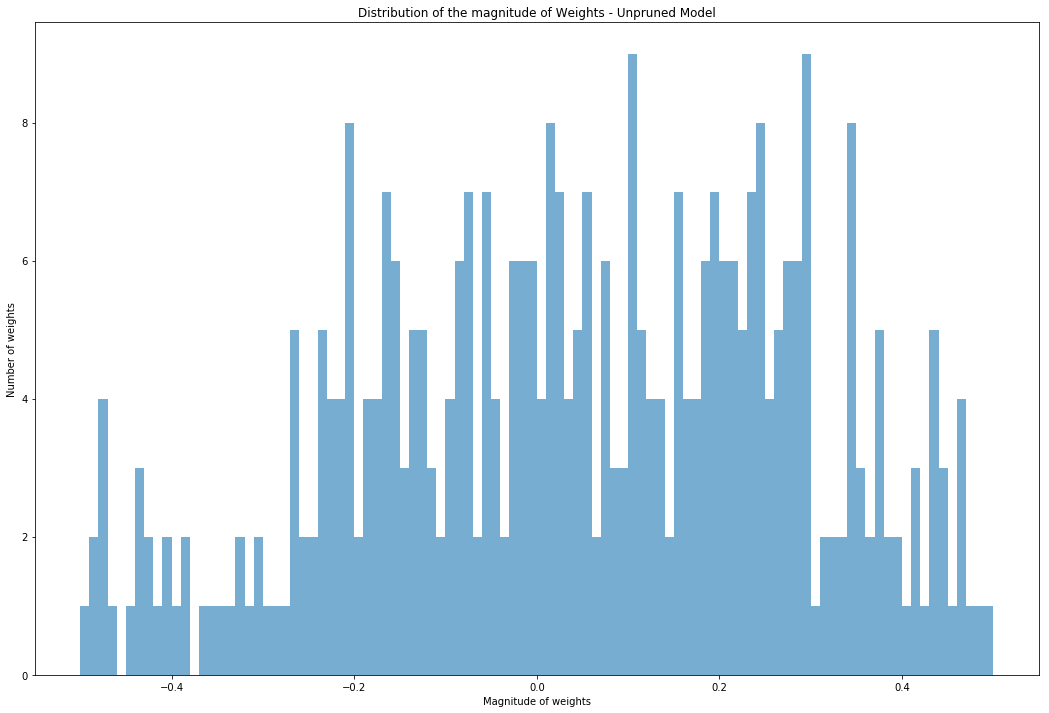

In [94]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

In [95]:
from keras.models import load_model
modelBuckup = load_model('my_model.h5')

## The Architecture of the Model

In [96]:
modelBuckup.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                120       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 42        
Total params: 582
Trainable params: 582
Non-trainable params: 0
_________________________________________________________________


In [97]:
# specify the layer should have N1 and N2 weights
L = 2
# Set Threshold and constant
Threshold = 0
constant=1

Set the number of rounding same for all methods

In [98]:
Round = 1800  # will be the same for all methods 1800

# Random policy


Random policy  or Epsilon-first strategy : during T rounds, sample a random arm (uniform sampling), and then choose the best arms.

## Pruning the Weights

In [99]:
modelBuckup = load_model('my_model.h5')
startP = time.time()
N_arry = np.zeros(N1*N2)
noExamples = len(X_train)
NL = np.zeros(Round)
RP = np.zeros(Round)
Avg_Accumaltive_RP = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_RP.reshape(N1,N2)
Count_RP = np.ones(N1*N2)
import random
count = 0

# uniform sampling 
for j in range(Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            ind = random.randint(0,N1*N2-1)
            i,k = np.unravel_index(ind, p_reshape.shape)
            #print(i,k)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            Count_RP[ind]=Count_RP[ind]+1
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            #print(reward)
            val = Count_RP[ind]
            Avg_Accumaltive_RP[ind] = (val-1)/val * Avg_Accumaltive_RP[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            RP[j]=ind

# Exploting 
# The  weight that has been chosen by Random policy method

reshapeRP = Avg_Accumaltive_RP.reshape(N1,N2)
P = np.argmax(Avg_Accumaltive_RP)
endP = time.time()
print("Execution time = ",endP - startP)
Pi,Pj = np.unravel_index(P, reshapeRP.shape)
print("\n The index of chosen  W_ji is = ", Pj, Pi)

Execution time =  20.252344131469727

 The index of chosen  W_ji is =  10 16


## Prune 5%, 10%, 25% and 50% from the unpruned model

Finsh playing start pruining:
Accuract after prune 5% is  0.8614457831325302
Accuract after prune 10% is  0.8634538152610441
Accuract after prune 25% is  0.8634538152610441
Accuract after prune 50% is  0.8594377510040161


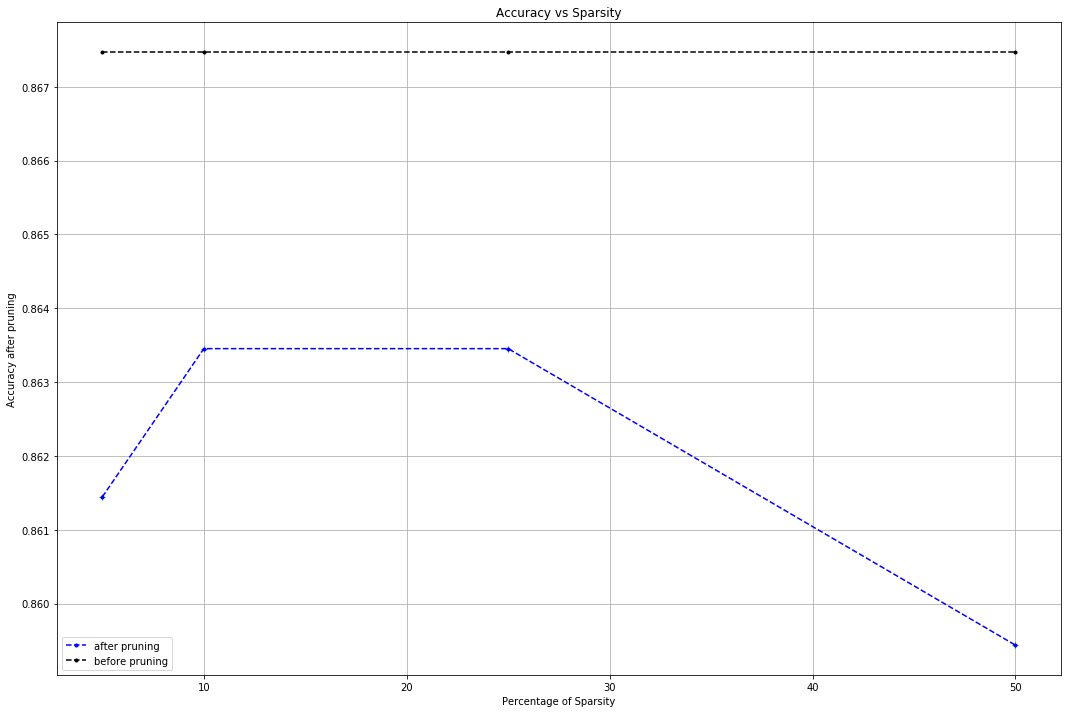

In [100]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_RP
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Random_Policy_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Random_Policy_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Random_Policy_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Random_Policy_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

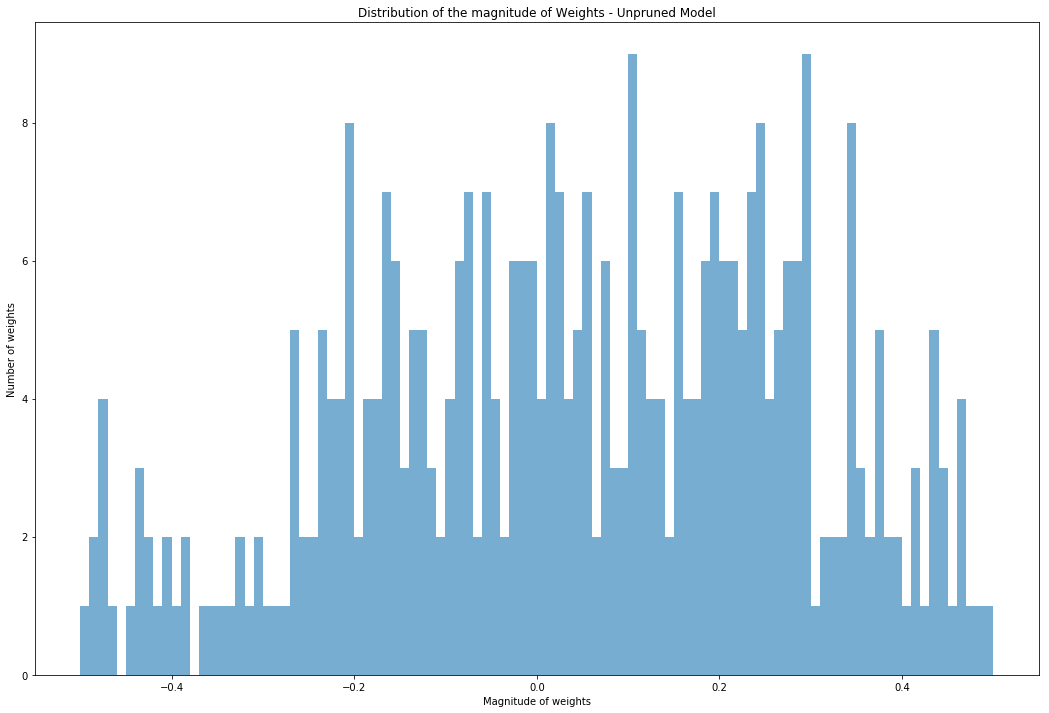

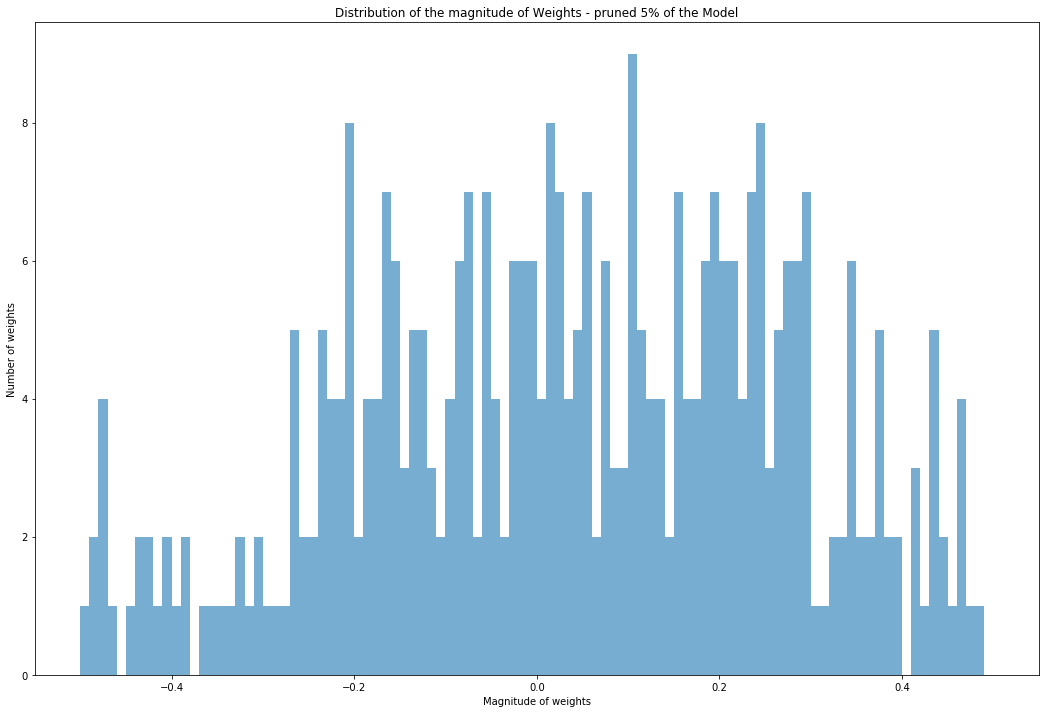

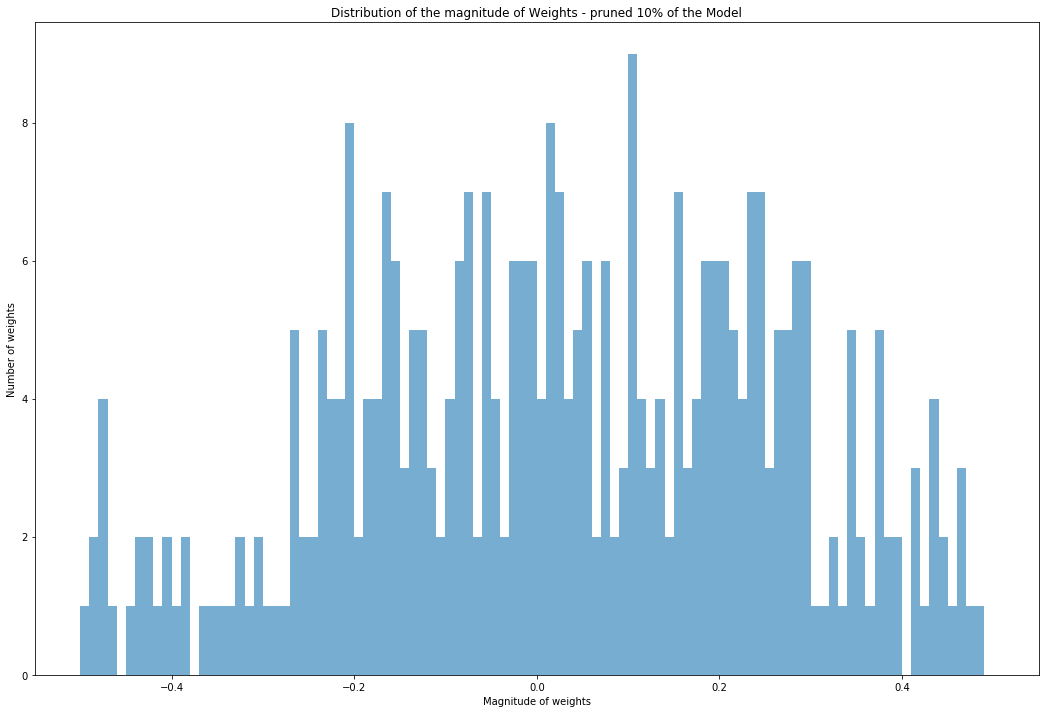

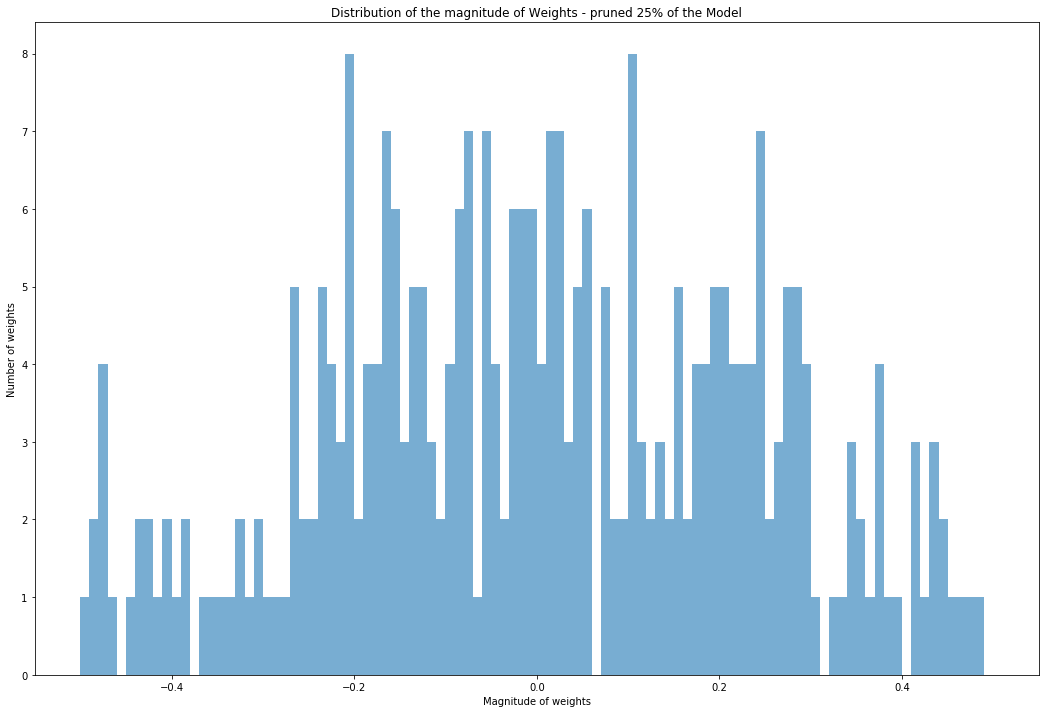

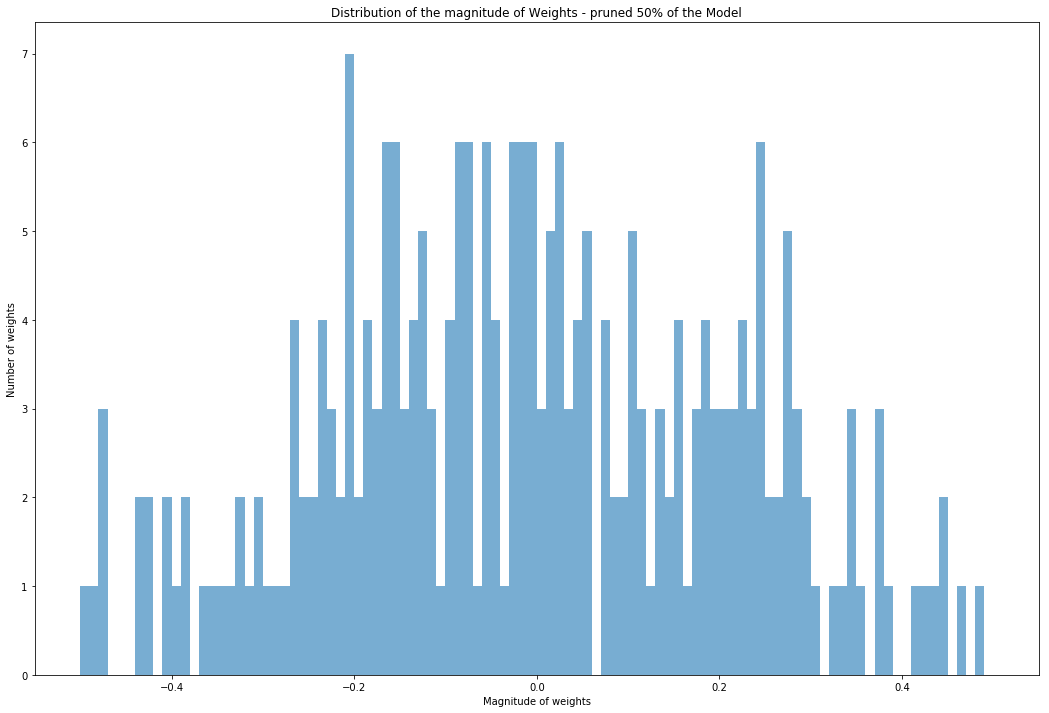

In [101]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('Random_Policy_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('Random_Policy_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('Random_Policy_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('Random_Policy_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

### On testing dataset (Unseen dataset)

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8132530120481928
The accuracy of the model after pruned 10 on testing data =  0.8132530120481928
The accuracy of the model after pruned 25 on testing data =  0.8132530120481928
The accuracy of the model after pruned 50 on testing data =  0.8313253012048193


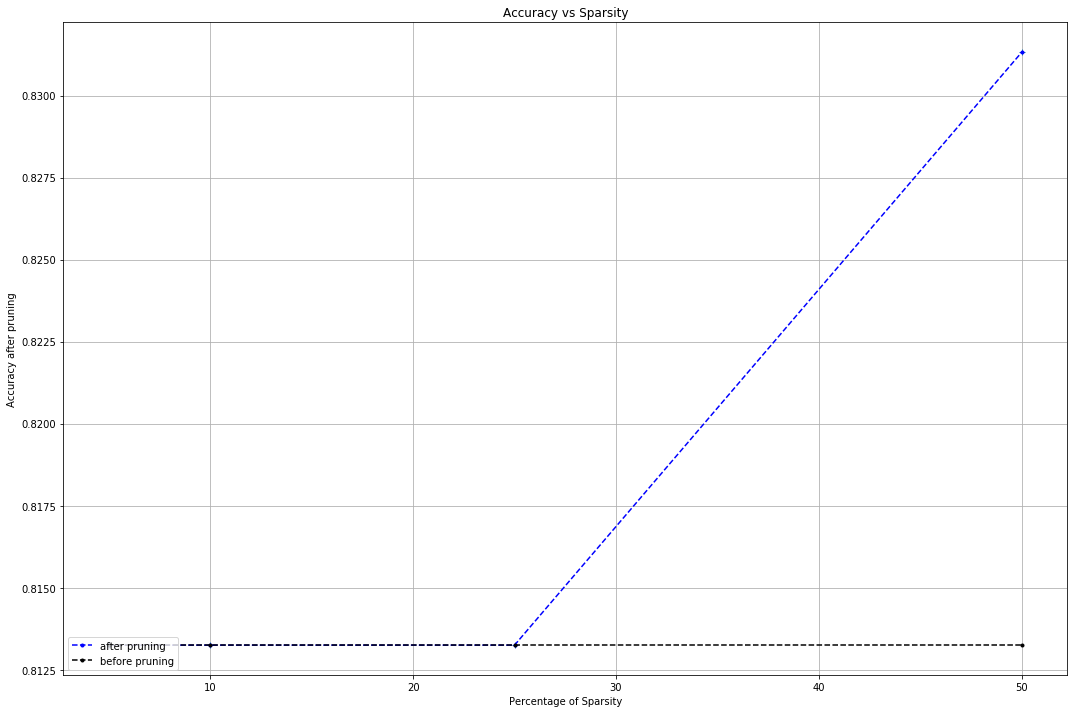

In [102]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('Random_Policy_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('Random_Policy_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('Random_Policy_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('Random_Policy_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

# Epsilon Greedy

## Pruning the Weights

In [103]:
modelBuckup = load_model('my_model.h5')
startG = time.time()
N_arry = np.zeros(N1*N2)
#noExamples = 100
NL = np.zeros(Round)
ep = np.zeros(Round)
Avg_Accumaltive_R_EGN = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_R_EGN.reshape(N1,N2)
Count_EGN = np.ones(N1*N2)
import random
epsilon=0.5
count = 0
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_R_EGN[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            if (epsilon>random.uniform(0, 1)):
                ind = np.argmax(Avg_Accumaltive_R_EGN)
            else:
                ind = random.randint(0,N1*N2-1)
            i,k = np.unravel_index(ind, p_reshape.shape)
            #print(i,k)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            Count_EGN[ind]=Count_EGN[ind]+1
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            #print(reward)
            val = Count_EGN[ind]
            Avg_Accumaltive_R_EGN[ind] = (val-1)/val * Avg_Accumaltive_R_EGN[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            ep[j]=ind
endG = time.time()
print("Execution time ",endG - startG)

Execution time  48.953070878982544


## The single weight that has been chosen by Epsilon Greedy method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [104]:
reshapeG = Avg_Accumaltive_R_EGN.reshape(N1,N2)
G = np.argmax(Avg_Accumaltive_R_EGN)
Gi,Gj = np.unravel_index(G, reshapeG.shape)
print("The index of chosen  W_ji is = ", Gj, Gi)

The index of chosen  W_ji is =  17 3


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8694779116465864
Accuract after prune 10% is  0.8674698795180723
Accuract after prune 25% is  0.8634538152610441
Accuract after prune 50% is  0.8554216867469879


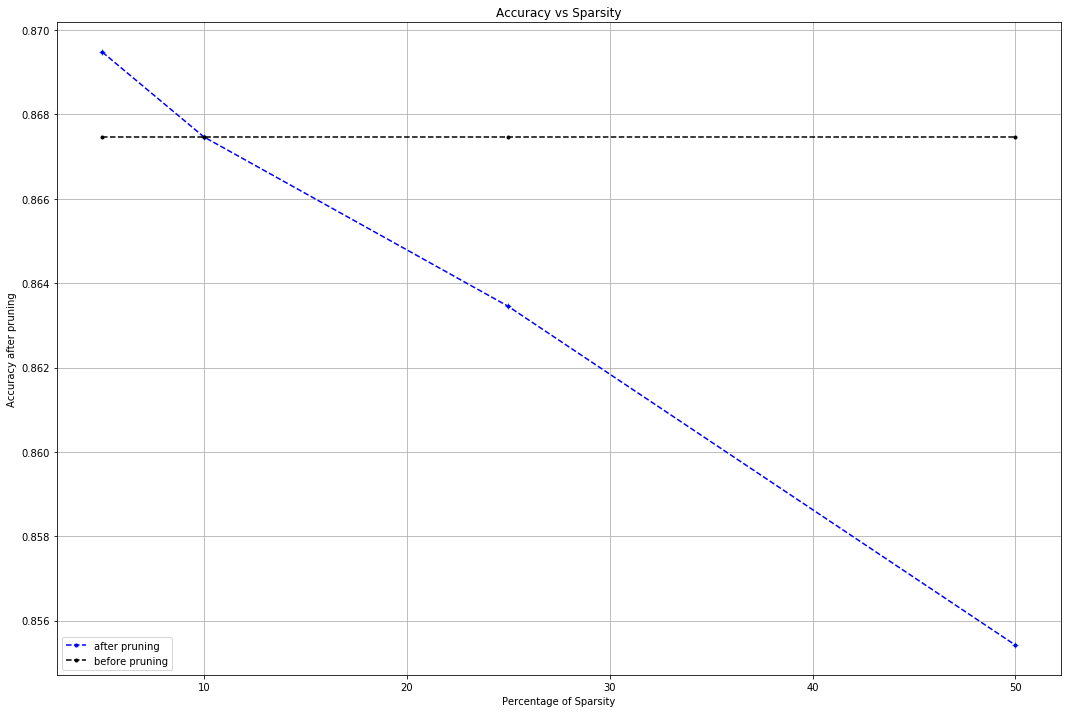

In [105]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_R_EGN
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Epsilon_Greedy_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Epsilon_Greedy_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Epsilon_Greedy_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Epsilon_Greedy_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

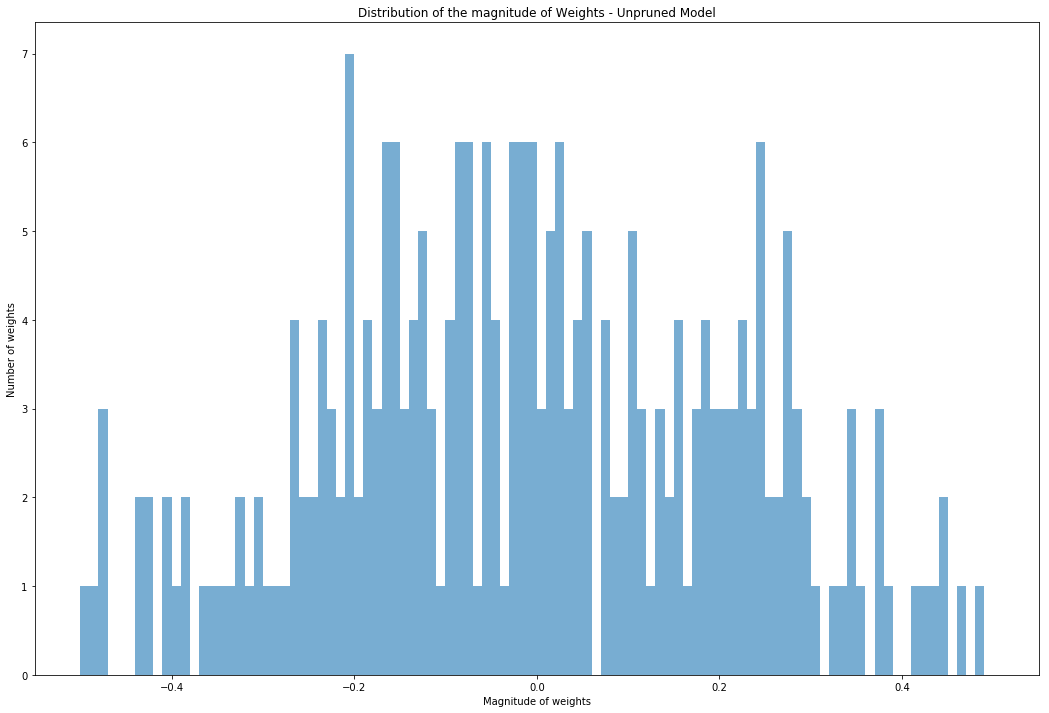

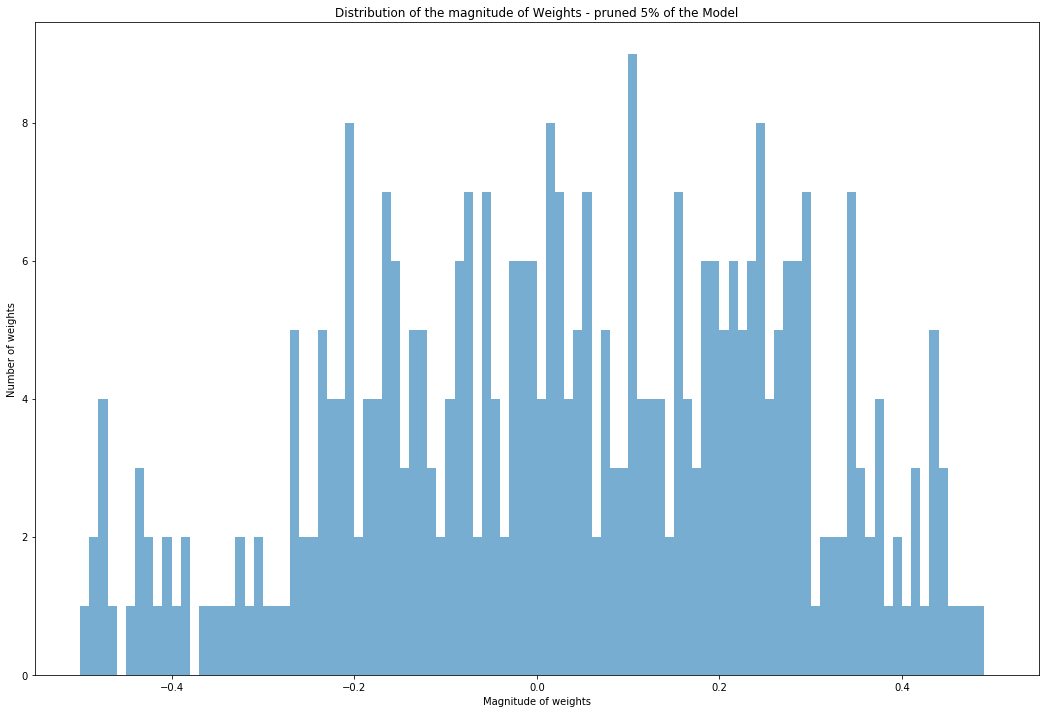

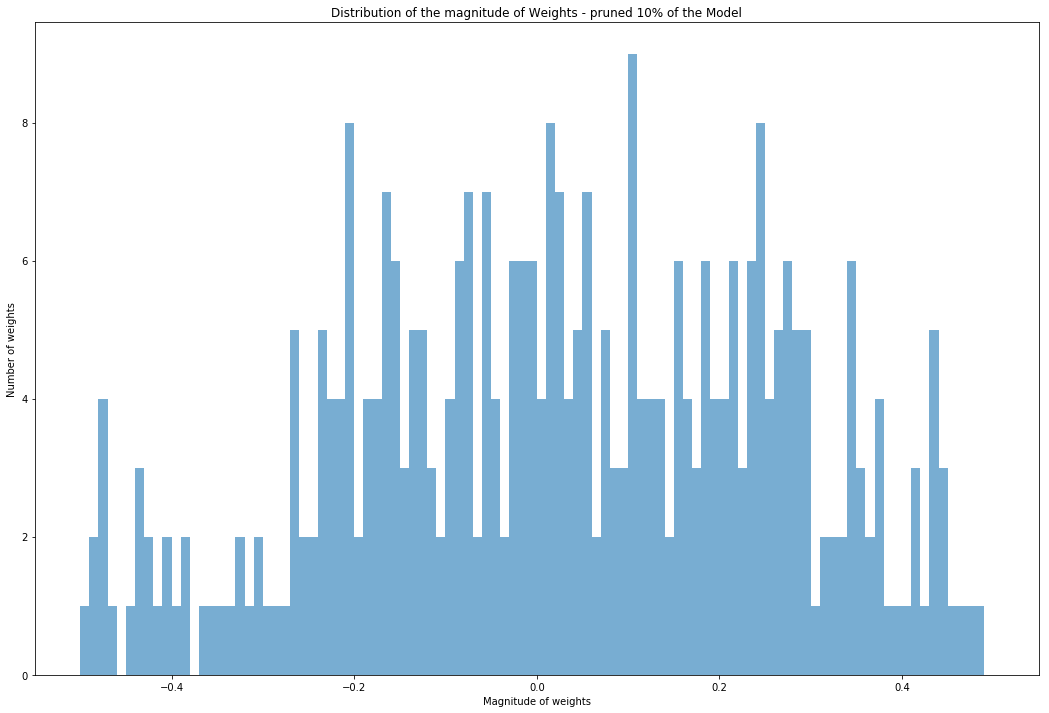

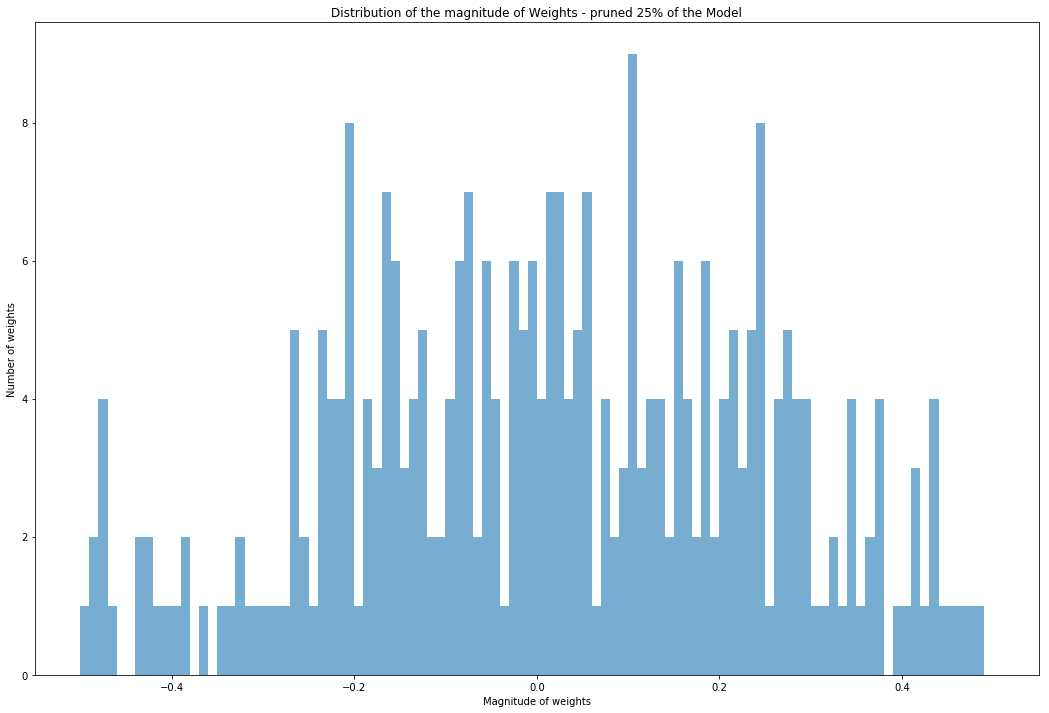

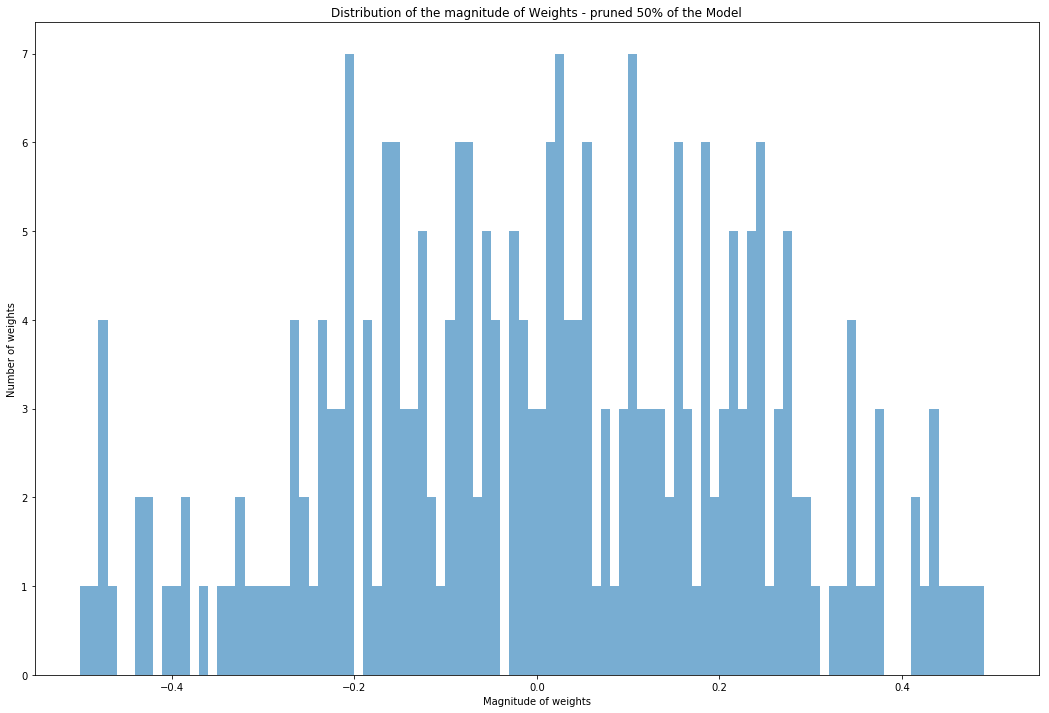

In [106]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('Epsilon_Greedy_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('Epsilon_Greedy_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('Epsilon_Greedy_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('Epsilon_Greedy_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

### On testing dataset (Unseen dataset)

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8132530120481928
The accuracy of the model after pruned 10 on testing data =  0.8253012048192772
The accuracy of the model after pruned 25 on testing data =  0.8313253012048193
The accuracy of the model after pruned 50 on testing data =  0.822289156626506


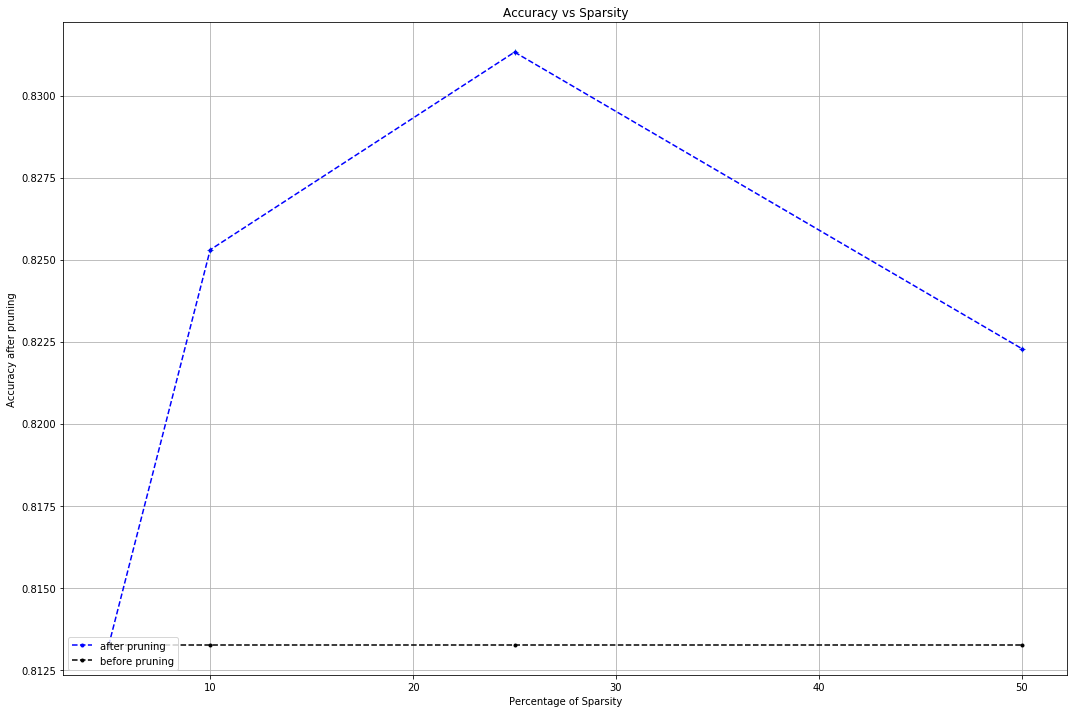

In [107]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('Epsilon_Greedy_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('Epsilon_Greedy_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('Epsilon_Greedy_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('Epsilon_Greedy_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

# UCB1

## Pruning Weights

In [108]:
modelBuckup = load_model('my_model.h5')
startU = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_UCB = np.zeros(N1*N2)
Count_UCB = np.ones(N1*N2)
UCB1 = np.zeros(Round)
p_reshape = Avg_Accumaltive_UCB.reshape(N1,N2)
count = 0
import random
tau=4
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_UCB[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            padding = np.sqrt(2*Count_UCB.sum()/Count_UCB)
            ucb = Avg_Accumaltive_UCB + padding
            ind = np.argmax(ucb)
            Count_UCB[ind] = Count_UCB[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0           
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            val = Count_UCB[ind]
            Avg_Accumaltive_UCB[ind] = (val-1)/val * Avg_Accumaltive_UCB[ind] + 1/val * reward
            modelBuckup.set_weights(All_weights)
            UCB1[j]=ind
endU = time.time()
print("Execution time ",endU - startU)

Execution time  42.72261714935303


## The single weight that has been chosen by UCB1 method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [109]:
reshapeU = Avg_Accumaltive_UCB.reshape(N1,N2)
U = np.argmax(Avg_Accumaltive_UCB)
Ui,Uj = np.unravel_index(U, reshapeU.shape)
print("The index of chosen  W_ji is = ", Uj, Ui)

The index of chosen  W_ji is =  0 8


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8634538152610441
Accuract after prune 10% is  0.8674698795180723
Accuract after prune 25% is  0.8634538152610441
Accuract after prune 50% is  0.8554216867469879


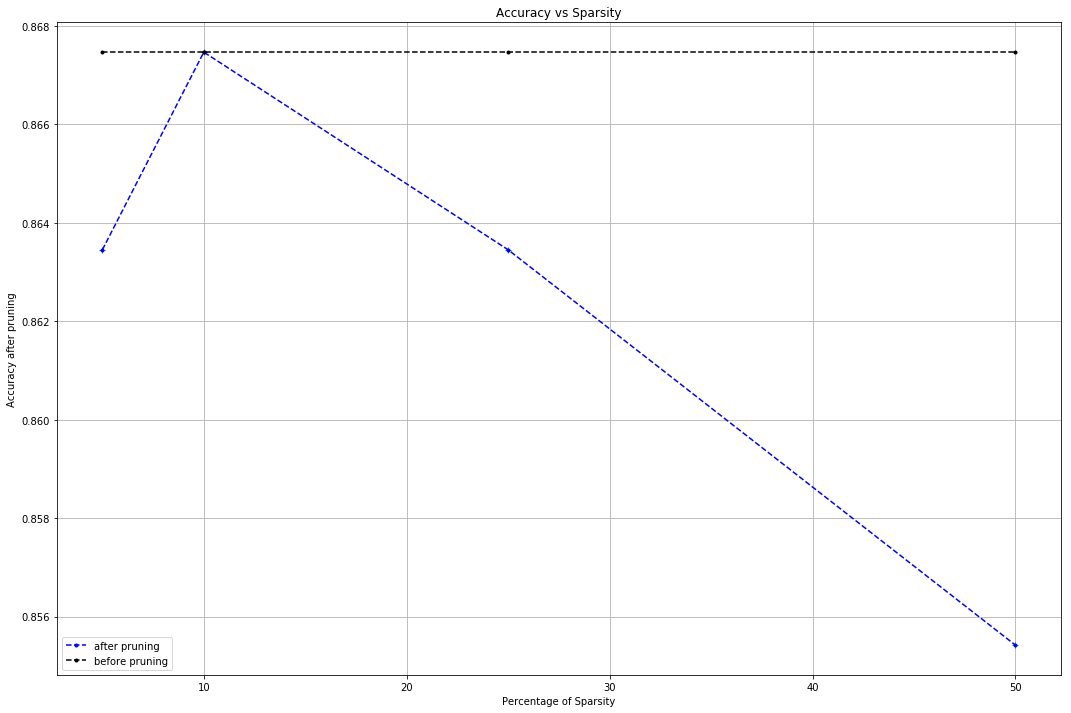

In [110]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_UCB
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('UCB1_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('UCB1_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('UCB1_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('UCB1_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

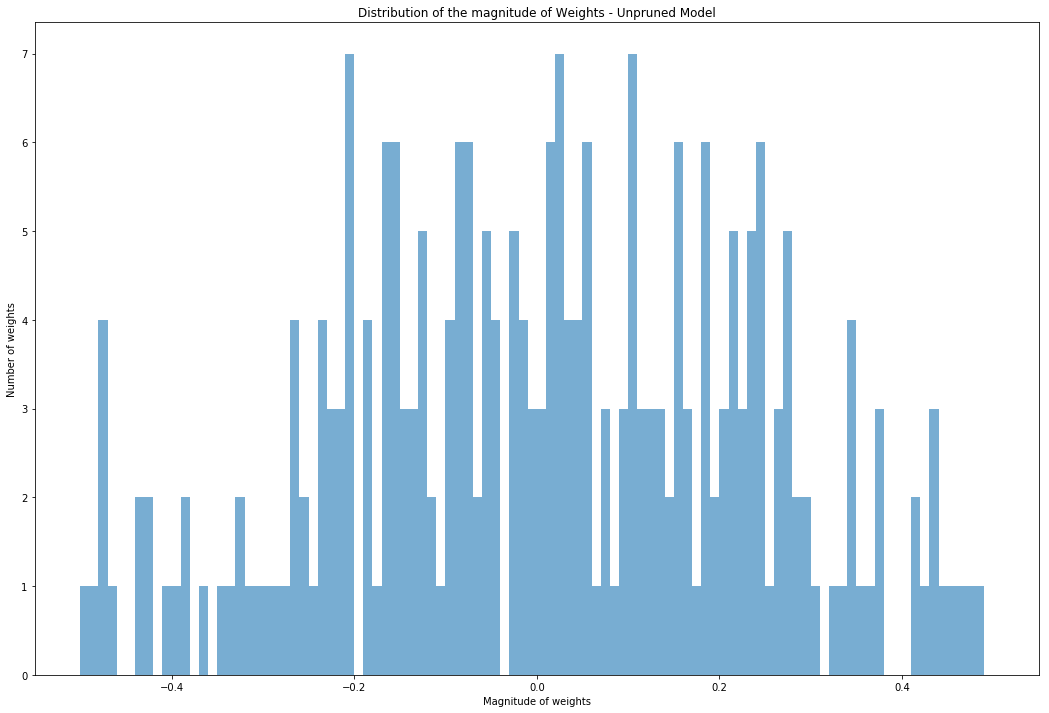

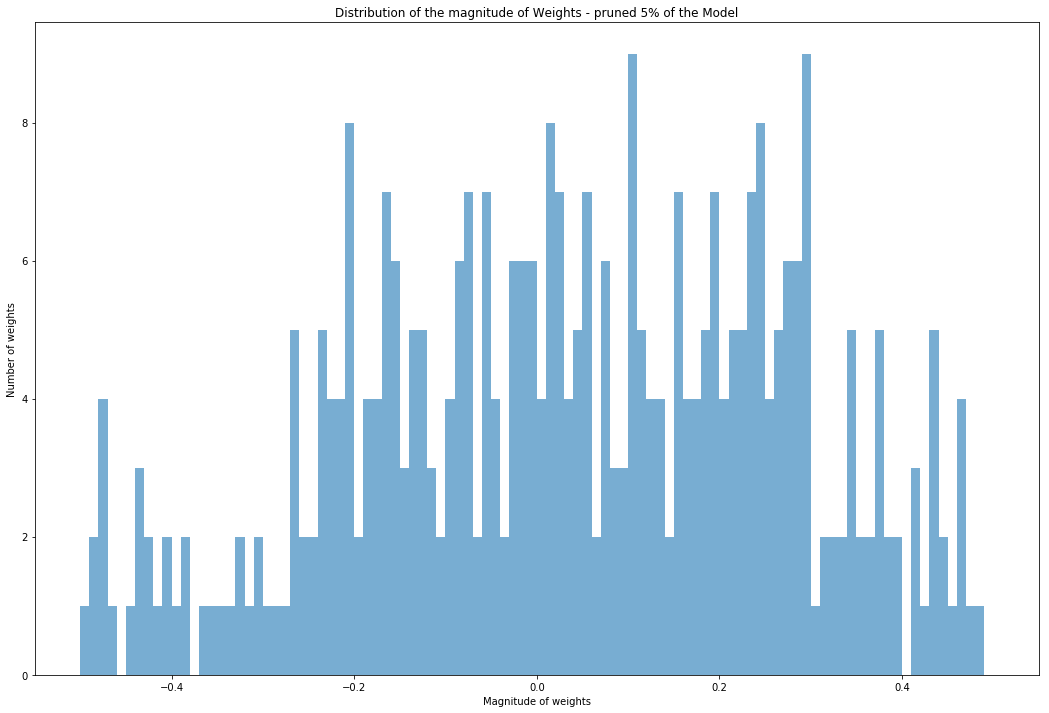

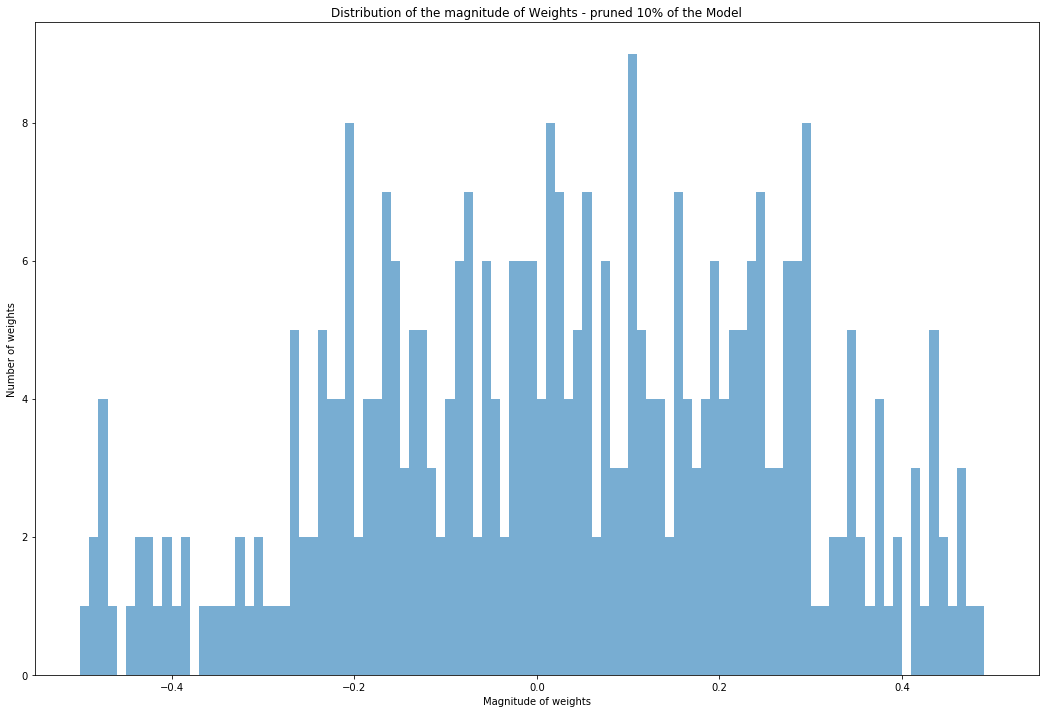

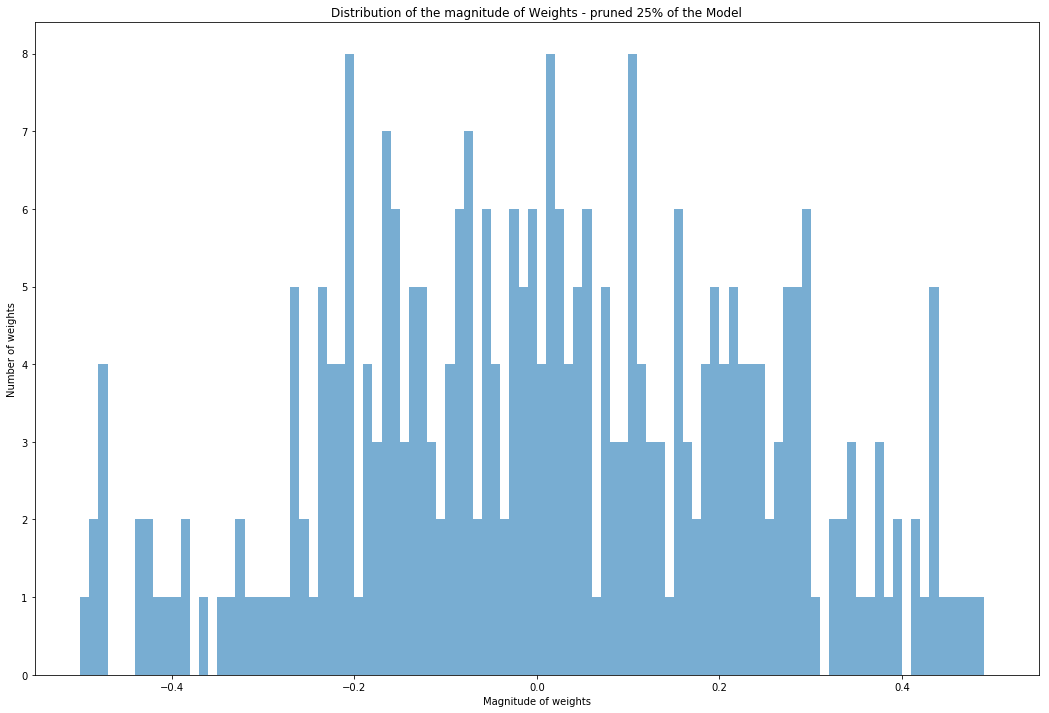

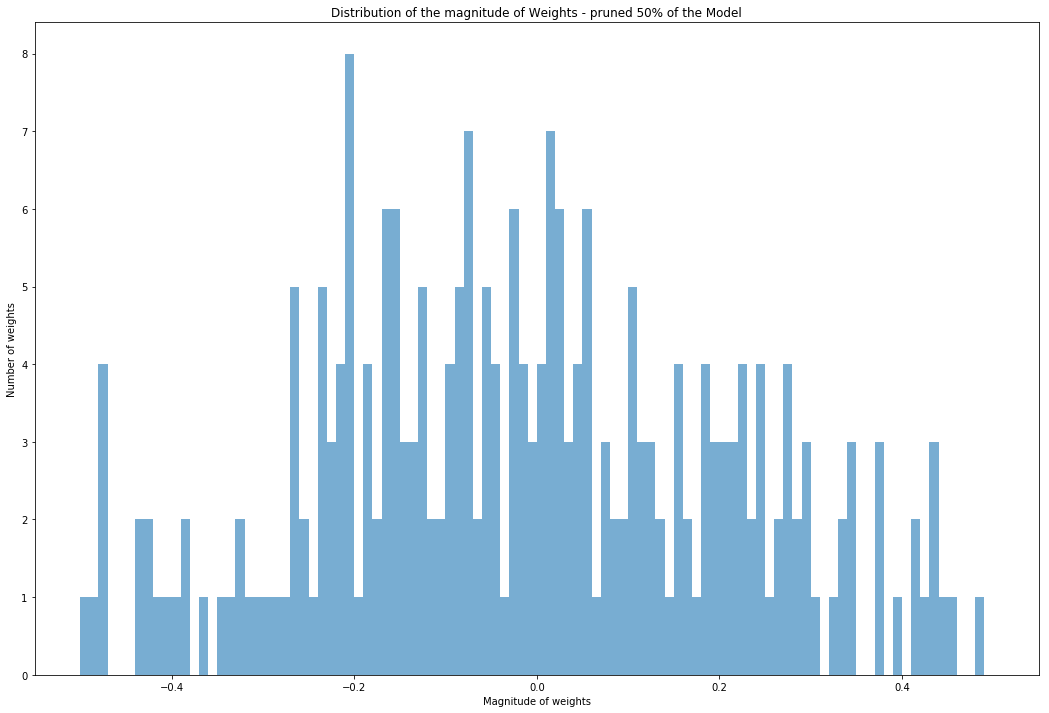

In [111]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('UCB1_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('UCB1_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('UCB1_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('UCB1_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8192771084337349
The accuracy of the model after pruned 10 on testing data =  0.8253012048192772
The accuracy of the model after pruned 25 on testing data =  0.8283132530120482
The accuracy of the model after pruned 50 on testing data =  0.8253012048192772


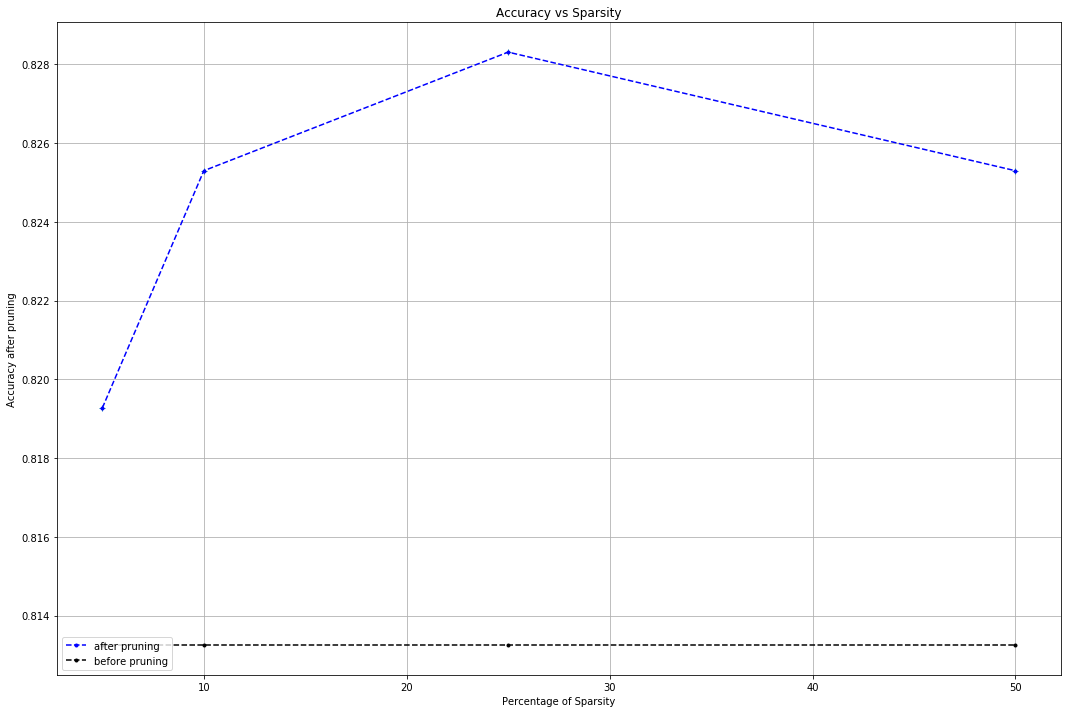

In [112]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('UCB1_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('UCB1_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('UCB1_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('UCB1_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

# Thompson Sampling

## Pruning weights

In [113]:
modelBuckup = load_model('my_model.h5')
startT = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_TS = np.zeros(N1*N2)
Count_TS = np.ones(N1*N2)
TS = np.zeros(Round)
p_reshape = Avg_Accumaltive_TS.reshape(N1,N2)
count = 0
success = np.zeros(N1*N2)
failure = np.zeros(N1*N2)
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1                        
            All_weights[2][i][j]= temp
            Avg_Accumaltive_TS[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer 
            ind = np.argmax(np.random.beta(1+success, 1+failure))
            Count_TS[ind] = Count_TS[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0                     
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1            
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)          
            val = Count_TS[ind]
            Avg_Accumaltive_TS[ind] = (val-1)/val * Avg_Accumaltive_TS[ind] + 1/val * reward
            TS[j]=ind
endT = time.time()
print("Execution time ",endT - startT)

Execution time  48.20453405380249


## The single weight that has been chosen by Thompson Sampling method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [114]:
reshapeT = Avg_Accumaltive_TS.reshape(N1,N2)
T = np.argmax(Avg_Accumaltive_TS)
Ti,Tj = np.unravel_index(T, reshapeT.shape)
print("The index of chosen  W_ji is = ", Tj, Ti)

The index of chosen  W_ji is =  0 0


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8674698795180723
Accuract after prune 10% is  0.8694779116465864
Accuract after prune 25% is  0.8614457831325302
Accuract after prune 50% is  0.8534136546184738


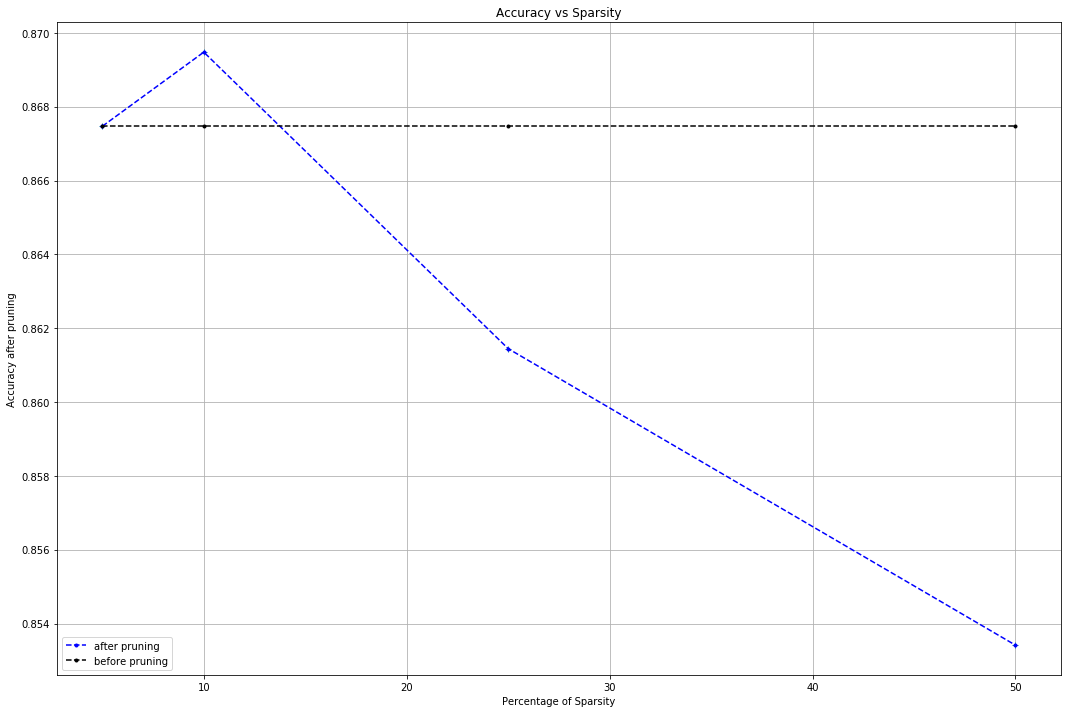

In [115]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_TS
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Thompson_Sampling_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Thompson_Sampling_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Thompson_Sampling_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Thompson_Sampling_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

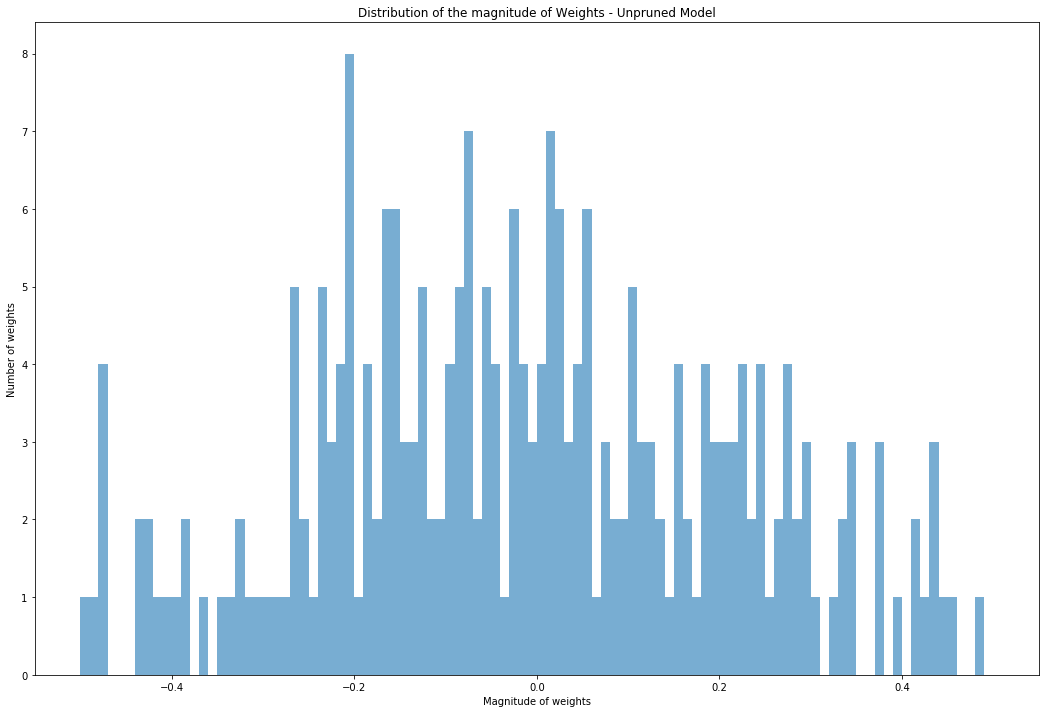

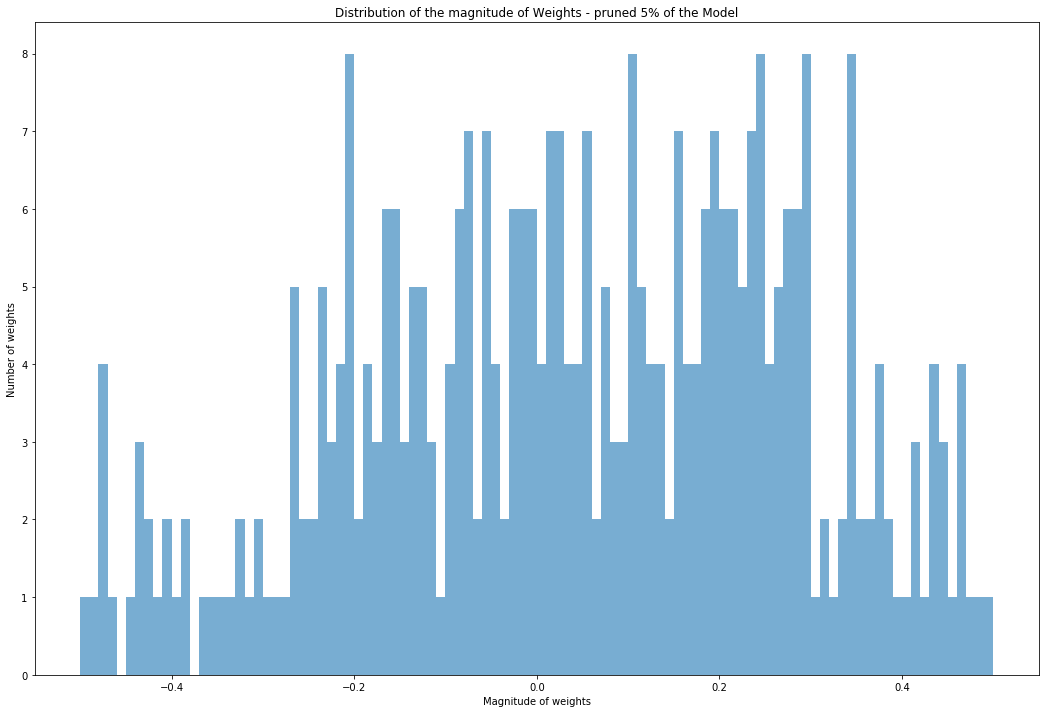

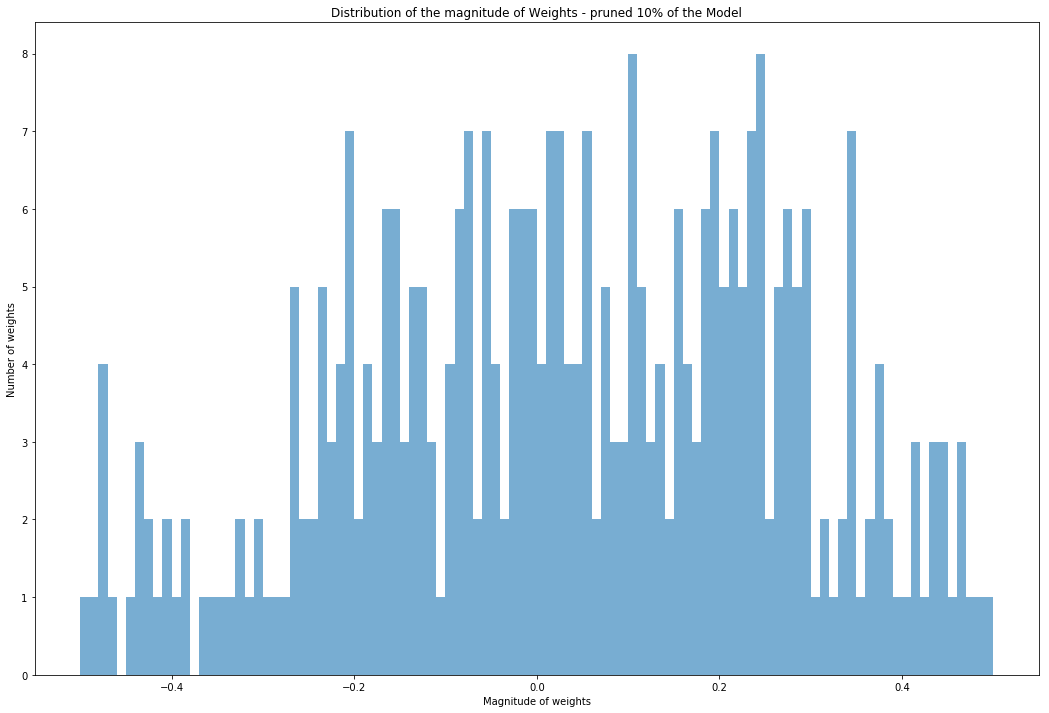

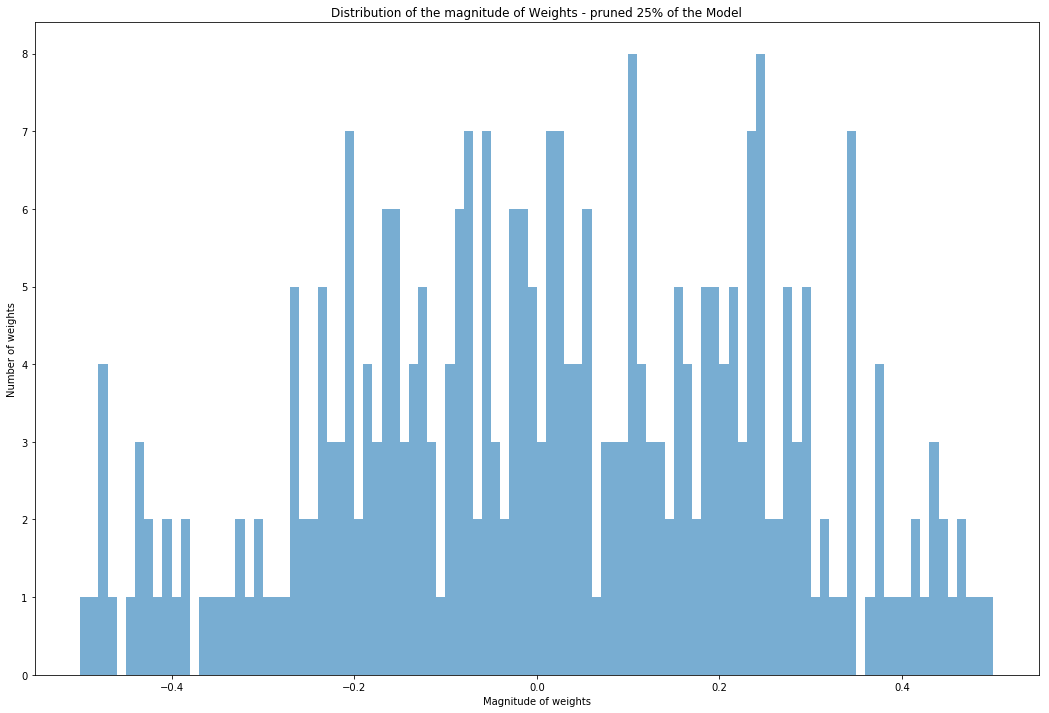

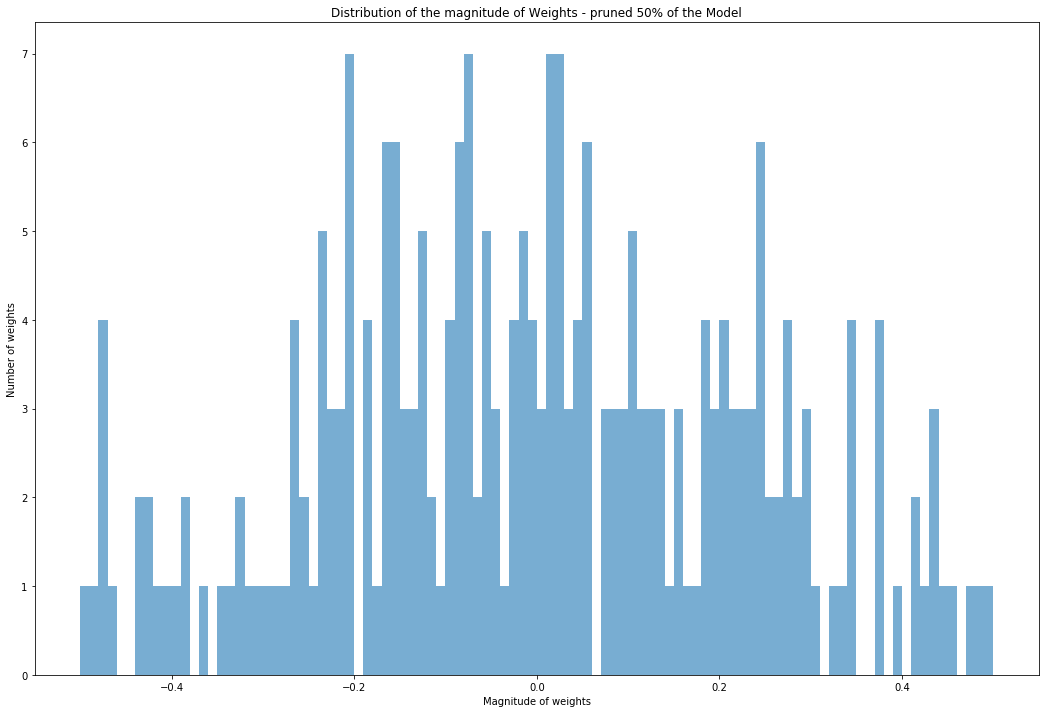

In [116]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('Thompson_Sampling_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('Thompson_Sampling_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('Thompson_Sampling_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('Thompson_Sampling_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8132530120481928
The accuracy of the model after pruned 10 on testing data =  0.8132530120481928
The accuracy of the model after pruned 25 on testing data =  0.8132530120481928
The accuracy of the model after pruned 50 on testing data =  0.8253012048192772


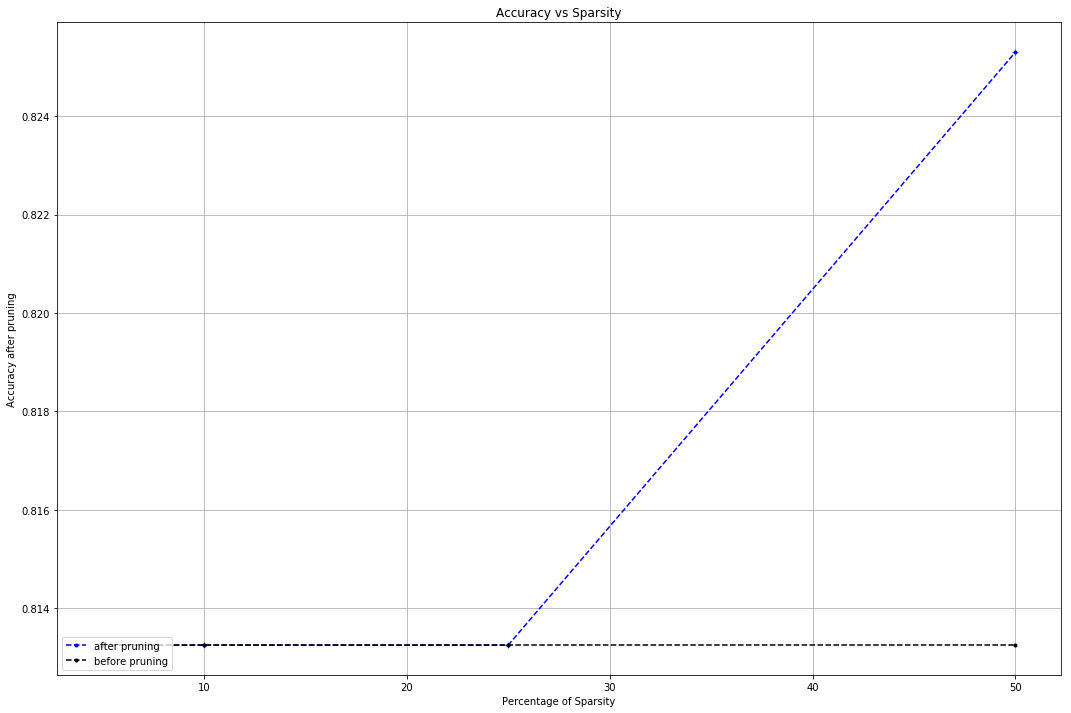

In [117]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('Thompson_Sampling_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('Thompson_Sampling_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('Thompson_Sampling_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('Thompson_Sampling_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

# Successive Rejects

For a K-armed bandit, Successive Rejects operates in (K − 1) phases. At the end of each phase, the arm with the lowest average reward is discarded. Thus, at the end of phase (K − 1) only one arm survives, and this arm is recommended.


## Pruning weights

In [118]:
modelBuckup = load_model('my_model.h5')
startS = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(noExamples)
sr = []
Avg_Accumaltive_SR = np.zeros(N1*N2)
Avg_Accumaltive_SR2 = np.zeros(N1*N2)
Avg_Accumaltive_SR1 = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_SR2.reshape(N1,N2)
check_array = np.ones((N1,N2))
Count_SR = np.ones(N1*N2)
A = [0]
Nk = []
K = N1*N2
Log = 0.5
for k in range(K):
    d = k+2
    Log = Log + 1/d
for k in range(K-2):
    d = k+1
    nK = int(np.floor(1/Log * (Round-K)/(K+1-d)))
    if nK!=0:
        A.append(nK)
A.sort(reverse=False)
#print("The round of the phases : ",A)
g=0
for a in A:
    h = a - g
    g = a
    Nk.append(h)
    count=0
    #print(a)
    for n in range(h):
        c=0
        for i in range(N1):
            for j in range(N2):
                if check_array[i][j]==1:
                    b = random.randint(0,noExamples-1) 
                    loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
                    All_weights=modelBuckup.get_weights()
                    temp = All_weights[2][i][j]
                    All_weights[2][i][j] = 0
                    modelBuckup.set_weights(All_weights)
                    loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
                    delta = loss_New - loss
                    reward = max(0,Threshold + delta)/constant
                    All_weights[2][i][j] = temp
                    modelBuckup.set_weights(All_weights)
                    val = Count_SR[c]
                    #print(reward)
                    Avg_Accumaltive_SR[c] = (val-1)/val * Avg_Accumaltive_SR[c] + 1/val * reward
                    All_weights[2][i][j] = temp
                    modelBuckup.set_weights(All_weights)
                    count = count+1
                    c = c + 1    
        Avg_Accumaltive_SR2=Avg_Accumaltive_SR2+Avg_Accumaltive_SR
        Avg_Accumaltive_SR1=Avg_Accumaltive_SR2.copy()
    ind = np.argmin(Avg_Accumaltive_SR2)
    Avg_Accumaltive_SR2[ind] = 100
    #print(Avg_Accumaltive_SR)
    s,t = np.unravel_index(ind, p_reshape.shape)
    ###check_array[s][t]=0
    sr.append(ind)
endS = time.time()
print("Execution time ",endS - startS)
#print("A = ", A)
#print("Nk = ", Nk)

Execution time  452.02689576148987


In [119]:
Avg_Accumaltive_SR3 = np.abs(100-Avg_Accumaltive_SR2)

## The single weight that has been chosen by Successive Rejects method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [120]:
reshapeS = Avg_Accumaltive_SR3.reshape(N1,N2)
S = np.argmax(Avg_Accumaltive_SR3)
Si,Sj = np.unravel_index(S, reshapeS.shape)
print("The index of chosen  W_ji is = ", Sj, Si)

The index of chosen  W_ji is =  17 14


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8614457831325302
Accuract after prune 10% is  0.8614457831325302
Accuract after prune 25% is  0.8634538152610441
Accuract after prune 50% is  0.8654618473895582


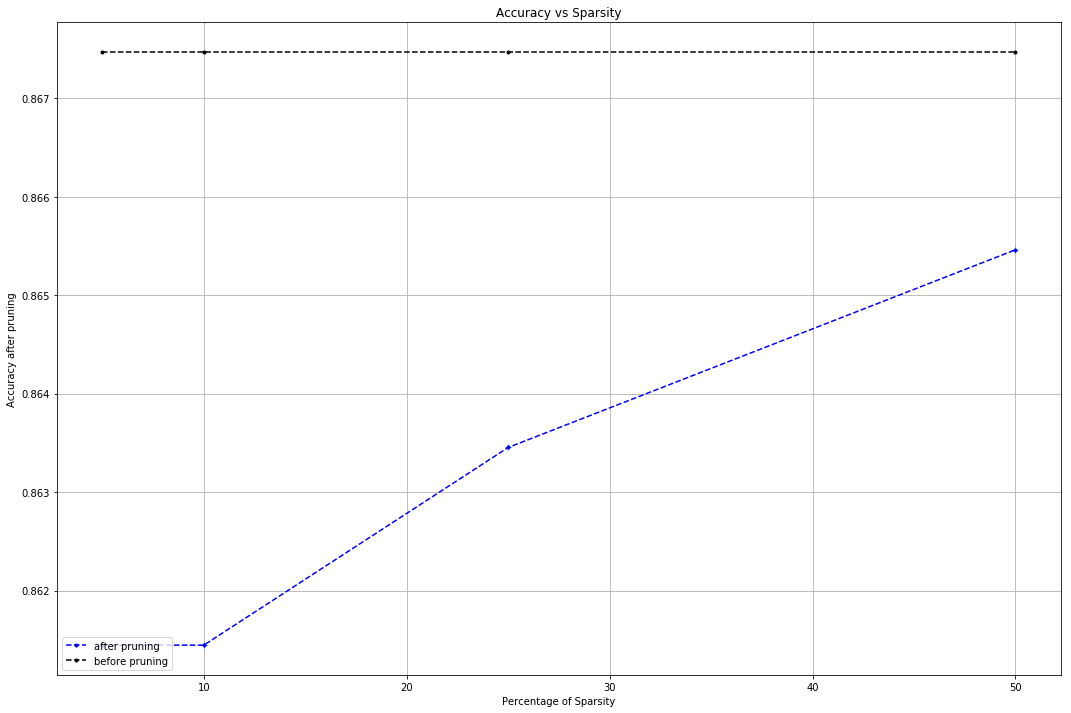

In [121]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_SR3
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Successive_Rejects_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Successive_Rejects_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Successive_Rejects_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Successive_Rejects_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

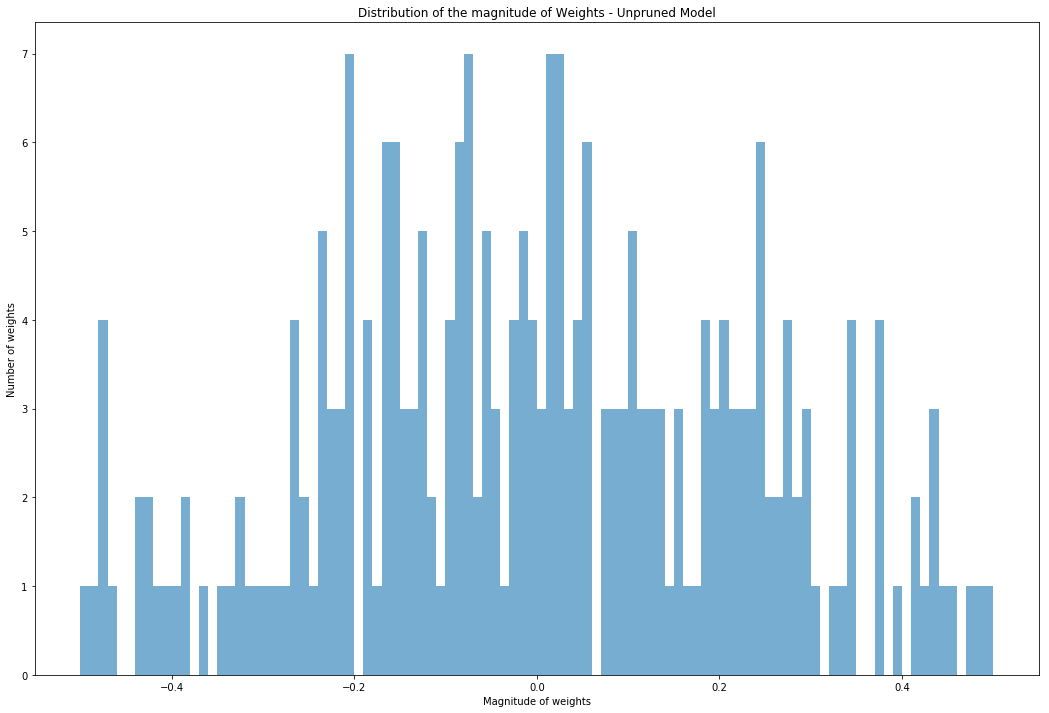

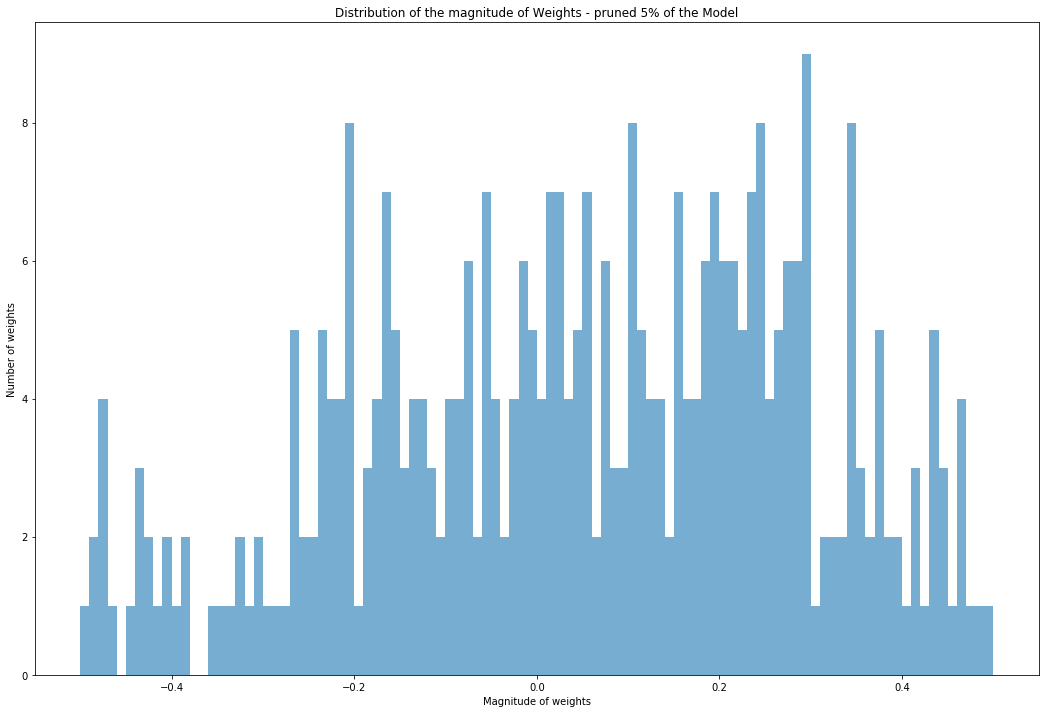

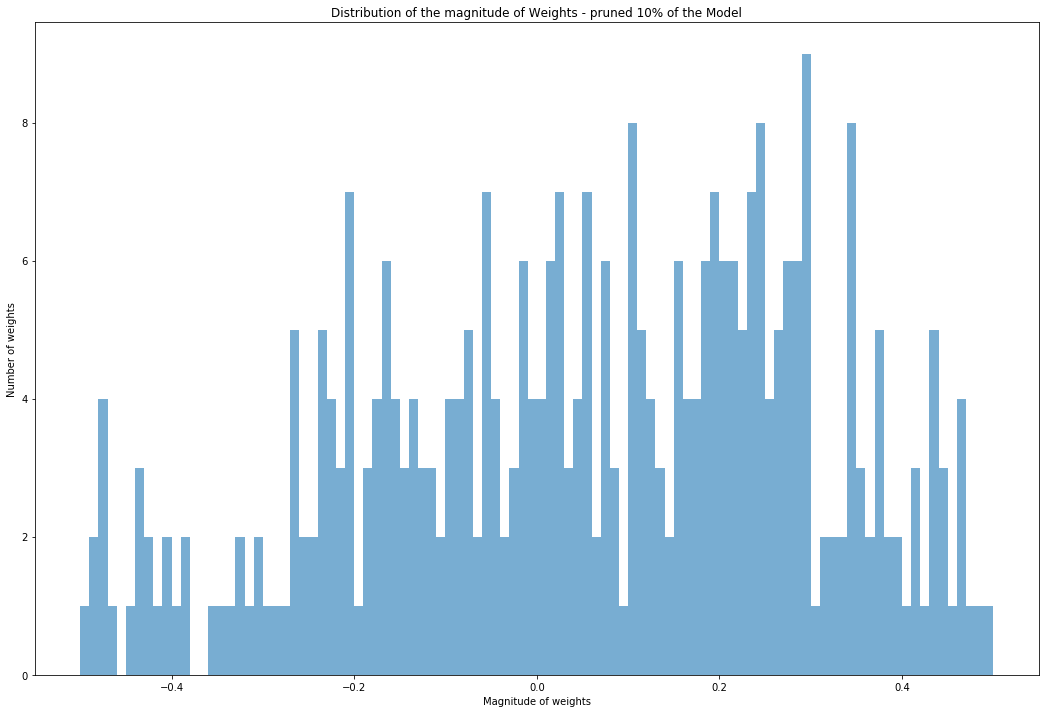

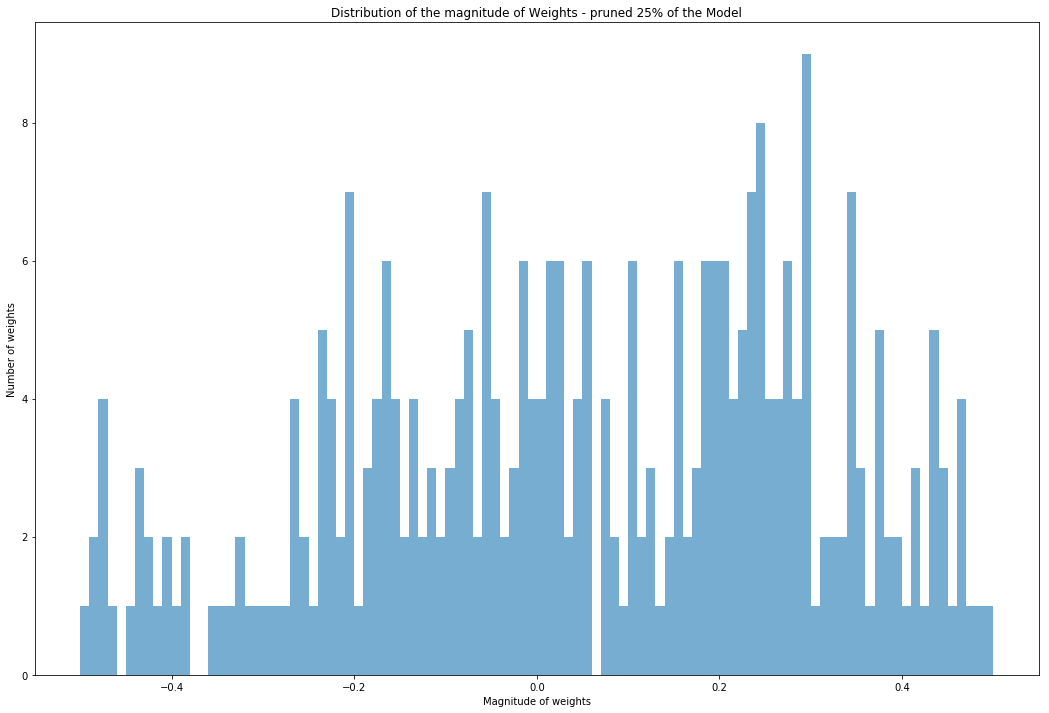

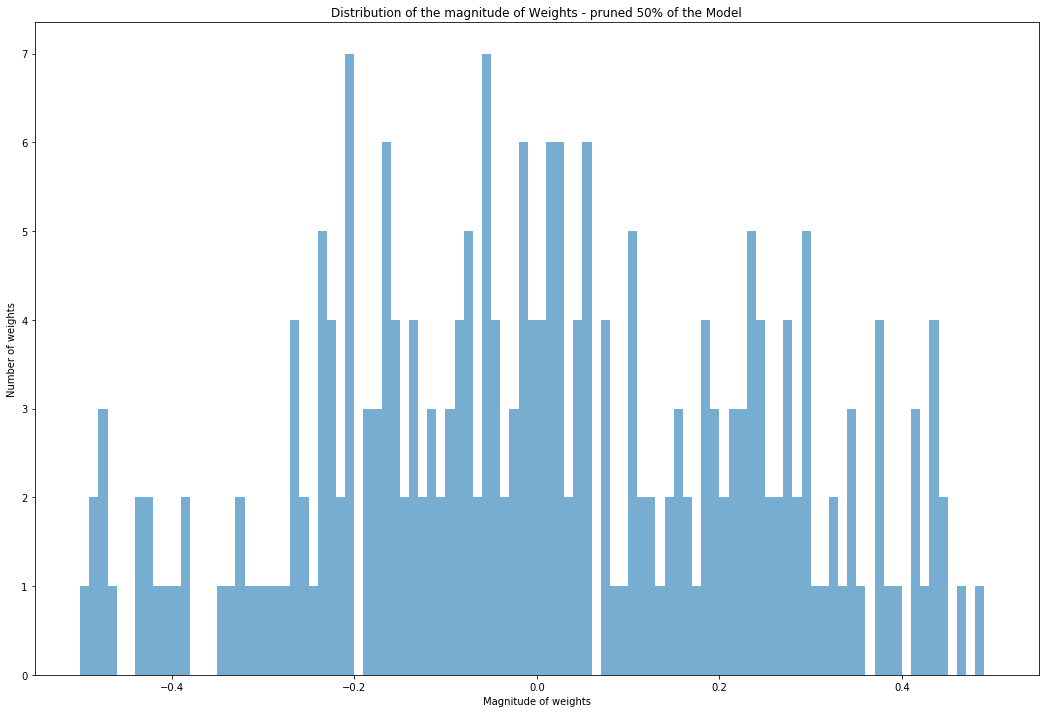

In [122]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('Successive_Rejects_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('Successive_Rejects_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('Successive_Rejects_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('Successive_Rejects_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8162650602409639
The accuracy of the model after pruned 10 on testing data =  0.8132530120481928
The accuracy of the model after pruned 25 on testing data =  0.8283132530120482
The accuracy of the model after pruned 50 on testing data =  0.8283132530120482


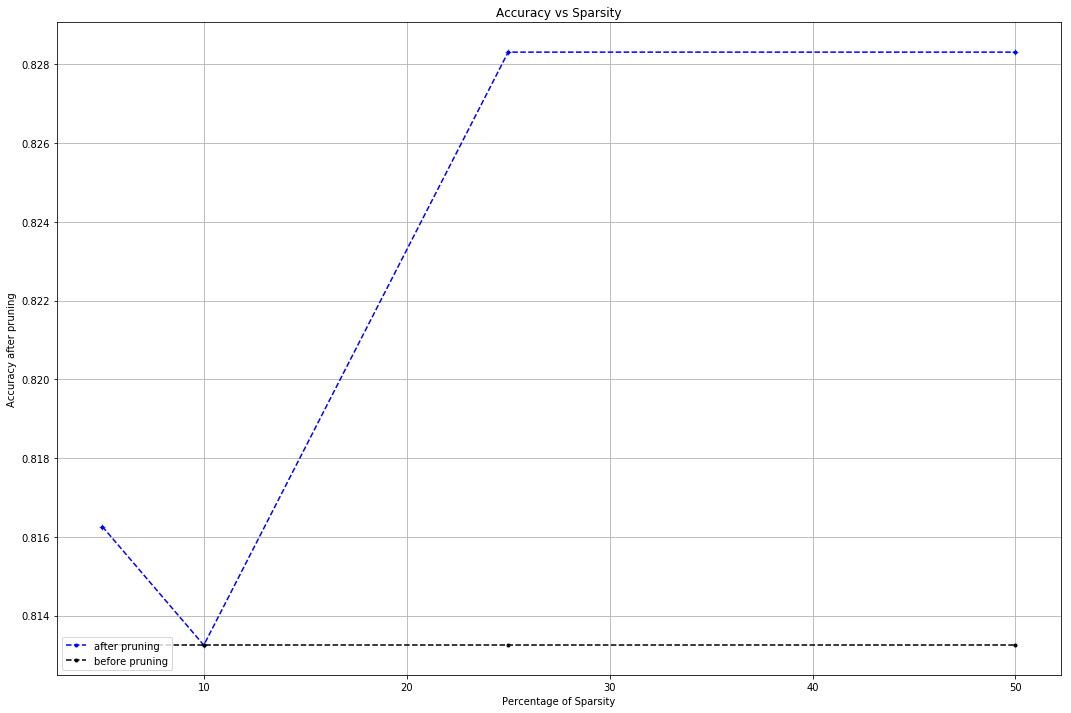

In [123]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('Successive_Rejects_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('Successive_Rejects_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('Successive_Rejects_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('Successive_Rejects_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

# Best Arm Identification: A Unified Approach to Fixed Budget and Fixed Confidence



The implimetation based on:




K. Terayama, H. Iwata, M. Araki, Y. Okuno, K. Tsuda, "Machine Learning Accelerates MD-based Binding-Pose Prediction between Ligands and Proteins", Bioinformatics, 2017.


Gabillon, V.; Ghavamzadeh, M.; Lazaric, A. "Best arm identification: A unified approach to fixed budget and fixed confidence." NIPS, pp.3212–3220, 2012.

## Pruning weights

In [124]:
a=0.25
def beta(s, budget, K, a, mean_list, automatic = False, auto_para = 1, H = 1):
    if automatic:
        alpha = auto_para

        a = alpha* (budget - K)/(4*H)
        return np.sqrt(a / s)
    else:
        return np.sqrt(a*(budget - K) / s)

def U(i, t, budget, pulls, a):
    K = len(pulls)
    return np.mean(pulls[i]) + beta(len(pulls[i]), budget, K, a)

def L(i, t, budget, pulls, a):
    K = len(pulls)
    return np.mean(pulls[i]) - beta(len(pulls[i]), budget, K, a)

def B(i, t, budget, pulls, a, K):
    list_woi = range(K)
    list_woi.pop(i)
    return np.max([U(j, t, budget, pulls, a) - L(i, t, budget, pulls, a)  for j in list_woi])

def calc_B(k, U_l, L_l, K, max_U_i_t_index, max_U_i_t, max_U_i_eq_k):
    if k == max_U_i_t_index:
        return max_U_i_eq_k - L_l[k]
    else:
        return max_U_i_t - L_l[k]

In [125]:
import copy as cp
modelBuckup = load_model('my_model.h5')
startUB = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_UB = np.zeros(N1*N2)
Count_UB = np.ones(N1*N2)
UB = np.zeros(Round)
p_reshape = Avg_Accumaltive_UB.reshape(N1,N2)
count = 0
import random
K = N1*N2
# Play each arm once
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_UB[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
#Exploration loop
for j in range(N1*N2-1, Round):
            mean_list = [np.mean(Avg_Accumaltive_UB[i]) for i in range(K)]
            beta_list = [beta(len([Avg_Accumaltive_UB[i]]), Round, K, a, mean_list) for i in range(K)]
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            U_list = [mean_list[i] + beta_list[i] for i in range(K)]
            L_list = [mean_list[i] - beta_list[i] for i in range(K)]
            max_U_i_t_index = np.argmax(U_list)
            max_U_i_t = U_list[max_U_i_t_index]
            max_U_i_eq_k = np.max(cp.copy(U_list).pop(max_U_i_t_index))
            B_list = [calc_B(k, U_list, L_list, K, max_U_i_t_index, max_U_i_t, max_U_i_eq_k) for k in range(K)]
            J_t = np.argmin([B_list[i] if Count_UB[i] < 20 else 10**10 for i in range(K)])
            list_woJt = list(range(K))
            list_woJt.pop(J_t)
            u_t = list_woJt[np.argmax([U_list[i] if Count_UB[i] < 20 else -10**10 for i in list_woJt])]
            l_t = J_t
            I_t = [l_t, u_t][np.argmax([beta_list[i] for i in [l_t, u_t]])]   
            i,k = np.unravel_index(ind, p_reshape.shape)
            Count_UB[I_t] = Count_UB[I_t] + 1     
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0           
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            val = Count_UB[I_t]
            Avg_Accumaltive_UB[I_t] = (val-1)/val * Avg_Accumaltive_UB[I_t] + 1/val * reward
            modelBuckup.set_weights(All_weights)
            UB[j]=I_t            
endUB = time.time()
print("Execution time ",endUB - startUB)

Execution time  60.52384114265442


In [126]:
Avg_Accumaltive_UB3 = np.abs(100-Avg_Accumaltive_UB)

## The single weight that has been chosen by Successive Rejects method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [127]:
reshapeS = Avg_Accumaltive_UB3.reshape(N1,N2)
S = np.argmax(Avg_Accumaltive_UB3)
Si,Sj = np.unravel_index(S, reshapeS.shape)
print("The index of chosen  W_ji is = ", Sj, Si)

The index of chosen  W_ji is =  2 0


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8674698795180723
Accuract after prune 10% is  0.8674698795180723
Accuract after prune 25% is  0.8654618473895582
Accuract after prune 50% is  0.8554216867469879


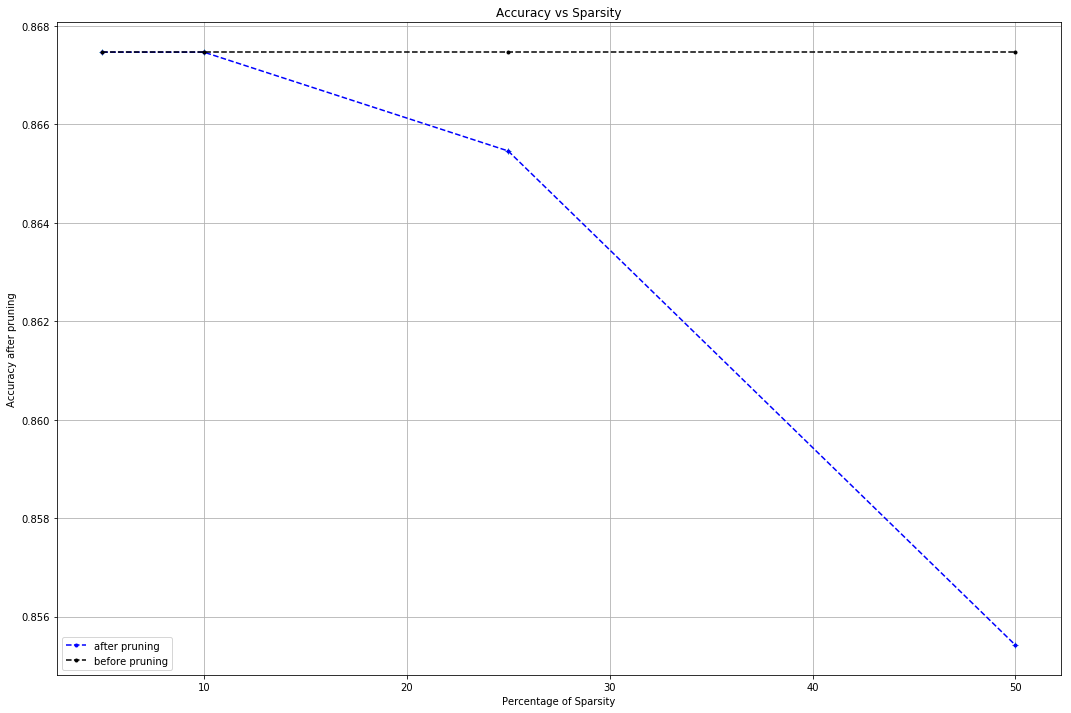

In [128]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_UB3
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Unified_Approach_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Unified_Approach_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Unified_Approach_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Unified_Approach_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

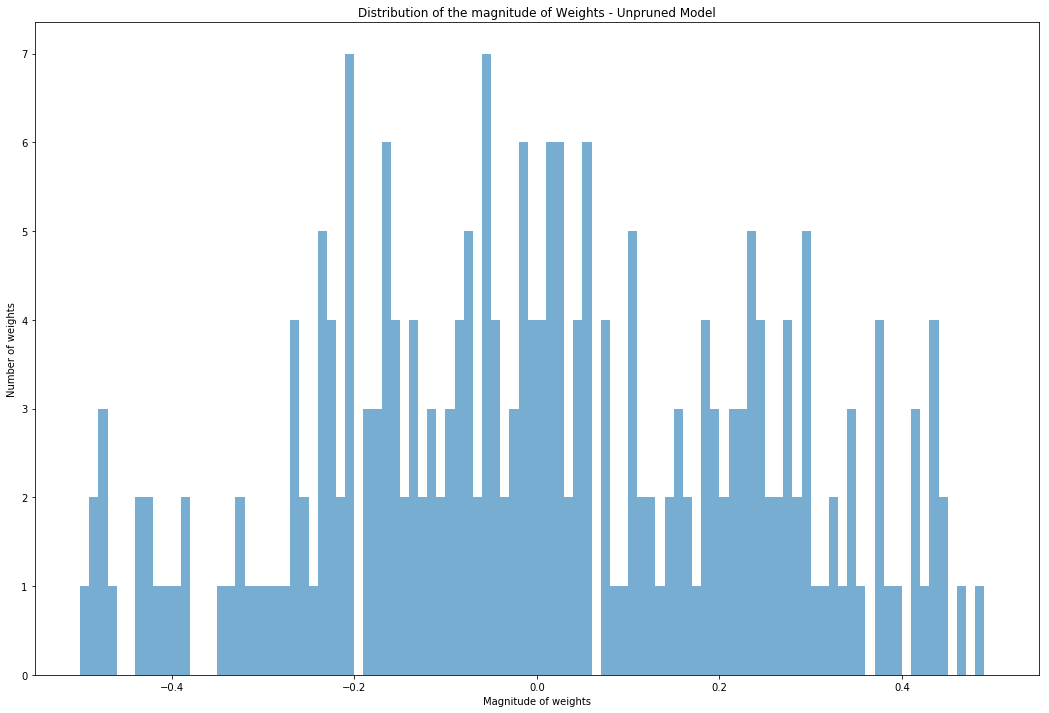

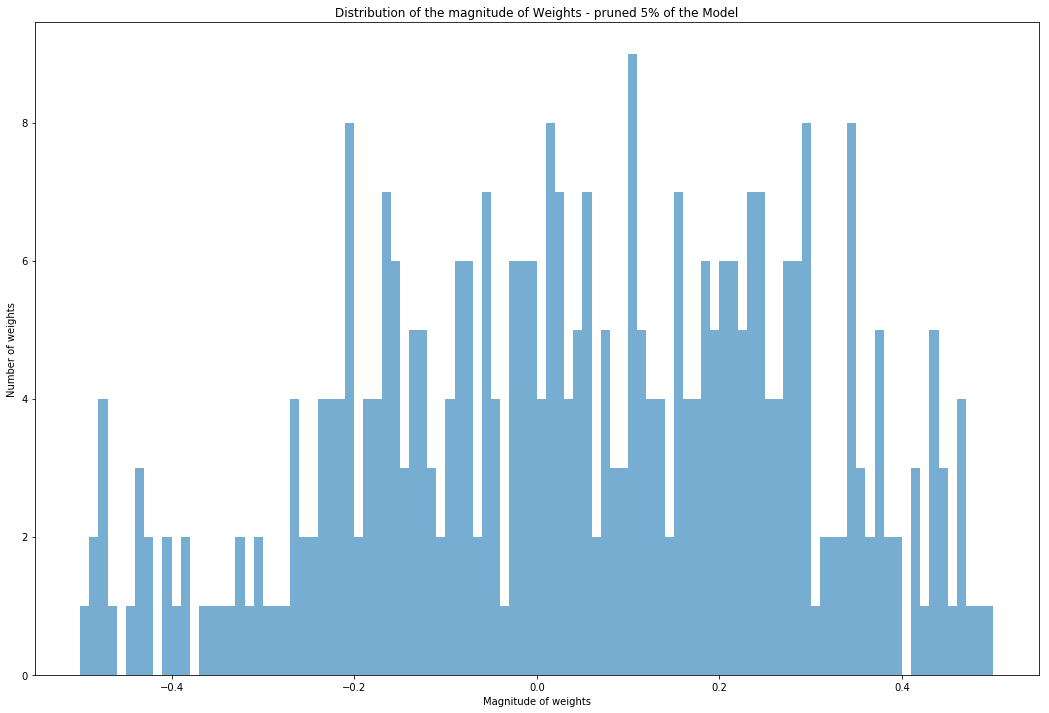

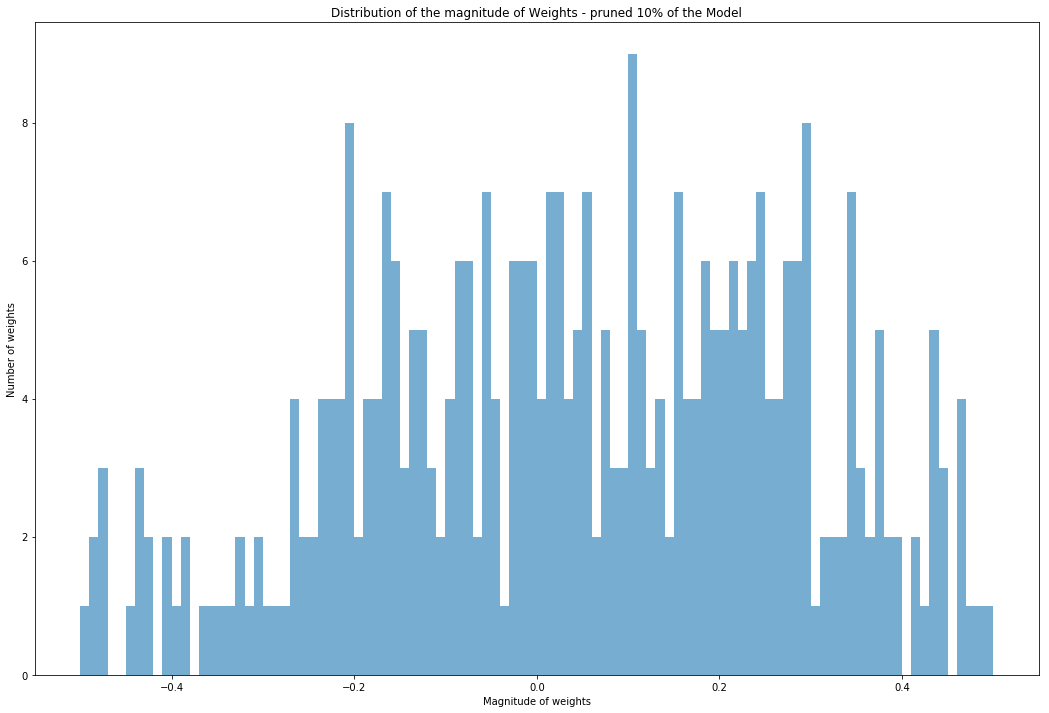

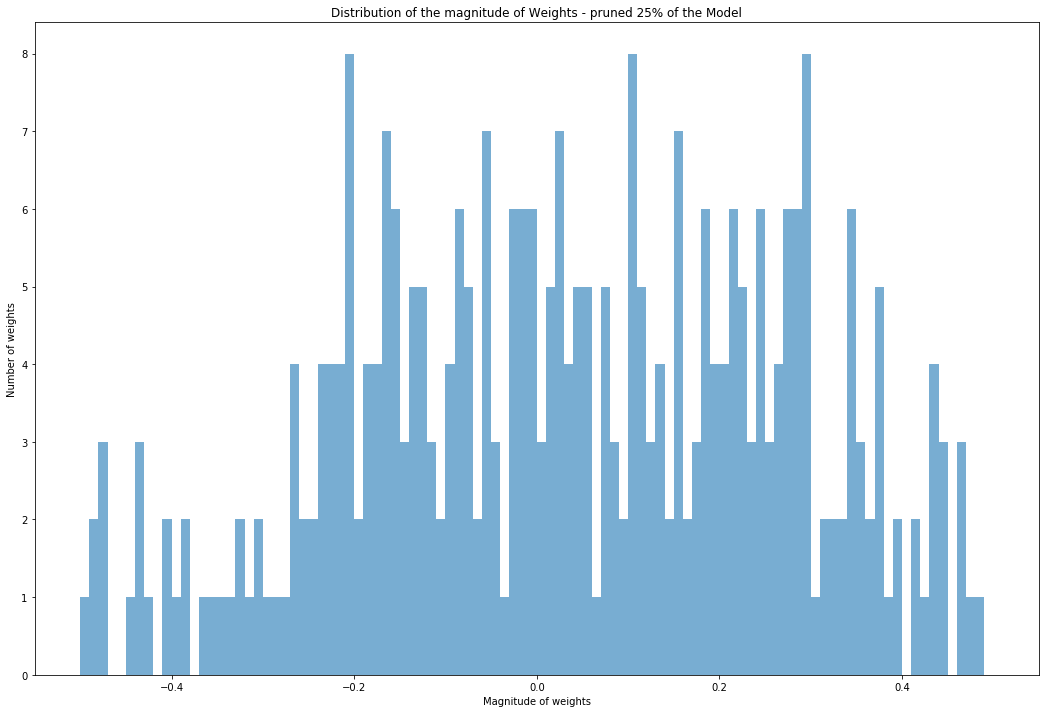

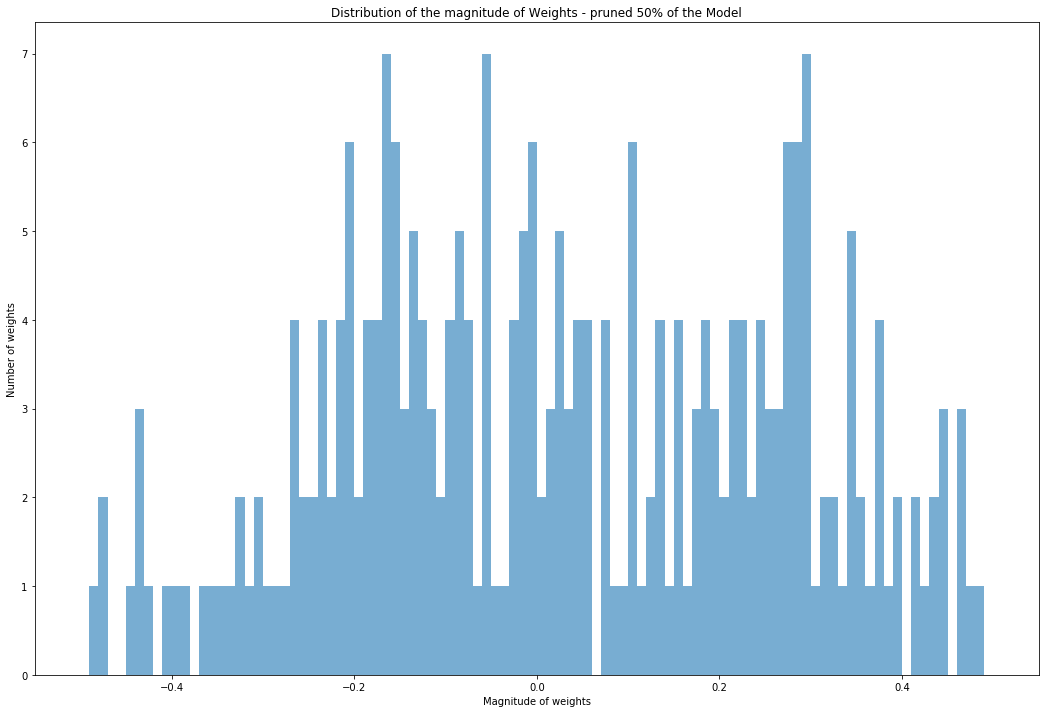

In [129]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('Unified_Approach_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('Unified_Approach_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('Unified_Approach_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('Unified_Approach_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8132530120481928
The accuracy of the model after pruned 10 on testing data =  0.8162650602409639
The accuracy of the model after pruned 25 on testing data =  0.8192771084337349
The accuracy of the model after pruned 50 on testing data =  0.8042168674698795


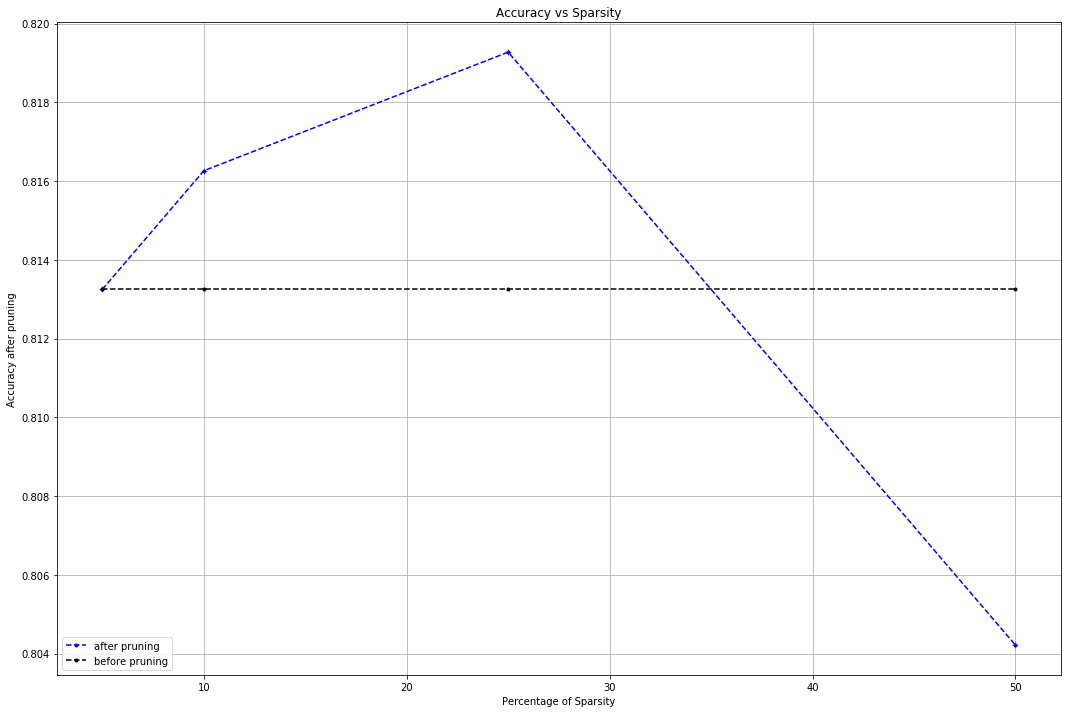

In [130]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('Unified_Approach_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('Unified_Approach_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('Unified_Approach_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('Unified_Approach_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

# Softmax

## Pruning the Weights

In [131]:
modelBuckup = load_model('my_model.h5')
startSM = time.time()
N_arry = np.zeros(N1*N2)
#noExamples = 100
NL = np.zeros(Round)
SM = np.zeros(Round)
Avg_Accumaltive_R_SM= np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_R_SM.reshape(N1,N2)
Count_SM = np.ones(N1*N2)
import random
tau=4
count = 0
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_R_SM[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)

            
            prob = np.exp(Avg_Accumaltive_R_SM/tau)
            sum = prob.sum()
            prb = prob/sum
            ind = np.random.choice(numpy.arange(0, N1*N2), p=prb.reshape(N1*N2))
            i,k = np.unravel_index(ind, p_reshape.shape)
            
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            Count_SM[ind]=Count_SM[ind]+1
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            #print(reward)
            val = Count_SM[ind]
            Avg_Accumaltive_R_SM[ind] = (val-1)/val * Avg_Accumaltive_R_SM[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            SM[j]=ind
endSM = time.time()
print("Execution time ",endSM - startSM)

Execution time  51.47624397277832


## The single weight that has been chosen by Softmax method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [132]:
reshapeSM = Avg_Accumaltive_R_SM.reshape(N1,N2)
G = np.argmax(Avg_Accumaltive_R_SM)
Gi,Gj = np.unravel_index(G, reshapeSM.shape)
print("The index of chosen  W_ji is = ", Gj, Gi)

The index of chosen  W_ji is =  15 15


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8634538152610441
Accuract after prune 10% is  0.8634538152610441
Accuract after prune 25% is  0.8654618473895582
Accuract after prune 50% is  0.8554216867469879


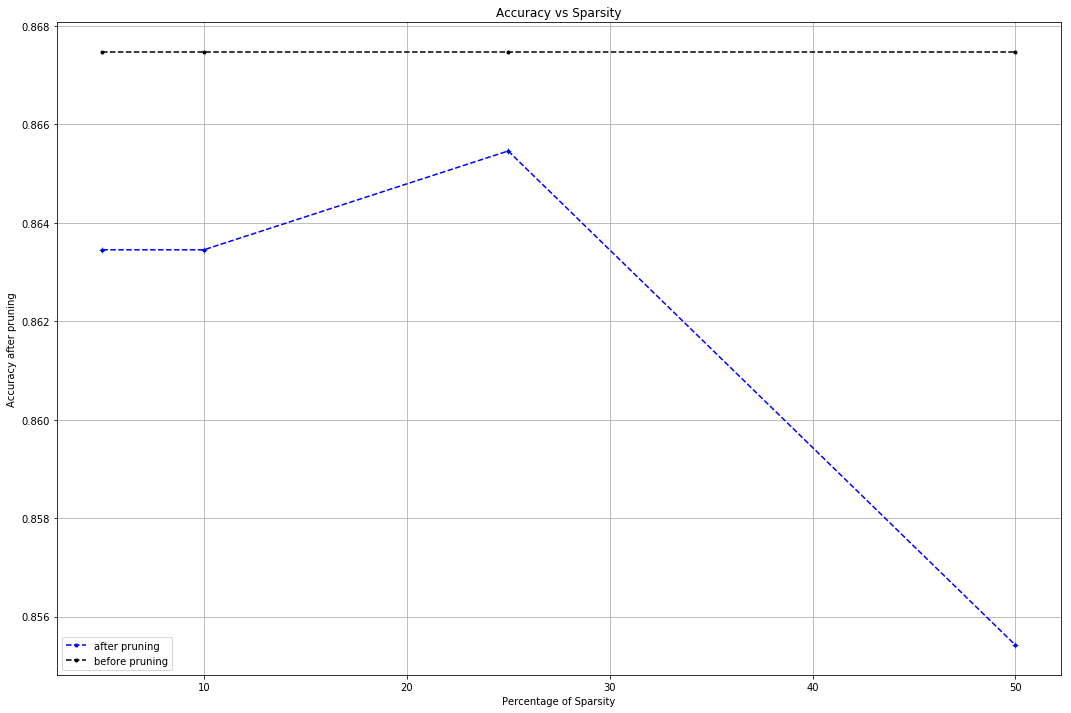

In [133]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_R_SM
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Softmax_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Softmax_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Softmax_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('Softmax_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

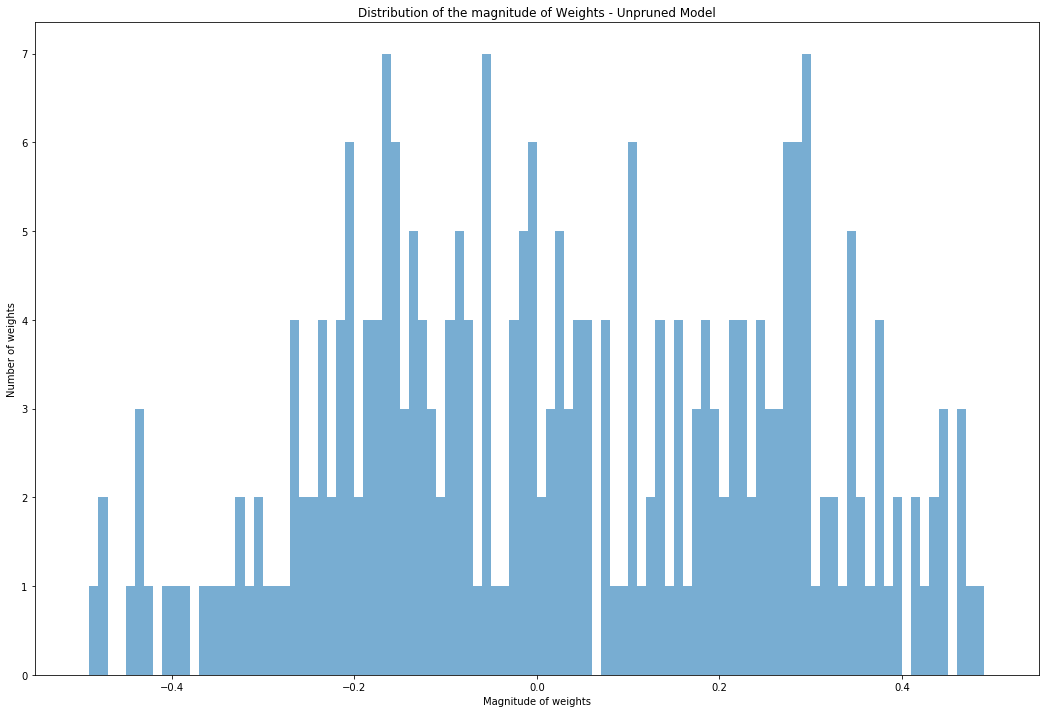

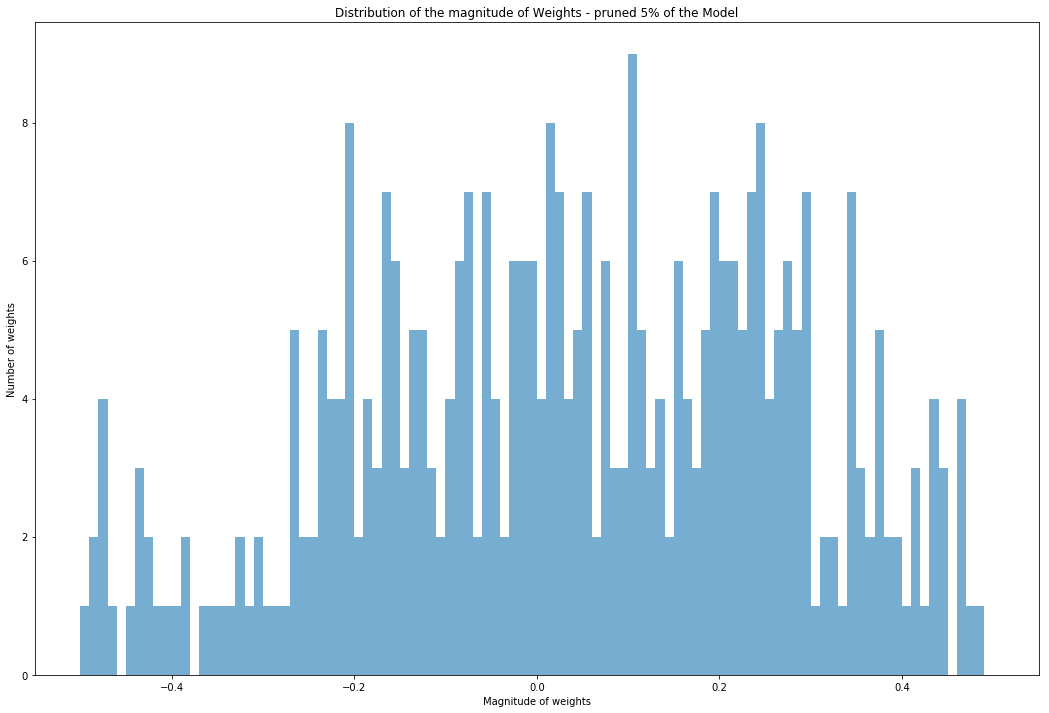

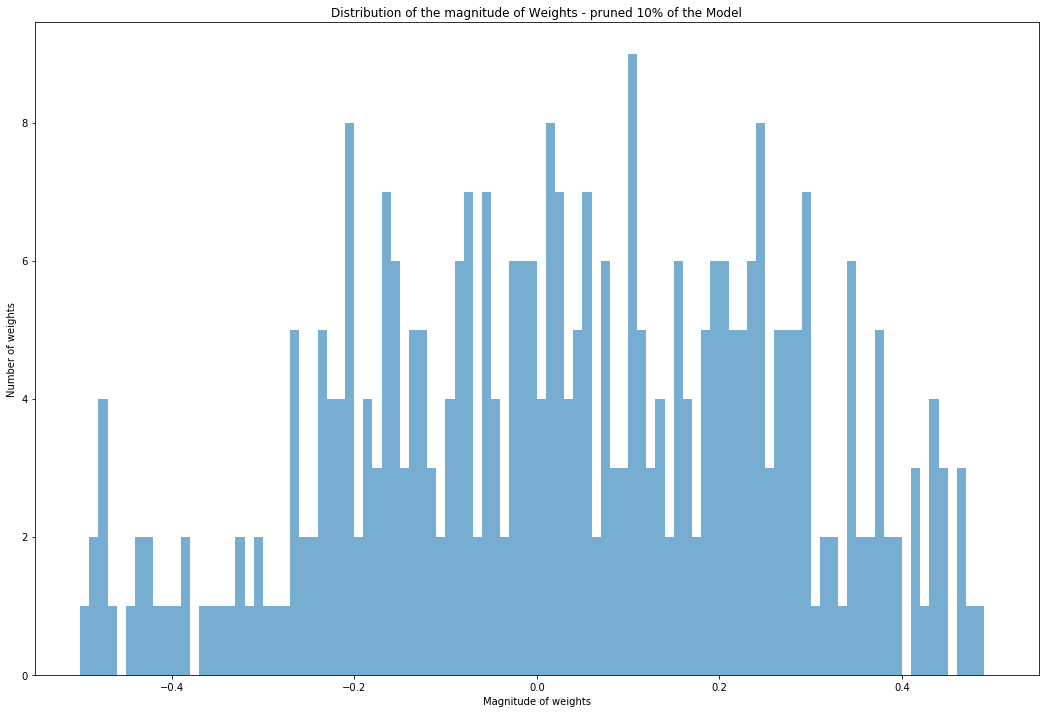

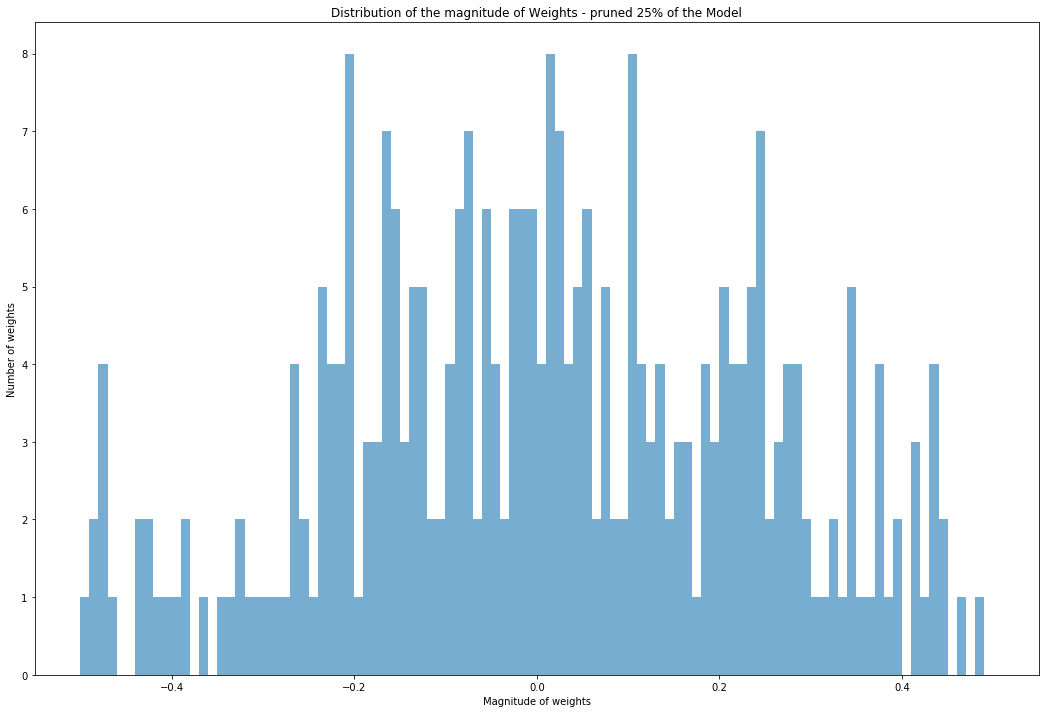

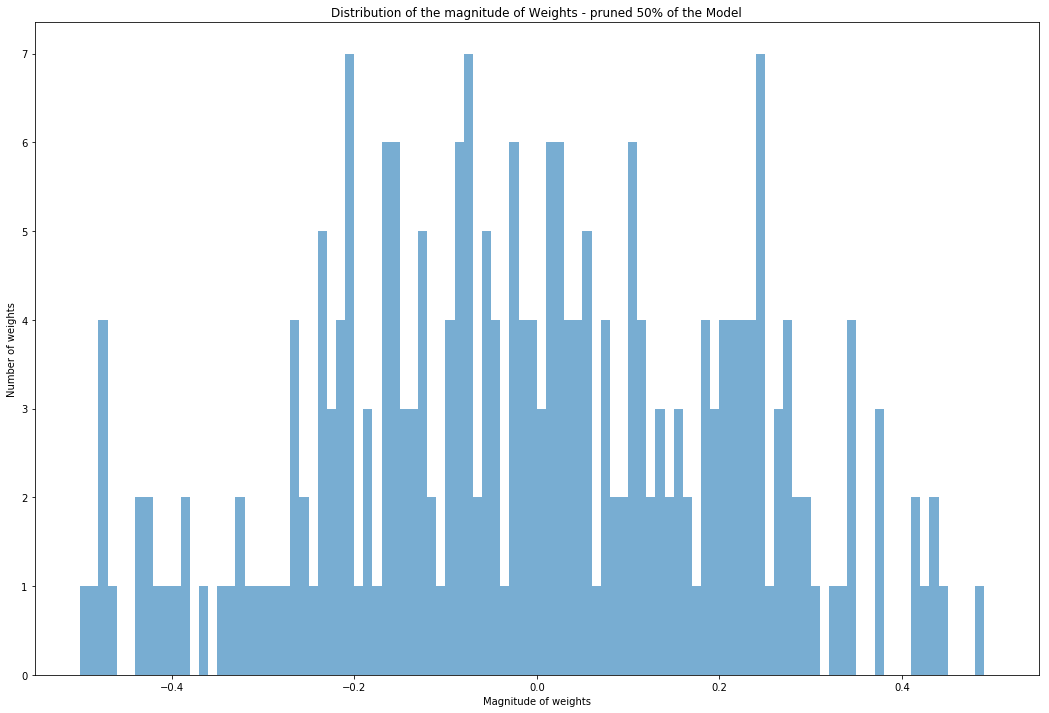

In [134]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('Softmax_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('Softmax_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('Softmax_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('Softmax_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

### On testing dataset (Unseen dataset)

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8192771084337349
The accuracy of the model after pruned 10 on testing data =  0.822289156626506
The accuracy of the model after pruned 25 on testing data =  0.8283132530120482
The accuracy of the model after pruned 50 on testing data =  0.8253012048192772


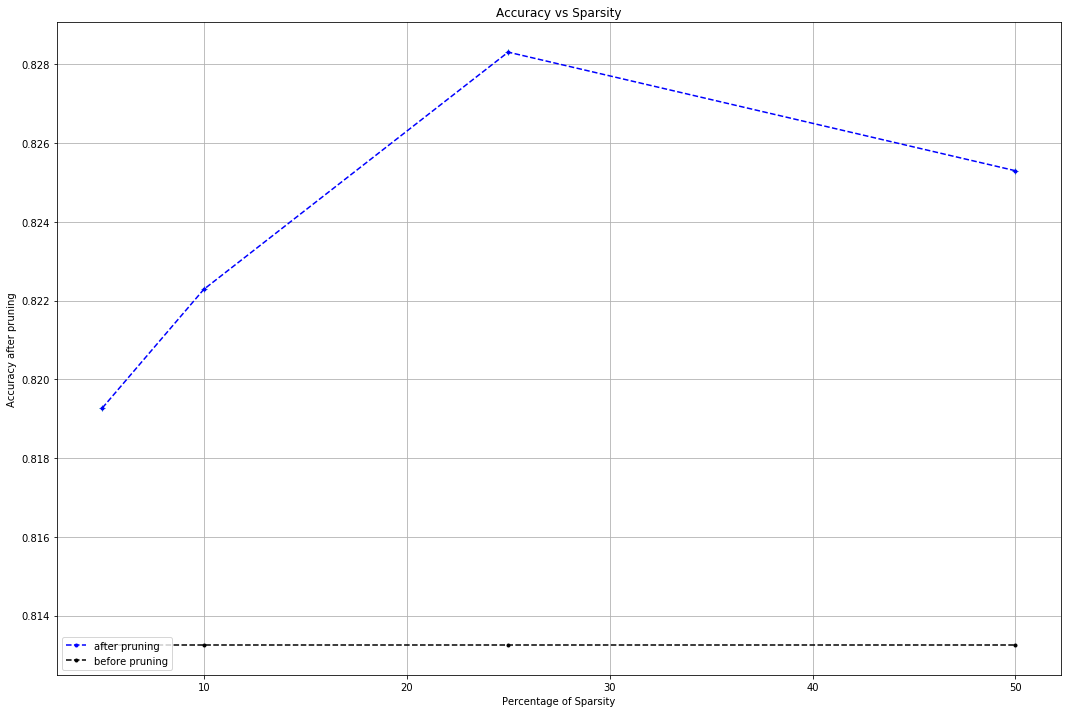

In [135]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('Softmax_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('Softmax_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('Softmax_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('Softmax_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

# Win–Stay, Lose–Shift (Pursuit method)

## Pruning the Weights

In [136]:
modelBuckup = load_model('my_model.h5')
startWSLS = time.time()
N_arry = np.zeros(N1*N2)
#noExamples = 100
NL = np.zeros(Round)
WSLS = np.zeros(Round)
Avg_Accumaltive_R_WSLS= np.zeros(N1*N2)

Probs = 1/(N1*N2) * np.ones(N1*N2)

p_reshape = Avg_Accumaltive_R_WSLS.reshape(N1,N2)
Count_WSLS = np.ones(N1*N2)
import random
beta = 0.3
count = 0
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            if reward>0:
                Probs[count] = Probs[count] + beta * (1-Probs[count])
            else:
                Probs[count] = Probs[count] - beta * Probs[count]
            All_weights[2][i][j]= temp
            Avg_Accumaltive_R_WSLS[count] = reward
            
            
            modelBuckup.set_weights(All_weights)
            
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)      
            
            
            ind = np.argmax(Probs)
            Count_WSLS[ind] = Count_WSLS[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            
            
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            if reward>0:
                Probs[ind] = Probs[ind] + beta * (1-Probs[ind])
            else:
                Probs[ind] = Probs[ind] - beta * Probs[ind] 
            count = count+1
            #print(reward)
            val = Count_WSLS[ind]
            Avg_Accumaltive_R_WSLS[ind] = (val-1)/val * Avg_Accumaltive_R_WSLS[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            WSLS[j]=ind
endWSLS = time.time()
print("Execution time ",endWSLS - startWSLS)

Execution time  56.78947877883911


## The single weight that has been chosen by Epsilon Greedy method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [137]:
reshapeWSLS = Avg_Accumaltive_R_WSLS.reshape(N1,N2)
G = np.argmax(Avg_Accumaltive_R_WSLS)
Gi,Gj = np.unravel_index(G, reshapeWSLS.shape)
print("The index of chosen  W_ji is = ", Gj, Gi)

The index of chosen  W_ji is =  12 1


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8654618473895582
Accuract after prune 10% is  0.8654618473895582
Accuract after prune 25% is  0.8594377510040161
Accuract after prune 50% is  0.8594377510040161


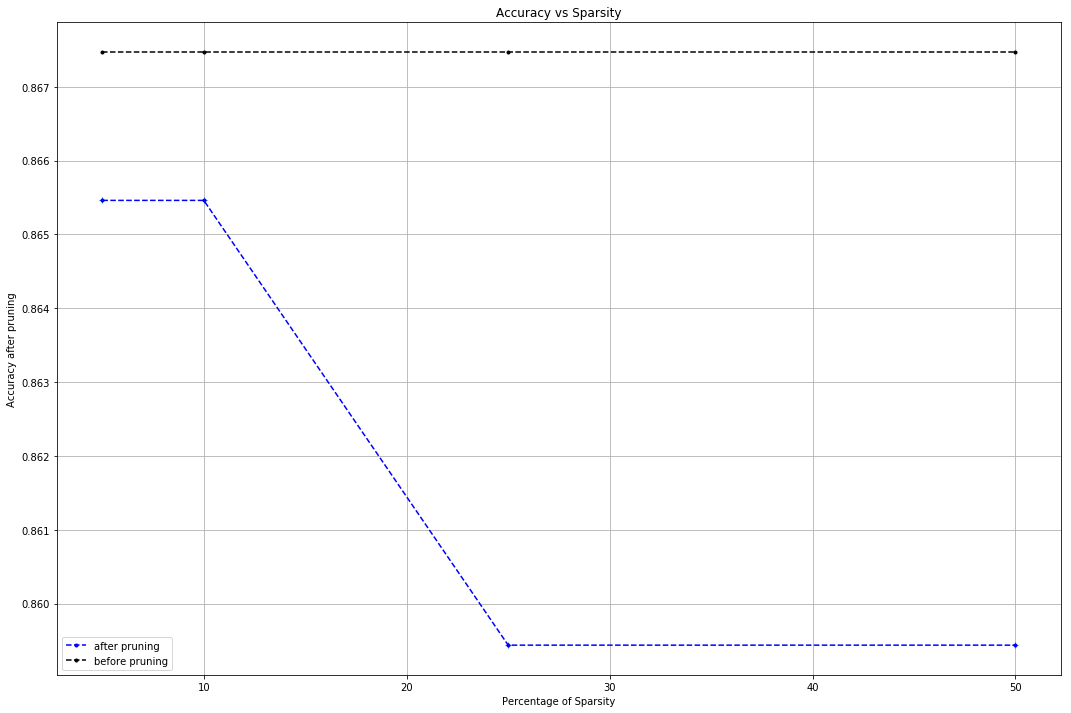

In [138]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_R_WSLS
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('WSLS_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('WSLS_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('WSLS_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('WSLS_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

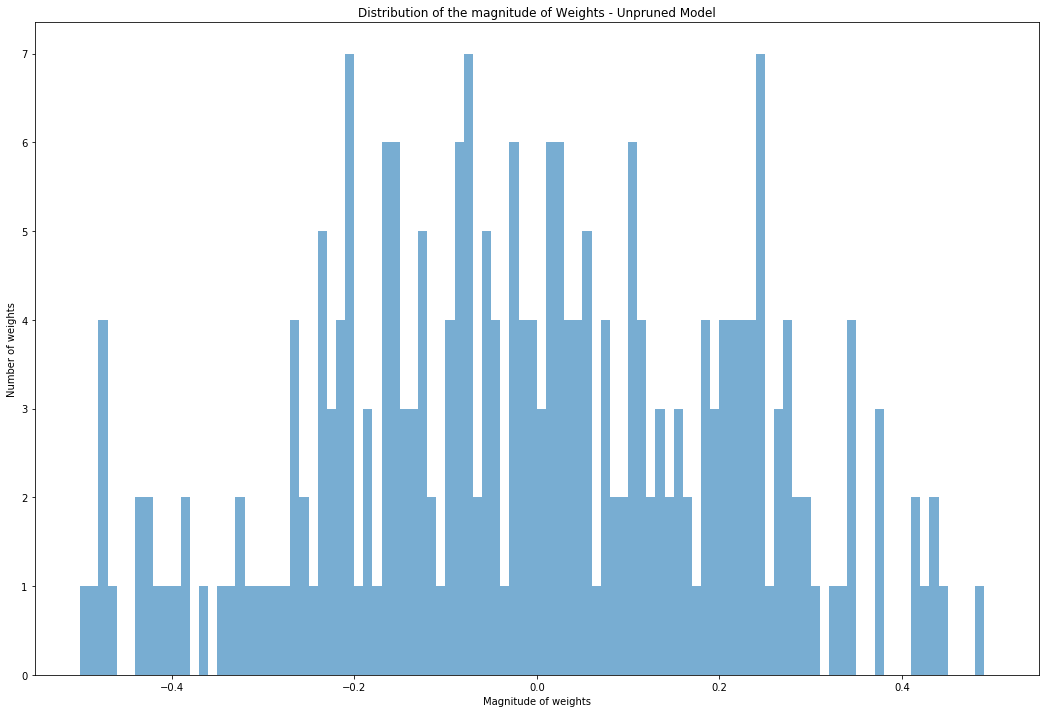

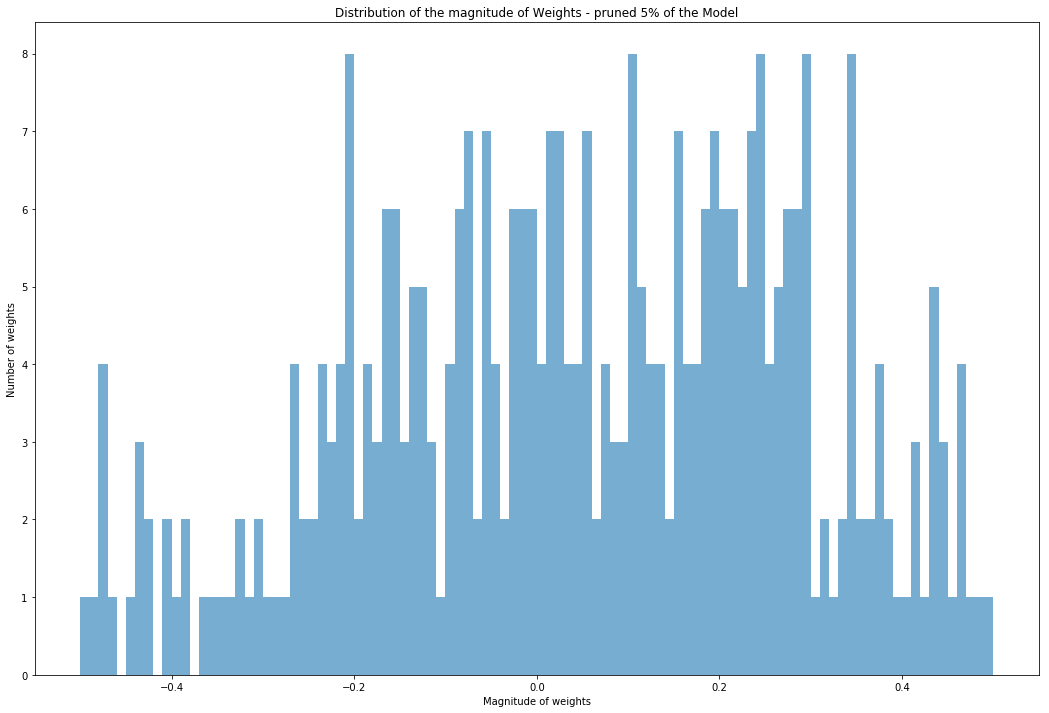

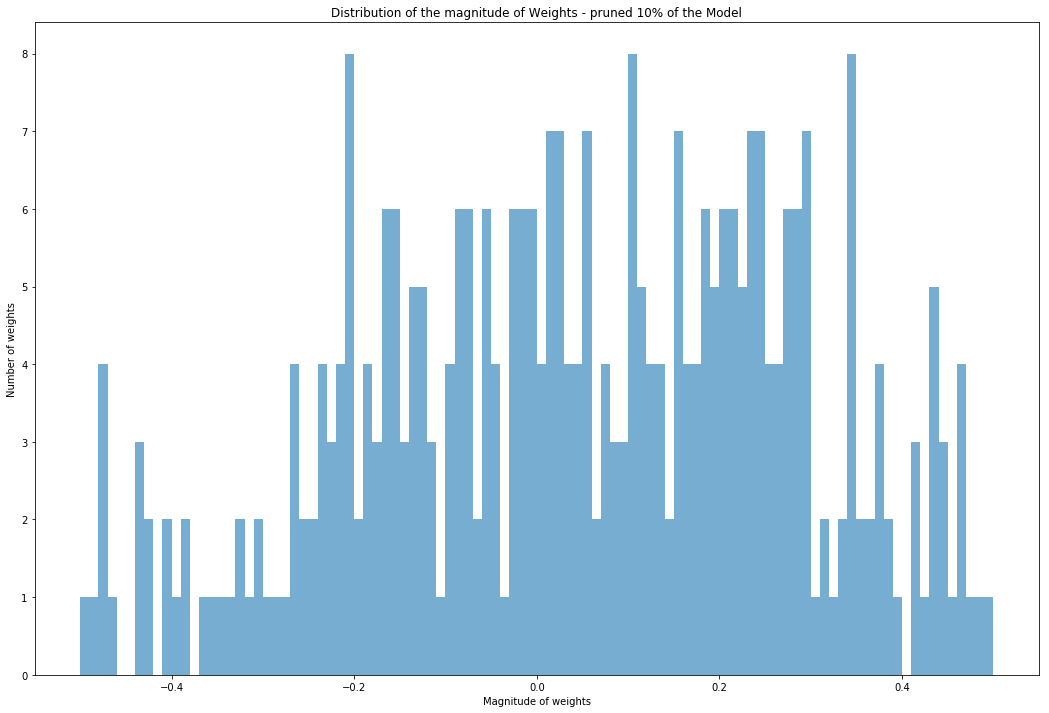

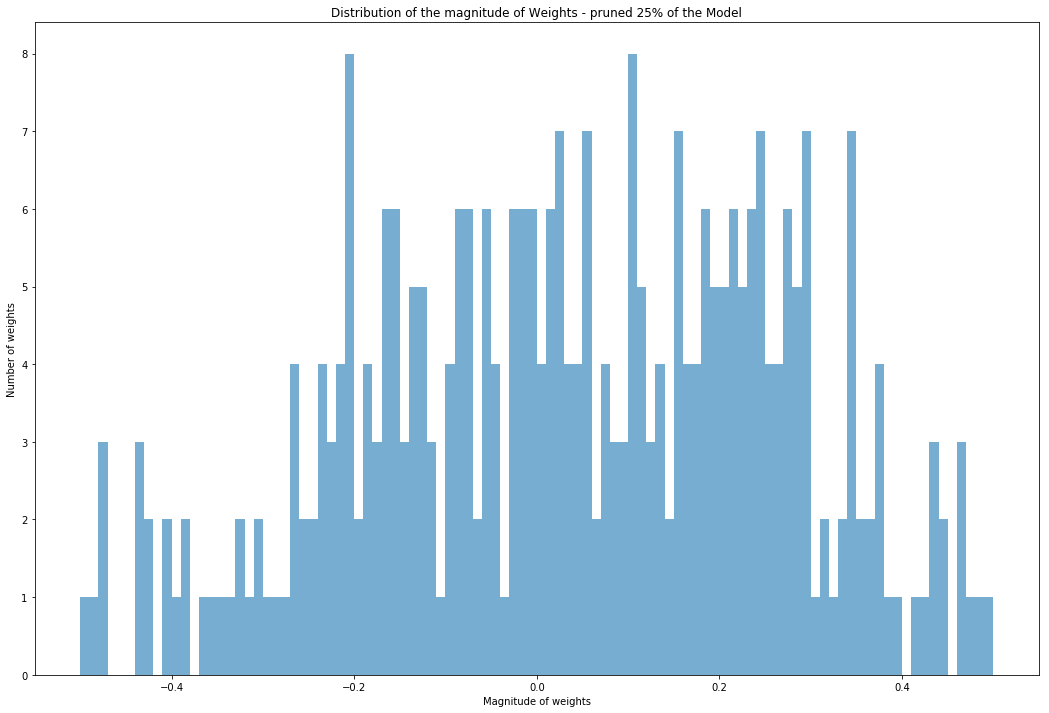

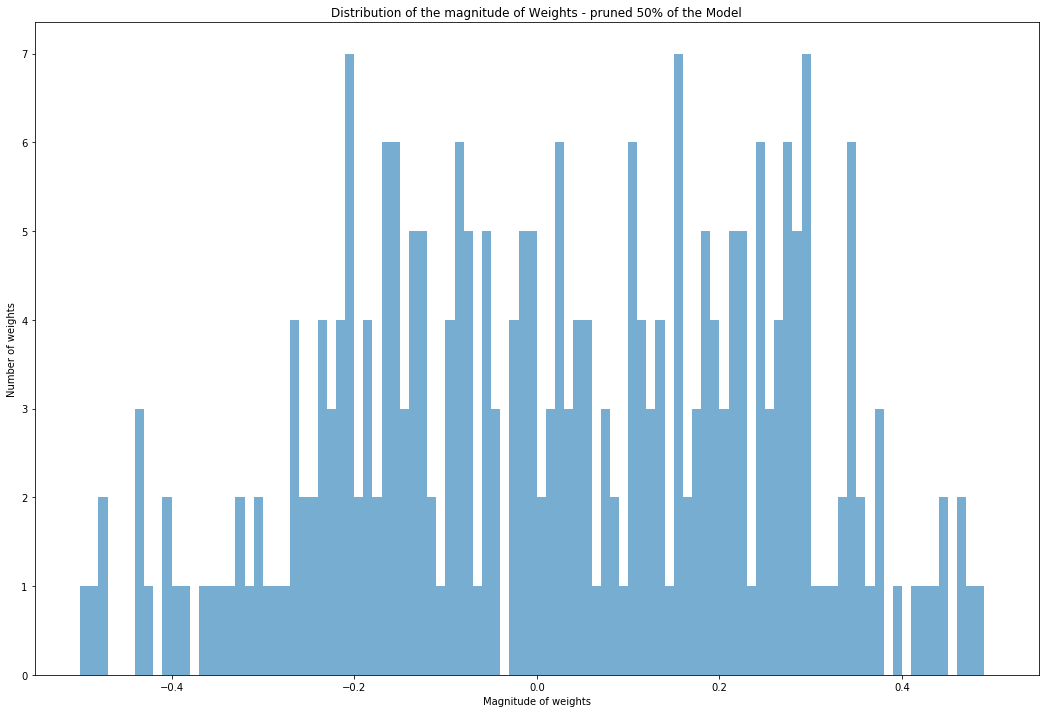

In [139]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('WSLS_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('WSLS_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('WSLS_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('WSLS_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

### On testing dataset (Unseen dataset)

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8132530120481928
The accuracy of the model after pruned 10 on testing data =  0.8132530120481928
The accuracy of the model after pruned 25 on testing data =  0.8192771084337349
The accuracy of the model after pruned 50 on testing data =  0.8102409638554217


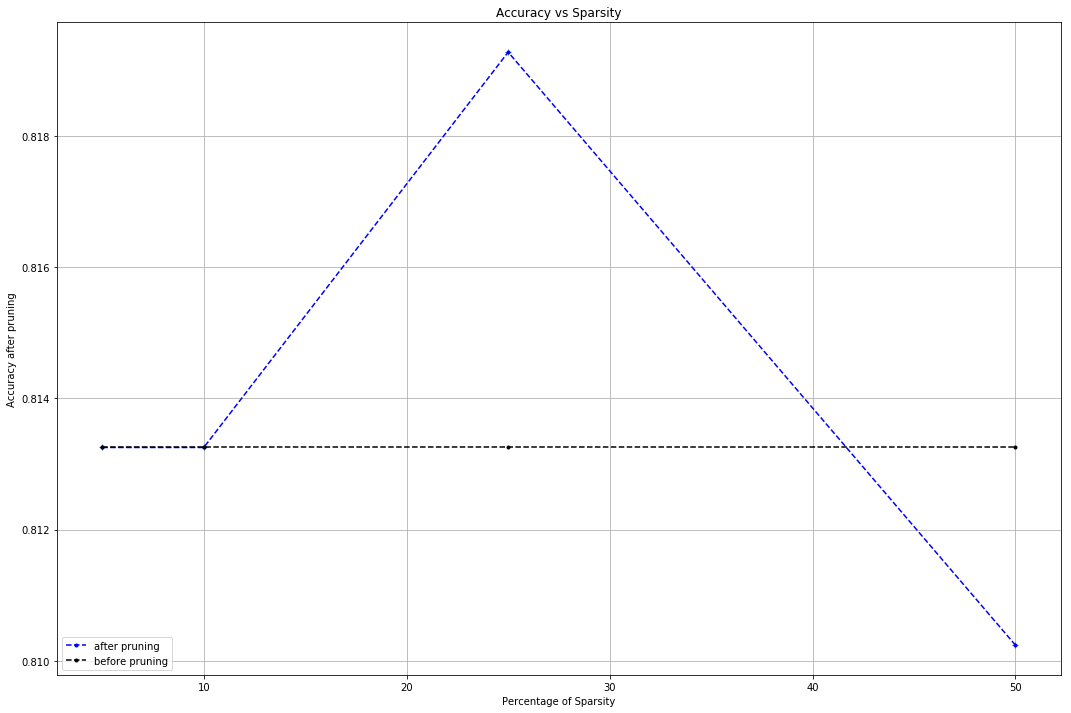

In [140]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('WSLS_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('WSLS_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('WSLS_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('WSLS_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

# KL-UCB

In [141]:
def klFunction(x, y, eps=1e-15):
    x = max(x, eps)
    y = max(y, eps)
    return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

In [142]:
modelBuckup = load_model('my_model.h5')
startklU = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_klUCB = np.zeros(N1*N2)
currentq = Avg_Accumaltive_klUCB + 0.000001
Count_klUCB = np.ones(N1*N2)
klUCB = np.zeros(Round)
p_reshape = Avg_Accumaltive_klUCB.reshape(N1,N2)
count = 0
import random
tau=4
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            if reward>0:
                currentq[count] = (currentq[count] + reward)/ reward
            All_weights[2][i][j]= temp
            Avg_Accumaltive_klUCB[count] = reward
            modelBuckup.set_weights(All_weights)
            
            count = count+1
            d=0
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            ind = np.argmax(currentq)
            Count_klUCB[ind] = Count_klUCB[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            try:
                normalized = (Avg_Accumaltive_klUCB - np.min(Avg_Accumaltive_klUCB)) / (np.max(Avg_Accumaltive_klUCB) - np.min(Avg_Accumaltive_klUCB))
            except:
                normalized = Avg_Accumaltive_klUCB  / np.max(Avg_Accumaltive_klUCB)
            q = normalized[ind]
            while (q < 1) and (d < np.log(j)/Count_klUCB[ind]):
                d = klFunction(normalized[ind], q)  # d(mu_i, q)
                q = q + 0.01
                currentq[ind]= q
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0           
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            val = Count_klUCB[ind]
            Avg_Accumaltive_klUCB[ind] = (val-1)/val * Avg_Accumaltive_klUCB[ind] + 1/val * reward
            modelBuckup.set_weights(All_weights)
            UCB1[j]=ind
endklU = time.time()
print("Execution time ",endklU - startklU)

Execution time  66.61751008033752


## The single weight that has been chosen by KL-UCB method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [143]:
reshapeklU = Avg_Accumaltive_klUCB.reshape(N1,N2)
klU = np.argmax(Avg_Accumaltive_klUCB)
Ui,Uj = np.unravel_index(klU, reshapeU.shape)
print("The index of chosen  W_ji is = ", Uj, Ui)

The index of chosen  W_ji is =  16 15


## Prune 5%, 10%, 25% and 50% from the unpruned model

Finsh playing start pruining:
Accuract after prune 5% is  0.8654618473895582
Accuract after prune 10% is  0.8634538152610441
Accuract after prune 25% is  0.8614457831325302
Accuract after prune 50% is  0.8554216867469879


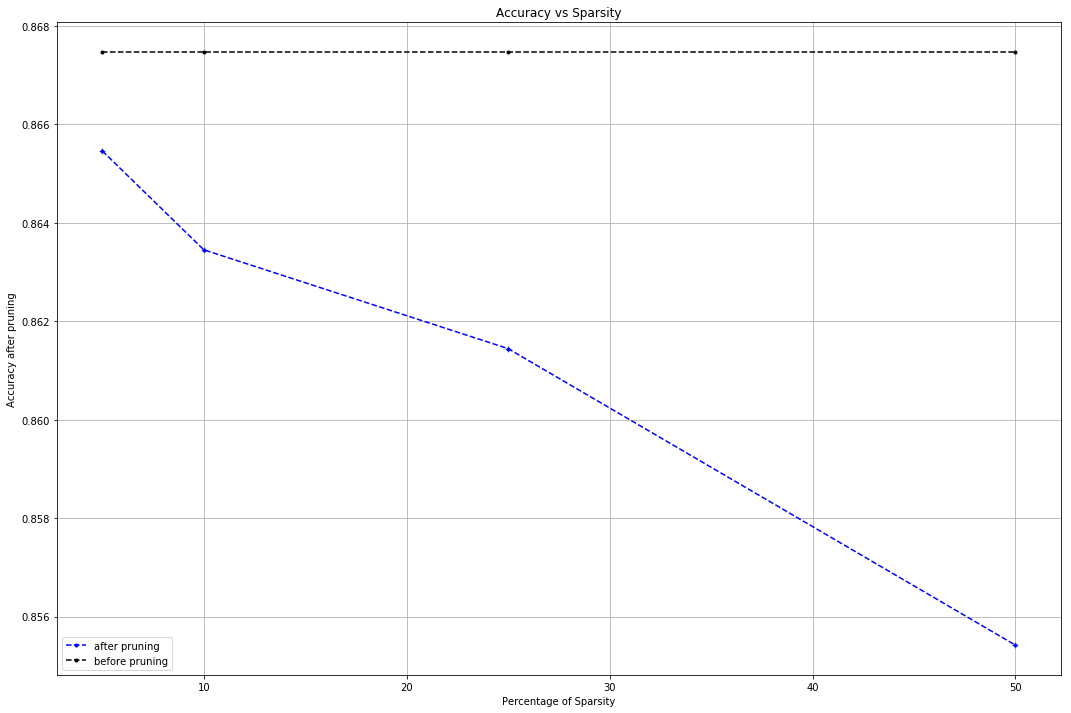

In [144]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_klUCB
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('kl_UCB_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('kl_UCB_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('kl_UCB_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('kl_UCB_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

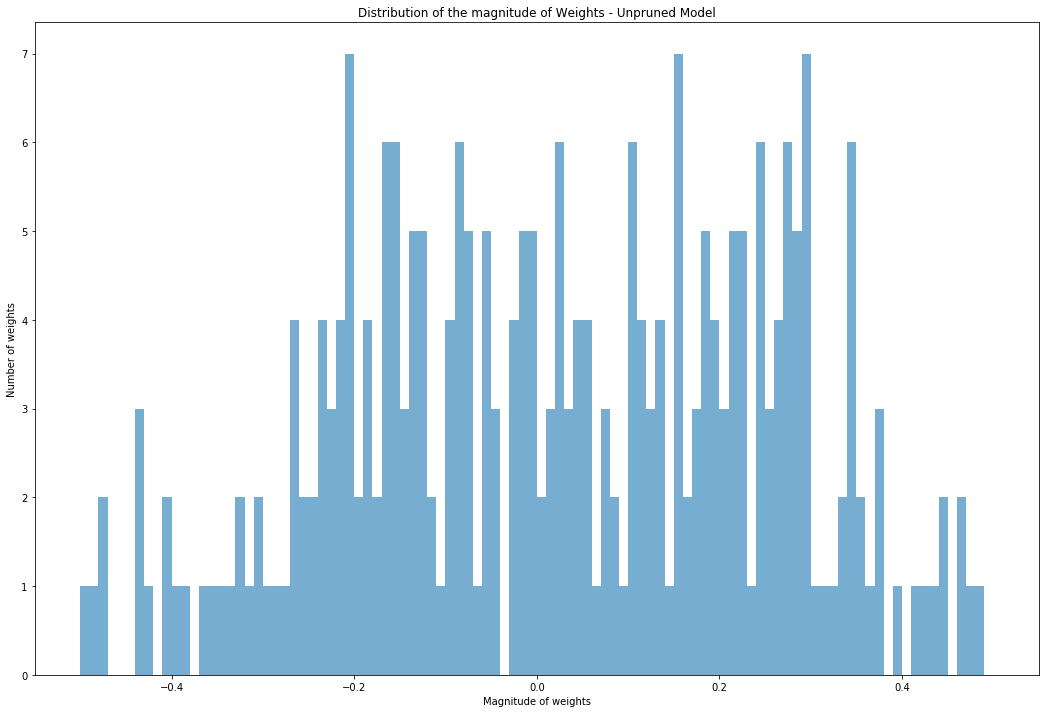

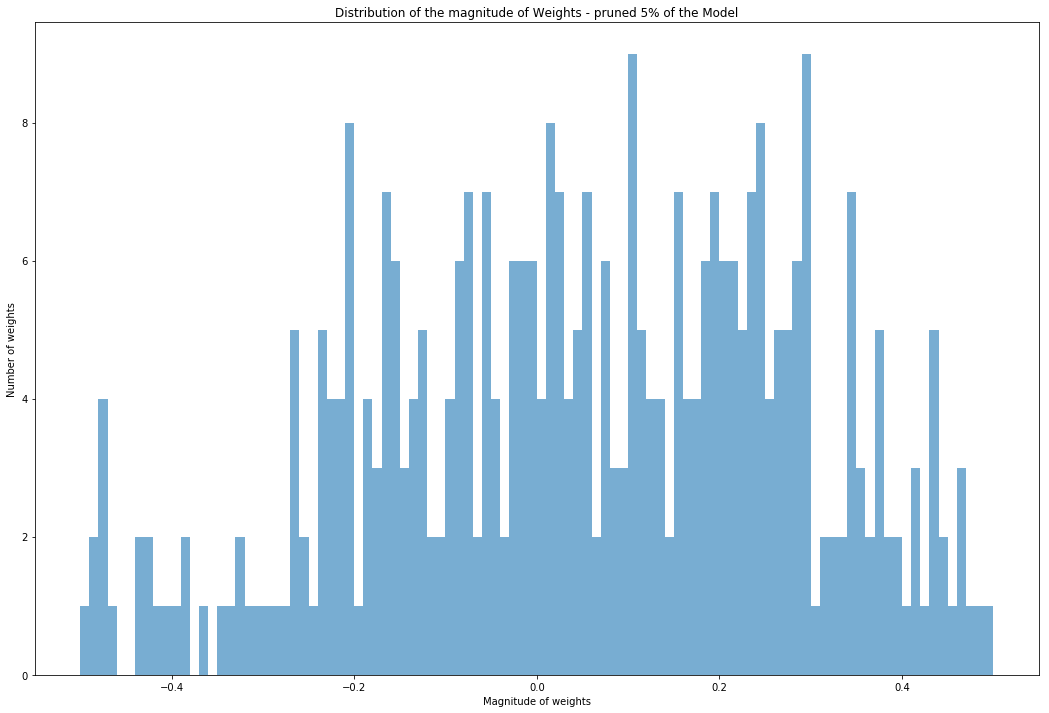

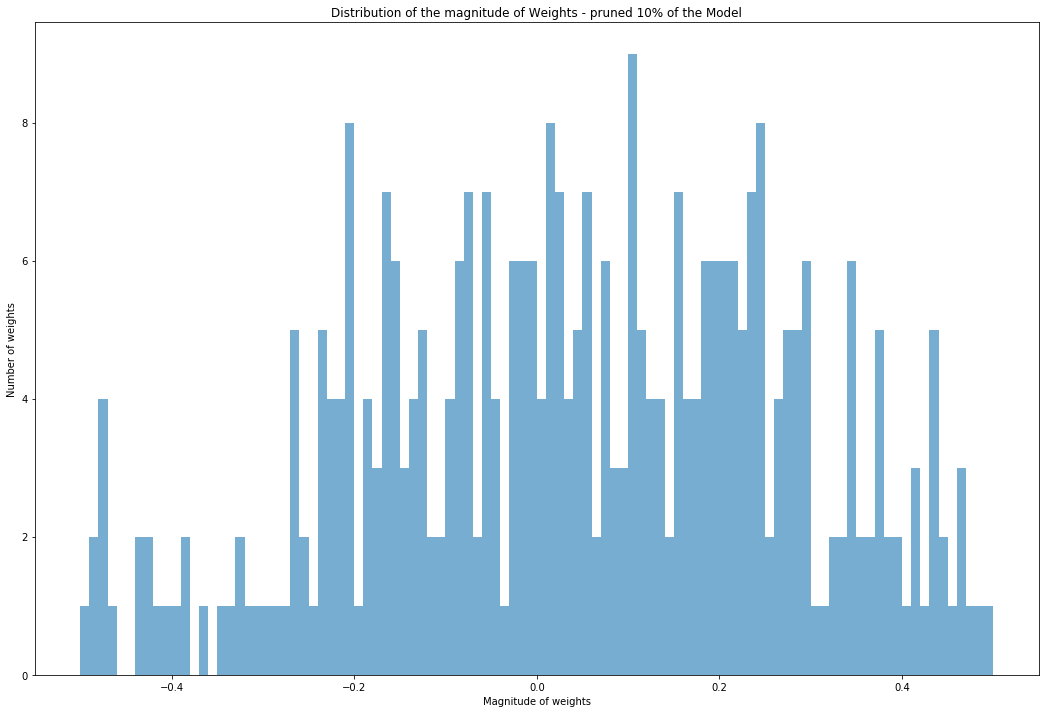

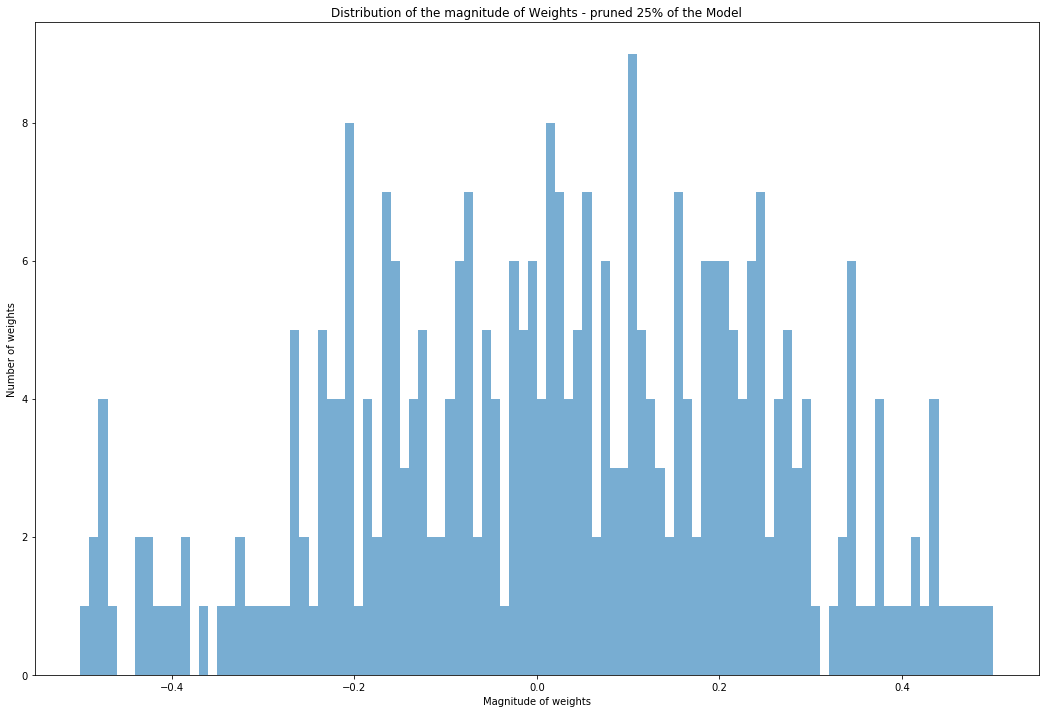

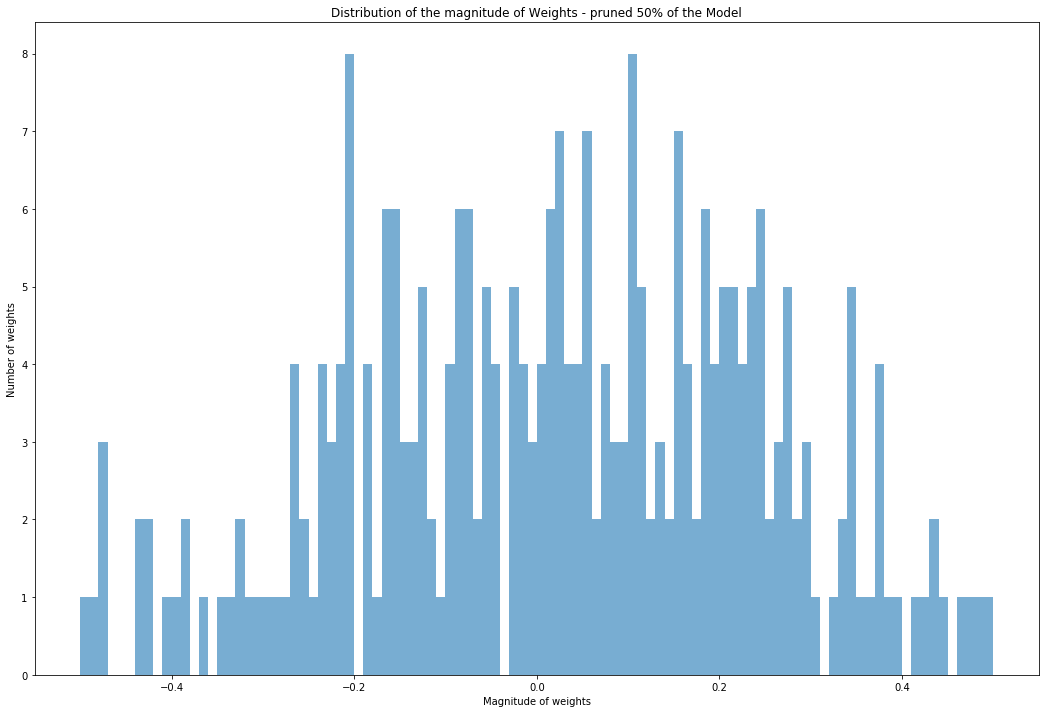

In [145]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('kl_UCB_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('kl_UCB_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('kl_UCB_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('kl_UCB_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8253012048192772
The accuracy of the model after pruned 10 on testing data =  0.8283132530120482
The accuracy of the model after pruned 25 on testing data =  0.8253012048192772
The accuracy of the model after pruned 50 on testing data =  0.8253012048192772


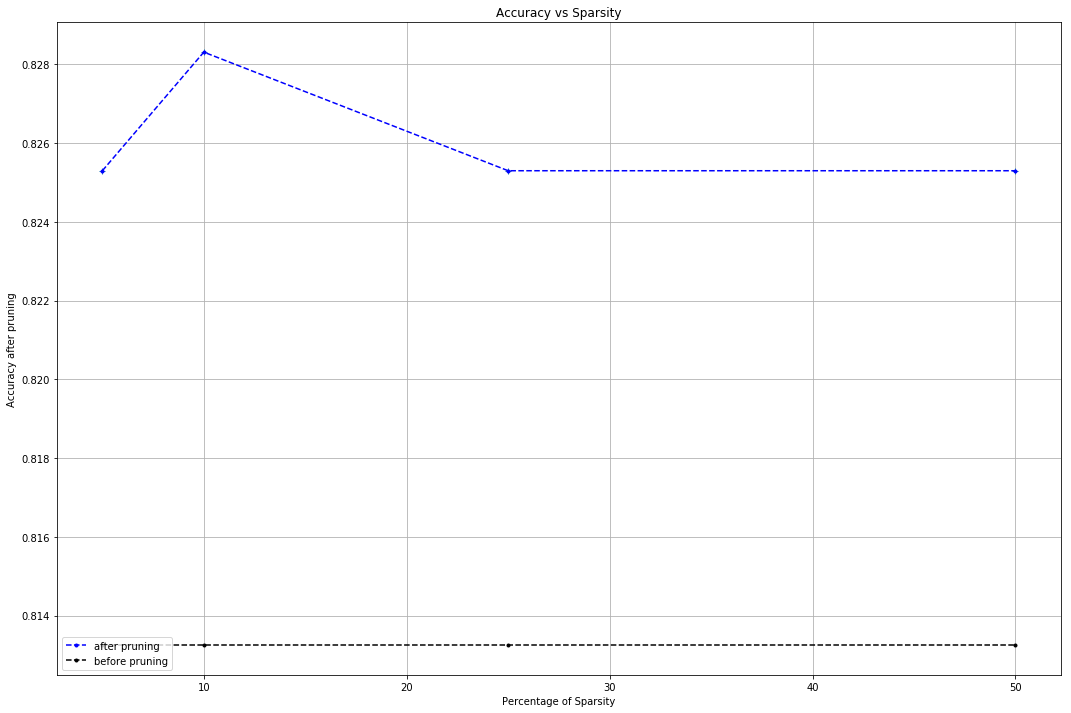

In [146]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('kl_UCB_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('kl_UCB_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('kl_UCB_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('kl_UCB_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.legend(loc = 3)
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.grid(True)
plt.show()

# Bayes UCB

## Pruning weights

In [147]:
from scipy.stats import beta
modelBuckup = load_model('my_model.h5')
startbayucb = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(Round)
Avg_Accumaltive_bayucb = np.zeros(N1*N2)
Count_bayucb = np.ones(N1*N2)
bayucb = np.zeros(Round)
p_reshape = Avg_Accumaltive_bayucb.reshape(N1,N2)
count = 0
success = np.zeros(N1*N2)
failure = np.zeros(N1*N2)
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1                        
            All_weights[2][i][j]= temp
            Avg_Accumaltive_bayucb[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1*N2-1, Round):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            
            ind = np.argmax(beta.pdf(1-1/Count_bayucb, 1+success, 1+failure))
        
            Count_bayucb[ind] = Count_bayucb[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0                     
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1            
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)          
            val = Count_bayucb[ind]
            Avg_Accumaltive_bayucb[ind] = (val-1)/val * Avg_Accumaltive_bayucb[ind] + 1/val * reward
            TS[j]=ind
endbayucb = time.time()
print("Execution time ",endbayucb - startbayucb)

Execution time  74.0239679813385


## The single weight that has been chosen by Bayes UCB method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [148]:
reshapebayucb = Avg_Accumaltive_bayucb.reshape(N1,N2)
bayucb = np.argmax(Avg_Accumaltive_bayucb)
Ti,Tj = np.unravel_index(bayucb, reshapebayucb.shape)
print("The index of chosen  W_ji is = ", Tj, Ti)

The index of chosen  W_ji is =  0 0


## Prune 5%, 10%, 25% and 50% from the unpruned model


Finsh playing start pruining:
Accuract after prune 5% is  0.8674698795180723
Accuract after prune 10% is  0.8634538152610441
Accuract after prune 25% is  0.8634538152610441
Accuract after prune 50% is  0.8554216867469879


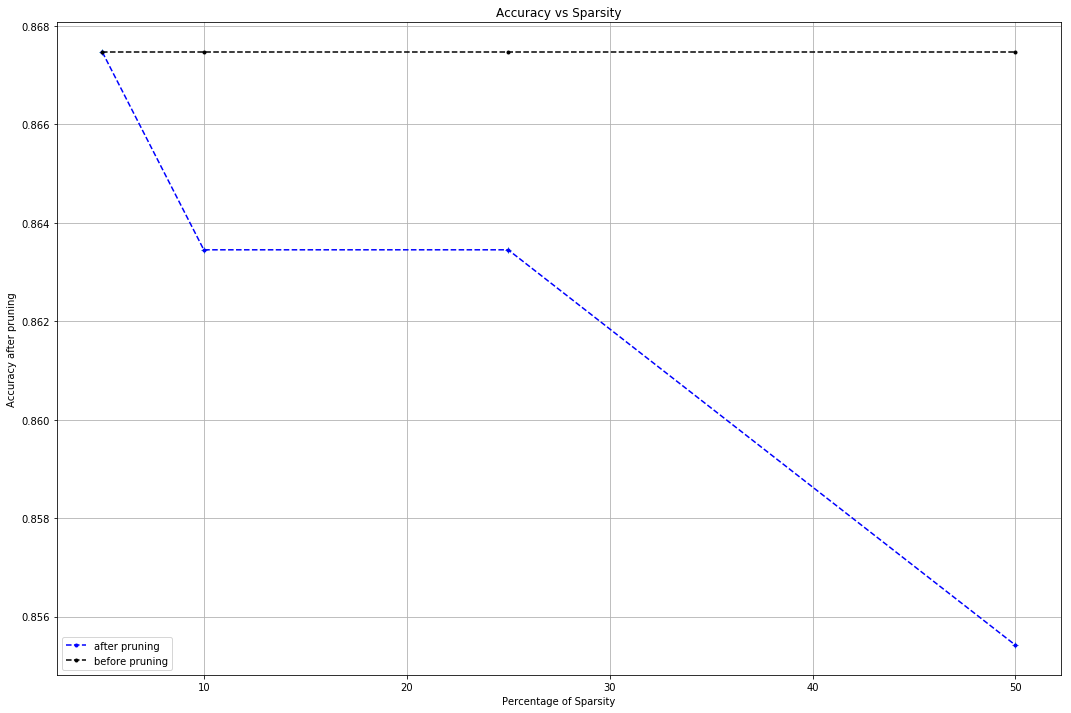

In [149]:
print('Finsh playing start pruining:')
rewards = Avg_Accumaltive_bayucb
Pecent = {1:'5%', 2:'10%', 3:'25%', 4:'50%'}
ListPecent = [0.05, 0.1, 0.25, 0.5]
No_ofweights = len(weights_unpruned)
accuracyL = []

# Prune 5%
No_of_pruned_weight = int(ListPecent[0] * N1*N2)
for t in range(No_of_pruned_weight):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 5% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('bayucb_model_5_Pecernt.h5') 

# Prune 10%
No_of_pruned_weight_10 = int(ListPecent[1] * N1*N2)
for t in range(No_of_pruned_weight, No_of_pruned_weight_10):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 10% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('bayucb_model_10_Pecernt.h5') 

# Prune 25%
No_of_pruned_weight_25 = int(ListPecent[2] * N1*N2)
for t in range(No_of_pruned_weight_10, No_of_pruned_weight_25):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 25% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('bayucb_model_25_Pecernt.h5')


# Prune 50%
No_of_pruned_weight_50 = int(ListPecent[3] * N1*N2)
for t in range(No_of_pruned_weight_25, No_of_pruned_weight_50):
    x = np.argmax(rewards)
    i,k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    All_weights = modelBuckup.get_weights()
    All_weights[2][i][k] = 0
    modelBuckup.set_weights(All_weights)
loss, accuracy = modelBuckup.evaluate(X_train, labelsTrain, batch_size=1, verbose=2)
print("Accuract after prune 50% is ", accuracy)
accuracyL.append(accuracy)
modelBuckup.save('bayucb_model_50_Pecernt.h5') 
x= [5,10,25,50]
xx = [accuracy_training_Model, accuracy_training_Model, accuracy_training_Model, accuracy_training_Model]
plt.plot(x, accuracyL, '+')
plt.plot(x, accuracyL, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

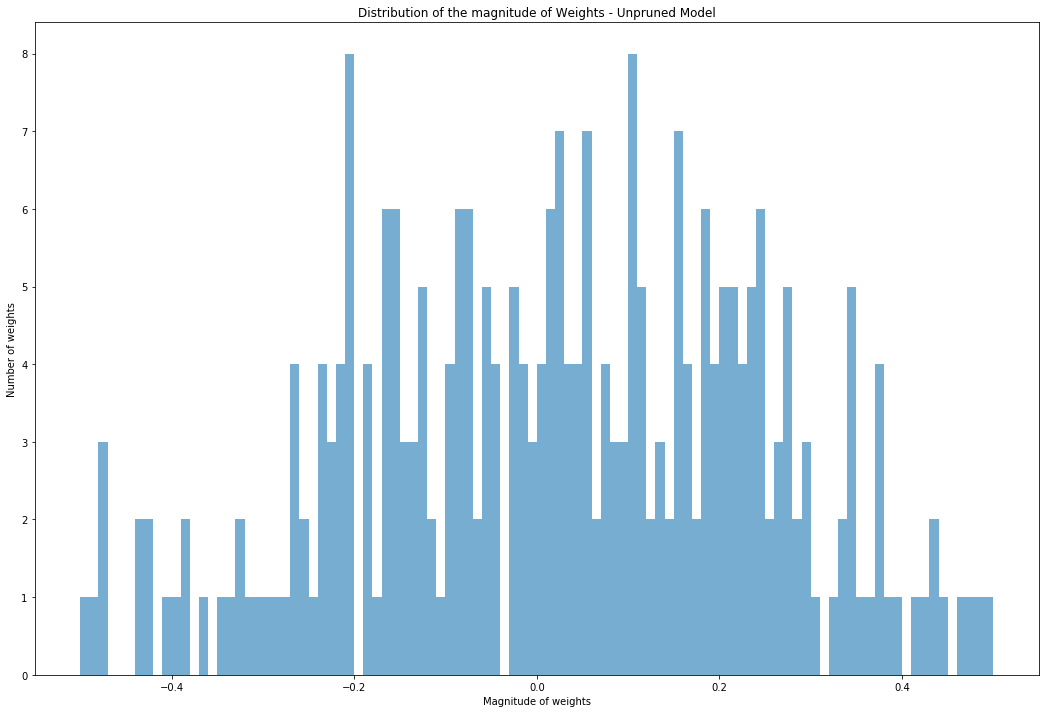

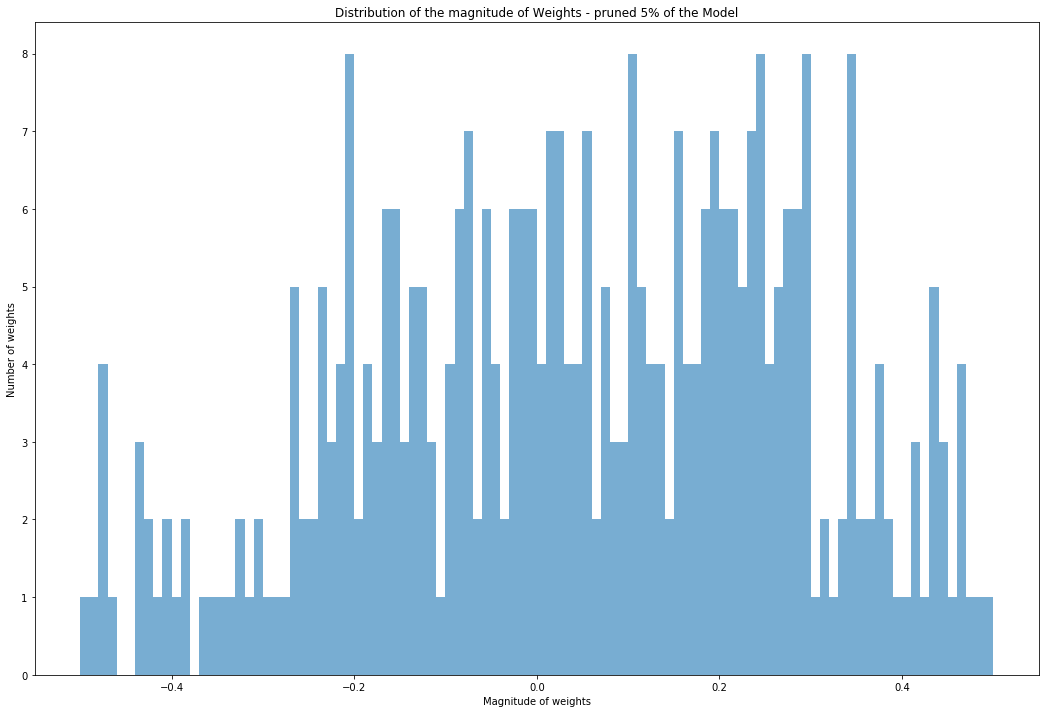

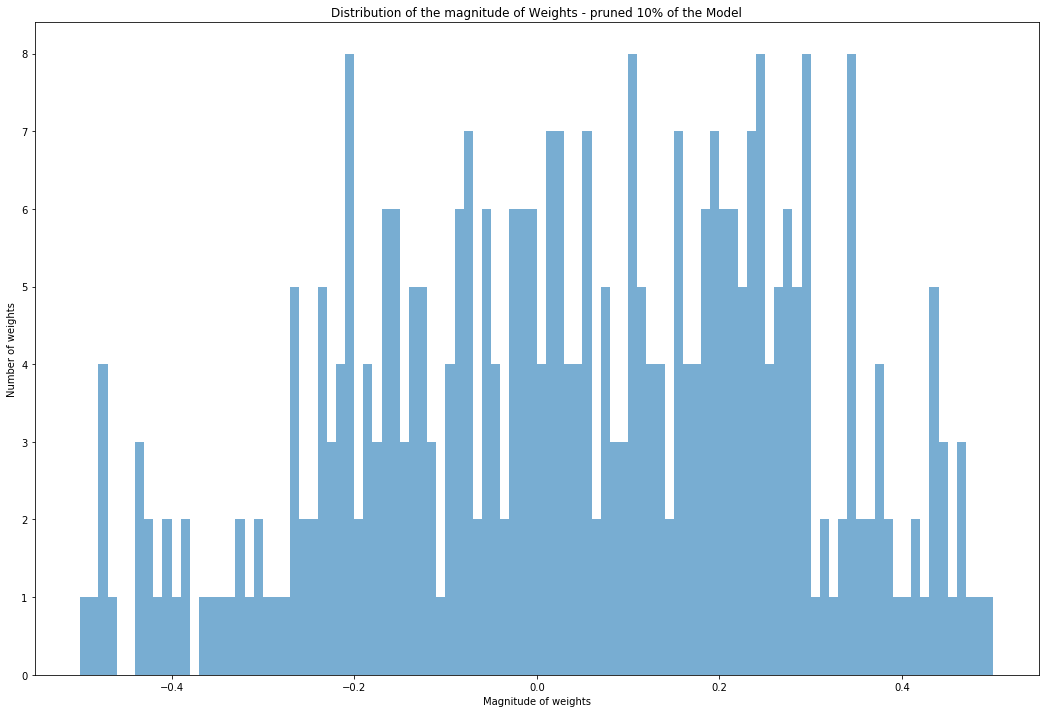

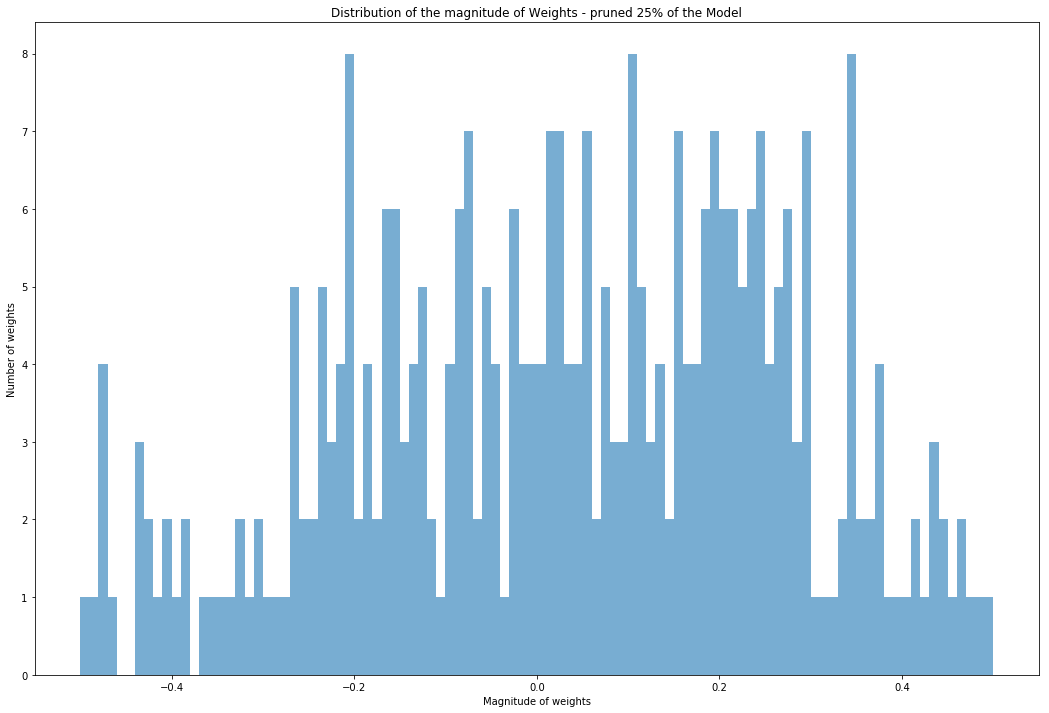

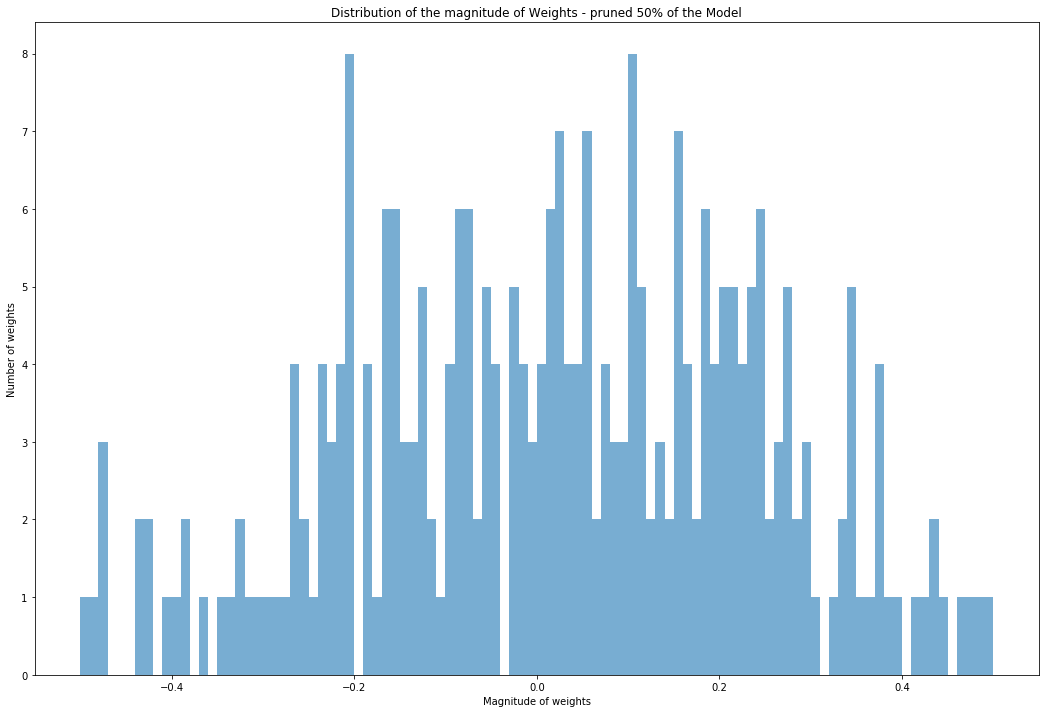

In [150]:
# distribution of the weights before pruning
weights_unpruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_unpruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

# distribution of the weights 5% pruning
model = load_model('bayucb_model_5_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 5% of the Model')
plt.show()

# distribution of the weights 10% pruning
model = load_model('bayucb_model_10_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')
plt.show()

# distribution of the weights 25% pruning
model = load_model('bayucb_model_25_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 25% of the Model')
plt.show()

# distribution of the weights 50% pruning
model = load_model('bayucb_model_50_Pecernt.h5')
weights = model.get_weights()
weights_pruned = []
for wei in weights:
    wei = wei[wei!=0]
    weights_pruned.extend(wei)
plt.figure()
n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 50% of the Model')
plt.show()

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5 on testing data =  0.8132530120481928
The accuracy of the model after pruned 10 on testing data =  0.8192771084337349
The accuracy of the model after pruned 25 on testing data =  0.8192771084337349
The accuracy of the model after pruned 50 on testing data =  0.8253012048192772


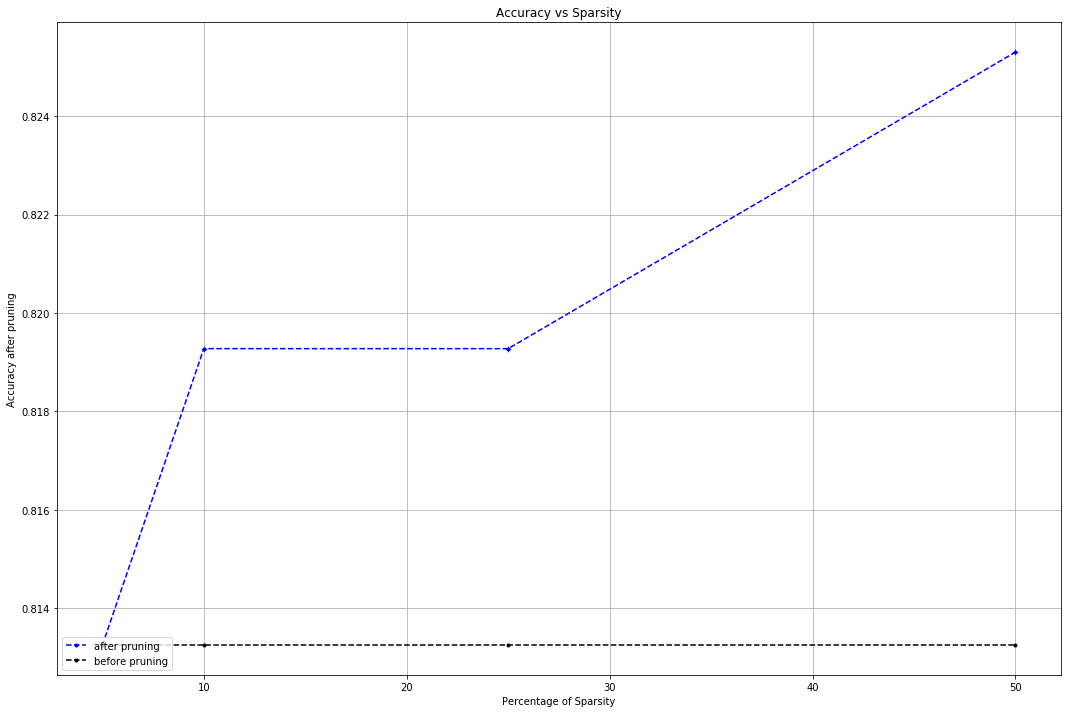

In [151]:
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)

model = load_model('bayucb_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5 on testing data = ", accuracy_testing_Model_05)

model = load_model('bayucb_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_10 = accuracy
print("The accuracy of the model after pruned 10 on testing data = ", accuracy_testing_Model_10)

model = load_model('bayucb_model_25_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_25 = accuracy
print("The accuracy of the model after pruned 25 on testing data = ", accuracy_testing_Model_25)

model = load_model('bayucb_model_50_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_50 = accuracy
print("The accuracy of the model after pruned 50 on testing data = ", accuracy_testing_Model_50)

accuracyL_test = [accuracy_testing_Model_05, accuracy_testing_Model_10, accuracy_testing_Model_25
                  , accuracy_testing_Model_50]
xx = [accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model, accuracy_testing_Model]
plt.plot(x, accuracyL_test, '+')
plt.plot(x, accuracyL_test, 'b--.', label='after pruning')
plt.plot(x, xx, 'k--.', label='before pruning')
plt.ylabel('Accuracy after pruning')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Percentage of Sparsity')
plt.legend(loc = 3)
plt.grid(True)
plt.show()

# Sparsity 

In [152]:
ListPecent = [0.05, 0.1, 0.25, 0.5]
# 5% of the model
modelBuckup = load_model('my_model.h5')
fivePercent  = int(ListPecent[0] * N1*N2)
All_weights = modelBuckup.get_weights()
p_reshape = All_weights[2].reshape(N1*N2)
idx = np.argpartition(np.abs(p_reshape), fivePercent)
p_reshape[idx[:fivePercent]] = 0
modelBuckup.set_weights(All_weights)
modelBuckup.save('sparse_model_5_Pecernt.h5') 

# 10% of the model
modelBuckup = load_model('my_model.h5')
tenPercent  = int(ListPecent[1] * N1*N2)
All_weights = modelBuckup.get_weights()
p_reshape = All_weights[2].reshape(N1*N2)
idx = np.argpartition(np.abs(p_reshape), tenPercent)
p_reshape[idx[:tenPercent]] = 0
modelBuckup.set_weights(All_weights)
modelBuckup.save('sparse_model_10_Pecernt.h5') 

In [153]:
Testing_Accuracy = []
model1 = load_model('sparse_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model1.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model after pruning 5% on testing data = ", accuracy_testing_Model)
Testing_Accuracy.append(accuracy)

The accuracy of the model after pruning 5% on testing data =  0.8132530120481928


In [154]:
Testing_Accuracy = []
model = load_model('sparse_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model after pruning 10% on testing data = ", accuracy_testing_Model)
Testing_Accuracy.append(accuracy)

The accuracy of the model after pruning 10% on testing data =  0.8132530120481928


# Comparing the results

## Execution time for different methods

In [155]:
print("Execution time of Epsilon Greedy Method     =",endG - startG)
print("Execution time of UCB1 Method               =",endU - startU)
print("Execution time of Thompson Sampling Method  =",endT - startT)
print("Execution time of Successive Rejects Method =",endS - startS)
print("Execution time of Unified Approach Method   =",endUB - startUB)
print("Execution time of Random policy Method      =",endP - startP)
print("Execution time of Softmax Method            =",endSM - startSM)
print("Execution time of Win–Stay, Lose–Shift      =",endWSLS - startWSLS)
print("Execution time of KL-UCB Method             =",endklU - startklU)
print("Execution time of Bayes-UCB Method          =",endbayucb - startbayucb)

Execution time of Epsilon Greedy Method     = 48.953070878982544
Execution time of UCB1 Method               = 42.72261714935303
Execution time of Thompson Sampling Method  = 48.20453405380249
Execution time of Successive Rejects Method = 452.02689576148987
Execution time of Unified Approach Method   = 60.52384114265442
Execution time of Random policy Method      = 20.252344131469727
Execution time of Softmax Method            = 51.47624397277832
Execution time of Win–Stay, Lose–Shift      = 56.78947877883911
Execution time of KL-UCB Method             = 66.61751008033752
Execution time of Bayes-UCB Method          = 74.0239679813385


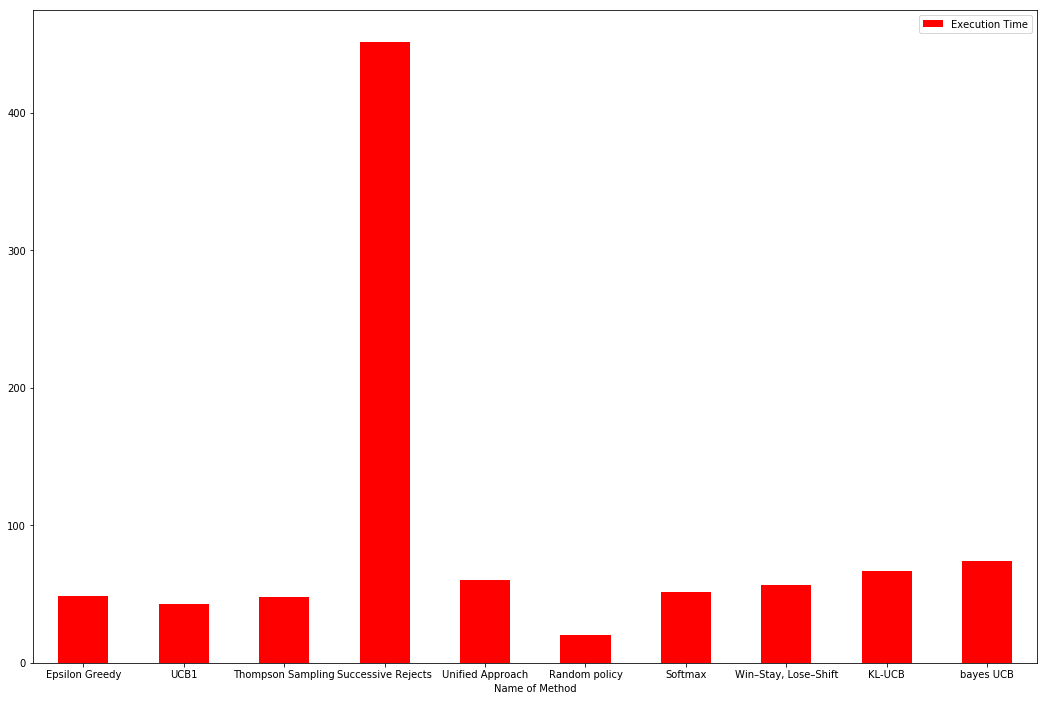

In [156]:
Time = {'Name of Method': ["Epsilon Greedy", "UCB1", "Thompson Sampling", "Successive Rejects","Unified Approach","Random policy", "Softmax", "Win–Stay, Lose–Shift","KL-UCB","bayes UCB"], 
        'Execution Time': [endG - startG, endU - startU, endT - startT, endS - startS, endUB - startUB, endP - startP, endSM - startSM, endWSLS - startWSLS, endklU - startklU, endbayucb - startbayucb]}
df_time = pd.DataFrame.from_dict(Time)
plt.rcParams['figure.figsize'] = (18, 12)
df_time.plot.bar(x='Name of Method', y='Execution Time', rot=0, color ='red');

## Accuarcy before pruning and after pruned 5% using different methods

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 5% using Random Policy on testing data =  0.8132530120481928

The accuracy of the model after pruned 5% using Epsilon Greedy on testing data =  0.8132530120481928

The accuracy of the model after pruned 5% using UCB1 on testing data =  0.8192771084337349

The accuracy of the model after pruned 5% using Thompson Sampling on testing data =  0.8132530120481928

The accuracy of the model after pruned 5% using Unified Approach on testing data =  0.8132530120481928

The accuracy of the model after pruned 5% using Successive Rejects on testing data =  0.8162650602409639

The accuracy of the model after pruned 5% using Softmax on testing data =  0.8192771084337349

The accuracy of the model after pruned 5% using Win–Stay, Lose–Shift on testing data =  0.8132530120481928

The accuracy of the model after pruned 5% using KL-UCB on testing data =  0.8253012048192772

The accuracy 

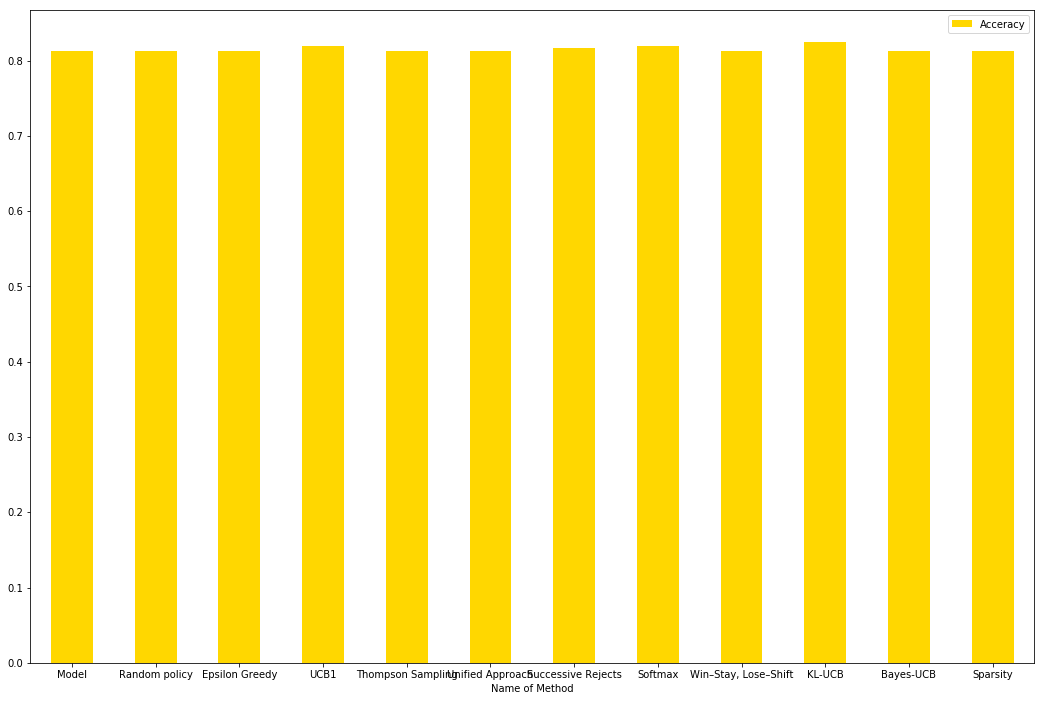

In [157]:
Testing_Accuracy = []
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)
Testing_Accuracy.append(accuracy)
#Random Policy
model = load_model('Random_Policy_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Random Policy on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Epsilon Greedy
model = load_model('Epsilon_Greedy_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Epsilon Greedy on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#UCB1
model = load_model('UCB1_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using UCB1 on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Thompson Sampling
model = load_model('Thompson_Sampling_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Thompson Sampling on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Unified Approach
model = load_model('Unified_Approach_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Unified Approach on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Successive Rejects
model = load_model('Successive_Rejects_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Successive Rejects on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Softmax
model = load_model('Softmax_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Softmax on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Win–Stay, Lose–Shift
model = load_model('WSLS_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Win–Stay, Lose–Shift on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#KL-UCB
model = load_model('kl_UCB_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using KL-UCB on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Bayes-UCB
model = load_model('bayucb_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Bayes-UCB on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

# Sparsity
model1 = load_model('sparse_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model1.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("\nThe accuracy of the model after pruning 5% using Sparsity method on testing data = ", accuracy_testing_Model)
Testing_Accuracy.append(accuracy)

Methods = ["Model", "Random policy", "Epsilon Greedy", "UCB1", "Thompson Sampling", "Unified Approach","Successive Rejects","Softmax" ,"Win–Stay, Lose–Shift", "KL-UCB","Bayes-UCB", "Sparsity"]

acc = {'Name of Method': Methods, 
        'Acceracy': Testing_Accuracy}
df_accauracy = pd.DataFrame.from_dict(acc)
plt.rcParams['figure.figsize'] = (18, 12)
df_accauracy.plot.bar(x='Name of Method', y='Acceracy', rot=0, color ='gold');

## Accuarcy before pruning and after pruned 10% using different methods

The accuracy of the model before pruning on testing data =  0.8132530120481928

The accuracy of the model after pruned 10% using Random Policy on testing data =  0.8132530120481928

The accuracy of the model after pruned 10% using Epsilon Greedy on testing data =  0.8253012048192772

The accuracy of the model after pruned 10% using UCB1 on testing data =  0.8253012048192772

The accuracy of the model after pruned 10% using Thompson Sampling on testing data =  0.8132530120481928

The accuracy of the model after pruned 10% using Unified Approach on testing data =  0.8162650602409639

The accuracy of the model after pruned 10% using Successive Rejects on testing data =  0.8132530120481928

The accuracy of the model after pruned 10% using Softmax on testing data =  0.822289156626506

The accuracy of the model after pruned 5% using Win–Stay, Lose–Shift on testing data =  0.8132530120481928

The accuracy of the model after pruned 10% using KL-UCB on testing data =  0.8283132530120482

The ac

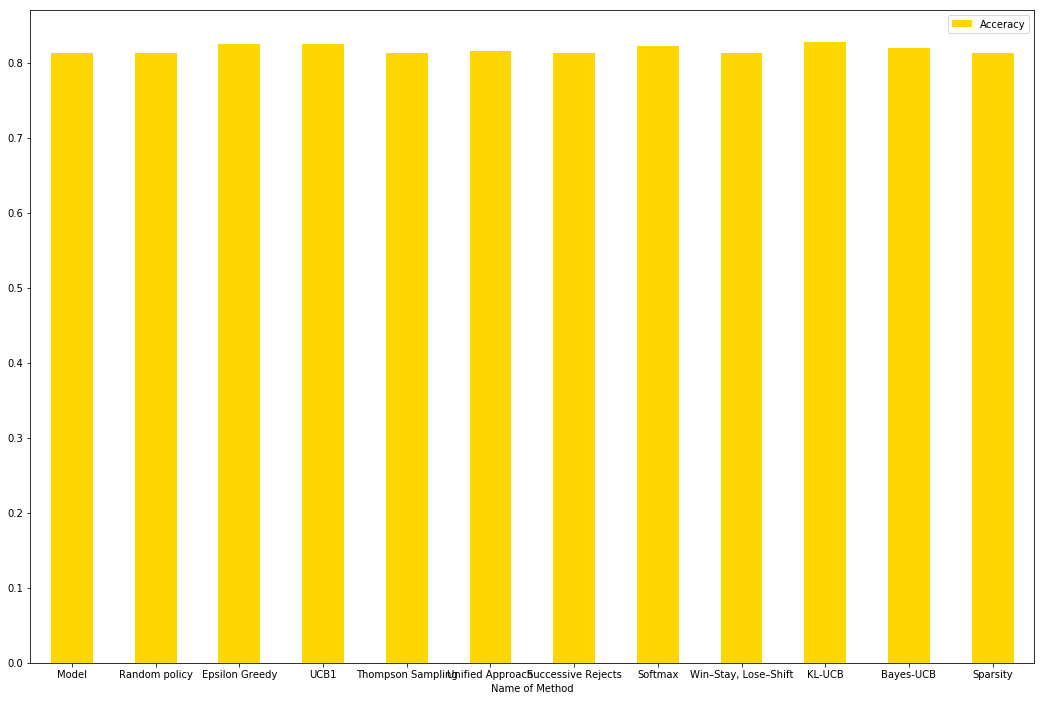

In [158]:
Testing_Accuracy = []
model = load_model('my_model.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("The accuracy of the model before pruning on testing data = ", accuracy_testing_Model)
Testing_Accuracy.append(accuracy)
#Random Policy
model = load_model('Random_Policy_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Random Policy on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Epsilon Greedy
model = load_model('Epsilon_Greedy_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Epsilon Greedy on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#UCB1
model = load_model('UCB1_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using UCB1 on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Thompson Sampling
model = load_model('Thompson_Sampling_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Thompson Sampling on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Unified Approach
model = load_model('Unified_Approach_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Unified Approach on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Successive Rejects
model = load_model('Successive_Rejects_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Successive Rejects on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Softmax
model = load_model('Softmax_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Softmax on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Win–Stay, Lose–Shift
model = load_model('WSLS_model_5_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 5% using Win–Stay, Lose–Shift on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#KL-UCB
model = load_model('kl_UCB_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using KL-UCB on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

#Bayes-UCB
model = load_model('bayucb_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model_05 = accuracy
print("\nThe accuracy of the model after pruned 10% using Bayes-UCB on testing data = ", accuracy_testing_Model_05)
Testing_Accuracy.append(accuracy)

# Sparsity
model1 = load_model('sparse_model_10_Pecernt.h5')
labelsTest = np_utils.to_categorical(y_test)
loss, accuracy = model1.evaluate(X_test, labelsTest, batch_size=1, verbose=0)
accuracy_testing_Model = accuracy
print("\nThe accuracy of the model after pruning 10% using Sparsity method on testing data = ", accuracy_testing_Model)
Testing_Accuracy.append(accuracy)

Methods = ["Model", "Random policy", "Epsilon Greedy", "UCB1", "Thompson Sampling", "Unified Approach","Successive Rejects","Softmax" ,"Win–Stay, Lose–Shift", "KL-UCB","Bayes-UCB", "Sparsity"]


acc = {'Name of Method': Methods, 
        'Acceracy': Testing_Accuracy}
df_accauracy = pd.DataFrame.from_dict(acc)
plt.rcParams['figure.figsize'] = (18, 12)
df_accauracy.plot.bar(x='Name of Method', y='Acceracy', rot=0, color ='gold');